# Lorenz System - PySINDy Application & Neural Network Prediction

## COLSA Corporation 

### Raj Garkhedkar, DACS Lab Summer 2021 Intern

## Table Of Contents
#### Lorenz System Explained, Visualized, & Animated
#### Attractor w/ PySINDy Implementation - DDSE Book
#### My Implementation Using PySINDy & Analysis
#### Neural Network For Parameter Prediction

The goal of this notebook is to demonstrate PySINDy for model discovery based on a captured time series evolution of the system, as well as implementing a neural network for parameter prediction. 

In [1]:
%matplotlib widget
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import IPython.display as IPdisplay
import scipy.sparse as sparse
import os
import glob
import time
import warnings
import pandas as pd
import pylab as pl
import math
import itertools
import operator
import scipy.misc
import IPython.display as ipdisplay
import torch
import torch.nn.functional as F
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
import torch.nn as nn
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Activation
from keras.models import Sequential
from keras.utils.generic_utils import get_custom_objects
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm.notebook import tqdm
from tqdm import trange, tqdm
from collections import defaultdict
from numpy.fft import rfft,irfft,rfftfreq
from time import process_time
from sklearn.model_selection import train_test_split
from scipy.integrate import odeint, solve_ivp
from scipy.signal import argrelextrema
from scipy.fftpack import diff as diffy
from scipy.sparse import dia_matrix, csc_matrix
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib import rcParams
from PIL import Image as pil
from PIL import ImageDraw as draw
from subprocess import check_output
from IPython.core.interactiveshell import InteractiveShell
from IPython import display
from IPython.core.display import Image

warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 2000
pd.get_option("display.max_columns")
pd.set_option("display.max_columns", None)
family = 'Times New Roman'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

###### Links

[Arxiv Original Paper](https://arxiv.org/pdf/2004.08424.pdf)

[UCSB MATLAB Paper](https://web.math.ucsb.edu/~jhateley/paper/lorenz.pdf)

[NASA Paper on SINDy & ML](https://ntrs.nasa.gov/api/citations/20200001544/downloads/20200001544.pdf) *big file, long loading time

[PySINDy Docs](https://pysindy.readthedocs.io/en/latest/index.html)

[PySINDy Examples (from docs)](https://pysindy.readthedocs.io/en/latest/examples/3_original_paper.html)

[PySINDy Publication - Official Paper](https://www.researchgate.net/publication/340806743_PySINDy_A_Python_package_for_the_Sparse_Identification_of_Nonlinear_Dynamics_from_Data)

[PySINDy GitHub Page](https://github.com/dynamicslab/pysindy)

[Lorenz NN](https://gist.github.com/raspstephan/8e9ecc9f2b74e528dff8056a0e76846c?short_path=e703112#file-lorenztorch-ipynb)

[PySINDy Syntax & API Docs](https://pysindy.readthedocs.io/en/latest/api/pysindy.html)

[Lorenz FNN GitHub](https://github.com/williamgilpin/fnn)

[Chaos & Attractors](https://blogs.rstudio.com/ai/posts/2020-06-24-deep-attractors/)

[Arxiv of Time Series Reconstruction of Attractors](https://arxiv.org/abs/2002.05909)

[Learning Chaotic Dynamics Arxiv](https://arxiv.org/pdf/1903.10335.pdf)

[Deep Representation Learning for Dynamical Systems Arxiv](https://arxiv.org/pdf/2002.05111.pdf)

[Nonlinear LSTM repo](https://github.com/srpraveen97/LSTM_nonlinear)

[Neural ODE Repo](https://github.com/msurtsukov/neural-ode)

[Properly Seeding](https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752)

[Seeding Jupyter Article](https://notebook.community/ageron/ml-notebooks/extra_tensorflow_reproducibility)

[Torch DiffEq Repo](https://github.com/rtqichen/torchdiffeq/tree/master/assets)

[Differential NN Repo](https://github.com/hungngo97/differential-neural-network/blob/master/main.ipynb)

[Modeling Chaotic ODEs repo](https://github.com/vbjan/Chaos_NeuralODE/blob/master/FullStateObsNODE.py)
-- -- -- -- -- --

###### Foreword On Reproducibility:
So an issue I was occassionally running into was seeding for reproducibility. In the DDSE book and Brunton's work online, they've used `np.random.seed()` for seeding. It turns out that if not seeded, `RandomState` will read data from /dev/urandom or seed from the clock. They use 100 for their purposes to generate the same 100 but they use the command in that specific cell. My research on this topic led me to information that says Jupyter can't recognize the seed in the cells where it's not explicitly declared, so using numpy to set the seed once won't do. As mentioned in the [Seeding Jupyter Article](https://notebook.community/ageron/ml-notebooks/extra_tensorflow_reproducibility) article, it seems that the Python kernel must be started up with `PYTHONHASHSEED=0` declared explicitly. However, for multithreading and efficiency reasons, since I'm dealing with modeling dynamical systems with large matrix transformations, speed is paramount & a careful cooperation between global reproducibility & efficiency must be formed... therefore I can't guarantee the results will be fully reproducible on any system, but, I will seed everytime in order to ensure either same or extremely similar results. I've tried to control & tame the 'randomness' as much as possible, in short. 

## Lorenz System

The Lorenz system is a system of ordinary differential equations (ODE's) which has very chaotic solutions based on initial conditions. The Lorenz Attractor is a set of specific chaotic solutions for the Lorenz system which, when plotted, resembles a butterfly. 

Mathematically, the system of equations are: 

$$\frac{dx}{dt} = \sigma(y-x)$$
<br>
$$\frac{dy}{dt} = x(\rho - z) - y$$
<br>
$$\frac{dz}{dt} = xy + \beta z$$

Below code is a regular NumPy implementation to demonstrate how it's supposed to look. 

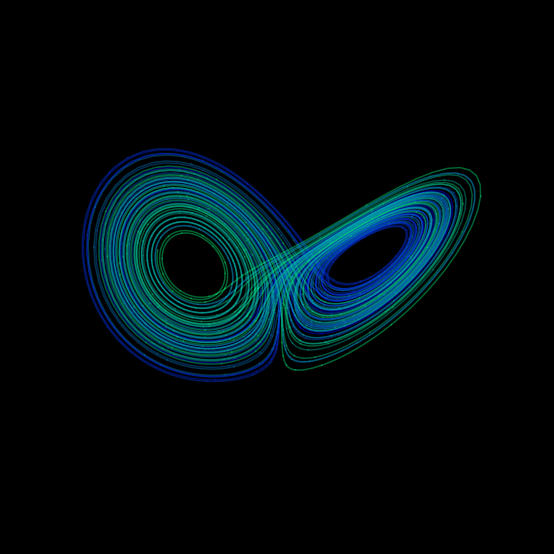

If you wish to mess around with different initial conditions and boundary conditions, unhash the `input` code above


In [2]:
WIDTH, HEIGHT, DPI = 1000, 750, 100

# Unhash below to play around with different values

# sigma = float(input("Enter A Number: "))
# beta = float(input("Enter A Number: "))
# rho = float(input("Enter A Number: "))

# u0 = float(input("Enter An Initial Condition Number: "))
# v0 = float(input("Enter An Initial Condition Number: "))
# w0 = float(input("Enter An Initial Condition Number: "))


# Lorenz paramters and initial conditions.
sigma = 10
beta = 2.66667
rho = 28
u0 = -8
v0 = 8
w0 = 27

# Maximum time point and total number of time points.
tmax, n = 100, 10000

def lorenz(t, X, sigma, beta, rho):
    """The Lorenz equations."""
    x, y, z = X
    dx = - sigma * (x - y)
    dy = rho * x - y - x * z
    dz = - beta * z + x * y
    return dx, dy, dz

# Integrate the Lorenz equations.
soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho),
                 dense_output=True)
# Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

# Plot the Lorenz attractor using a Matplotlib 3D projection.
fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
ax = fig.gca(projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in color across the whole time series.
s = 10
cmap = plt.cm.winter
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)
ax.set_axis_off()
plt.show()

print('If you wish to mess around with different initial conditions and boundary conditions, unhash the `input` code above')

So that's what it looks like with what the conditions/parameters I input... looks cool (or bad, yikes)

Hint (enter the following, in order, for a cool attractor):
`10`
`2.66667`
`28`
`-8`
`8`
`27`
OR
`20`
`6.7435`
`80`
`2`
`2`
`2`
<br>

Below, I'm animating the chaotic system to show how the particle changes trajectory depending on the initial conditions. 

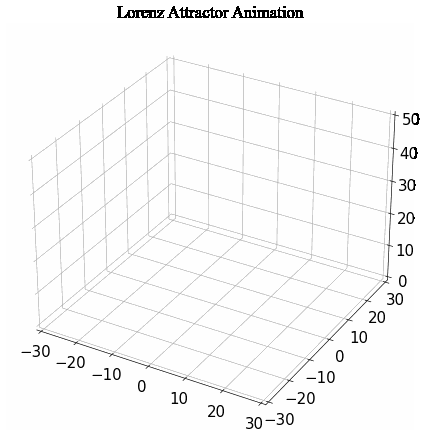

In [3]:
# Burner folder to temporary store images
folder = '/Users/rajgark/Desktop/PySINDy/AttractorImages' 

# Function for lorenz system
def lorenz_animated(current_state, t):
    x, y, z = current_state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

def plot_lorenz(xyz, n):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.gca(projection='3d')
    ax.xaxis.set_pane_color((1,1,1,1))
    ax.yaxis.set_pane_color((1,1,1,1))
    ax.zaxis.set_pane_color((1,1,1,1))
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]
    ax.plot(x, y, z, color='g', alpha=0.7, linewidth=0.7)
    ax.set_xlim((-30,30))
    ax.set_ylim((-30,30))
    ax.set_zlim((0,50))
    ax.set_title('Lorenz Attractor Animation', fontproperties=title_font)
    
    plt.savefig('{}/{:03d}.png'.format(folder, n), dpi=60, bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
    
def chunky(full_list, size):
    size = max(1,size)
    chunks = [full_list[0:i] for i in range(1,len(full_list) + 1, size)]
    return chunks

start = 0
end = 60
interval = 100
initial_state = [0.1,0,0]
timepoints = np.linspace(start, end, end*interval)
chunks = chunky(timepoints, size = 20)
points = [odeint(lorenz_animated, initial_state, chunk) for chunk in chunks ]
for n, point in enumerate(points):
    plot_lorenz(point, n)
    

fp_in = '/Users/rajgark/Desktop/PySINDy/AttractorImages/*.png'
fp_out = '/Users/rajgark/Desktop/PySINDy/AttractorImages/attractorgif.gif'

img, *imgs = [pil.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp = fp_out, format = 'gif', append_images = imgs, save_all = True, duration = 200, loop = 0)
IPdisplay.Image('/Users/rajgark/Desktop/PySINDy/AttractorImages/attractorgif.gif')

In [4]:
# Deletes all images captured to make gif. 
files = glob.glob('/Users/rajgark/Desktop/PySINDy/AttractorImages/*')
for f in files:
    os.remove(f)

## Lorenz  Attractor w/ PySINDy Implementation

This PySINDy implementation is guided by the original docs.

In [5]:
def sindylorenz(x, t):
    return [
        10 * (x[1] - x[0]),
        x[0] * (28 - x[2]) - x[1],
        x[0] * x[1] - 8 / 3 * x[2],
    ]
dt = 0.001
t_train = np.arange(0,100,dt)
print('t_train size: ',t_train.size)
x0_train = [-8, 8, 27] 
x_train = odeint(sindylorenz, x0_train, t_train)
x_dot_train_measured = np.array([sindylorenz(x_train[i], 0) for i in range(t_train.size)])

t_train size:  100000


This is their implementation based on the PySINDy docs

In [6]:
x_train

array([[-8.        ,  8.        , 27.        ],
       [-7.84087856,  7.98355342, 26.86488252],
       [-7.68350838,  7.96625052, 26.73151873],
       ...,
       [-5.31069055, -8.18331516, 16.83582711],
       [-5.33952879, -8.23455986, 16.83464659],
       [-5.36859135, -8.28608134, 16.83398129]])

In [7]:
t_train

array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 9.9997e+01, 9.9998e+01,
       9.9999e+01])

In [8]:
polynomial_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)

optimize = ps.STLSQ(threshold = threshold)
featurelib = ps.PolynomialLibrary(degree = polynomial_order)

model = ps.SINDy(optimizer = optimize, feature_library = featurelib)
model.fit(x_train, t = dt, x_dot = x_dot_train_measured + np.random.normal(size = x_train.shape), quiet = True)
#models = []
#tsim = np.arange(0,20,dt)
#xsim = []
#noises = [1e-3, 1e-3, 1e-2, 1e-1, 1.0]

# for eps in noises:
#     model = ps.SINDy(optimizer = optimize, feature_library = featurelib)
#     model.fit(x_train, t = dt, x_dot = x_dot_train_measured + np.random.normal(scale = eps, size = x_train.shape), quiet = True)
#     models.append(model)
#     xsim.append(model.simulate(x_train[0], tsim))

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=5),
      feature_names=['x0', 'x1', 'x2'], optimizer=STLSQ(threshold=0.05))

The hashed out code is from the docs, I had it to debug. The optimizer actually can choose random values so it's important to make sure the notebook is seeded for reproducibility.

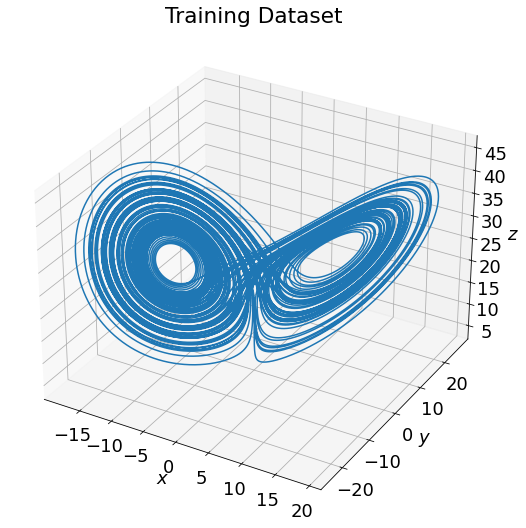

In [9]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_train.size, 0],
    x_train[: t_train.size, 1],
    x_train[: t_train.size, 2],
)
plt.title("Training Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

Above is how the attractor looks for the training dataset

In [10]:
model.print()

x0' = -9.998 x0 + 9.998 x1
x1' = 28.001 x0 + -1.001 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


`x0' = -9.998 x0 + 9.998 x1
x1' = 28.001 x0 + -1.001 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1`

These are the predictions of the model, or I should say, the coefficients predicted for the ODE.Those should be the outputs of the above cell, this is with an optimizer and feature library.

In [11]:
t_test = np.arange(0, 15, dt)
x0_test = np.array([-8,7,15])
x_test = odeint(sindylorenz, x0_test, t_test)

Above I've done a test set on a trajectory guided through the discovery made in the train set. The initial conditions are different here, so an approximation made here, if accurate, means the model is behaving like a good guy

In [12]:
t_test.size

15000

In [13]:
x_test.size

45000

Ignore above output, done for my testing.

In [14]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_test[: t_test.size, 0],
    x_test[: t_test.size, 1],
    x_test[: t_test.size, 2],
)
plt.title("Testing Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

The goal now will be to leverage the training dataset and testing dataset to make a simulation which goes forward in time accurately projecting the trajectory of the chaotic particles.
<br> 
After doing so, a neural network can be implemented (as done in DDSE pg. 216 by Brunton & Kutz) to create a robust system for modeling the lorenz system of equations.

### My Implementation

I aim to play around with the variables and analyze how noisy simulations vs non-noisy simulations fare for the library

In [15]:
newdt = 0.002

t_trainset = np.arange(0, 100, newdt)
x0_trainset = [-8, 8, 27]
x_trainset = odeint(sindylorenz, x0_trainset, t_trainset)

newmodel = ps.SINDy()
newmodel.fit(x_trainset, t = newdt)
newmodel.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


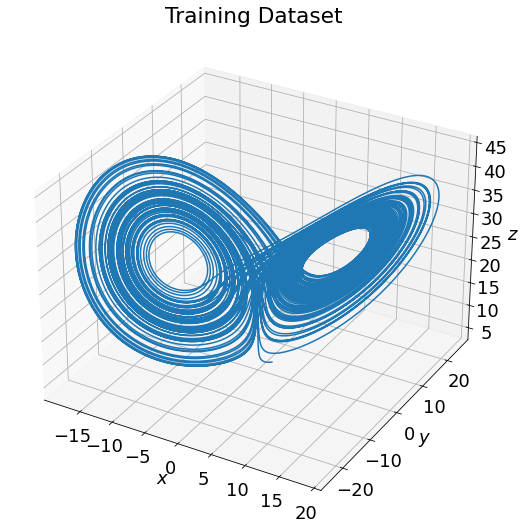

In [16]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_trainset[: t_trainset.size, 0],
    x_trainset[: t_trainset.size, 1],
    x_trainset[: t_trainset.size, 2],
)
plt.title("Training Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()
plt.figure(figsize = (20,20))
plt.plot(x_trainset[:t_trainset.size], linewidth = 0.5)
plt.show()

Above is a new model created and fit to the training data with a graph representing the trajectory. The green is the z-axis and orange/blue are x/y switches. 

In [17]:
t_testset = np.arange(0, 15, newdt)
x0_testset = np.array([8, 7, 15])
x_testset = odeint(sindylorenz, x0_testset, t_testset)

print('Model score: %f' % model.score(x_testset, t = newdt))

Model score: 1.000000


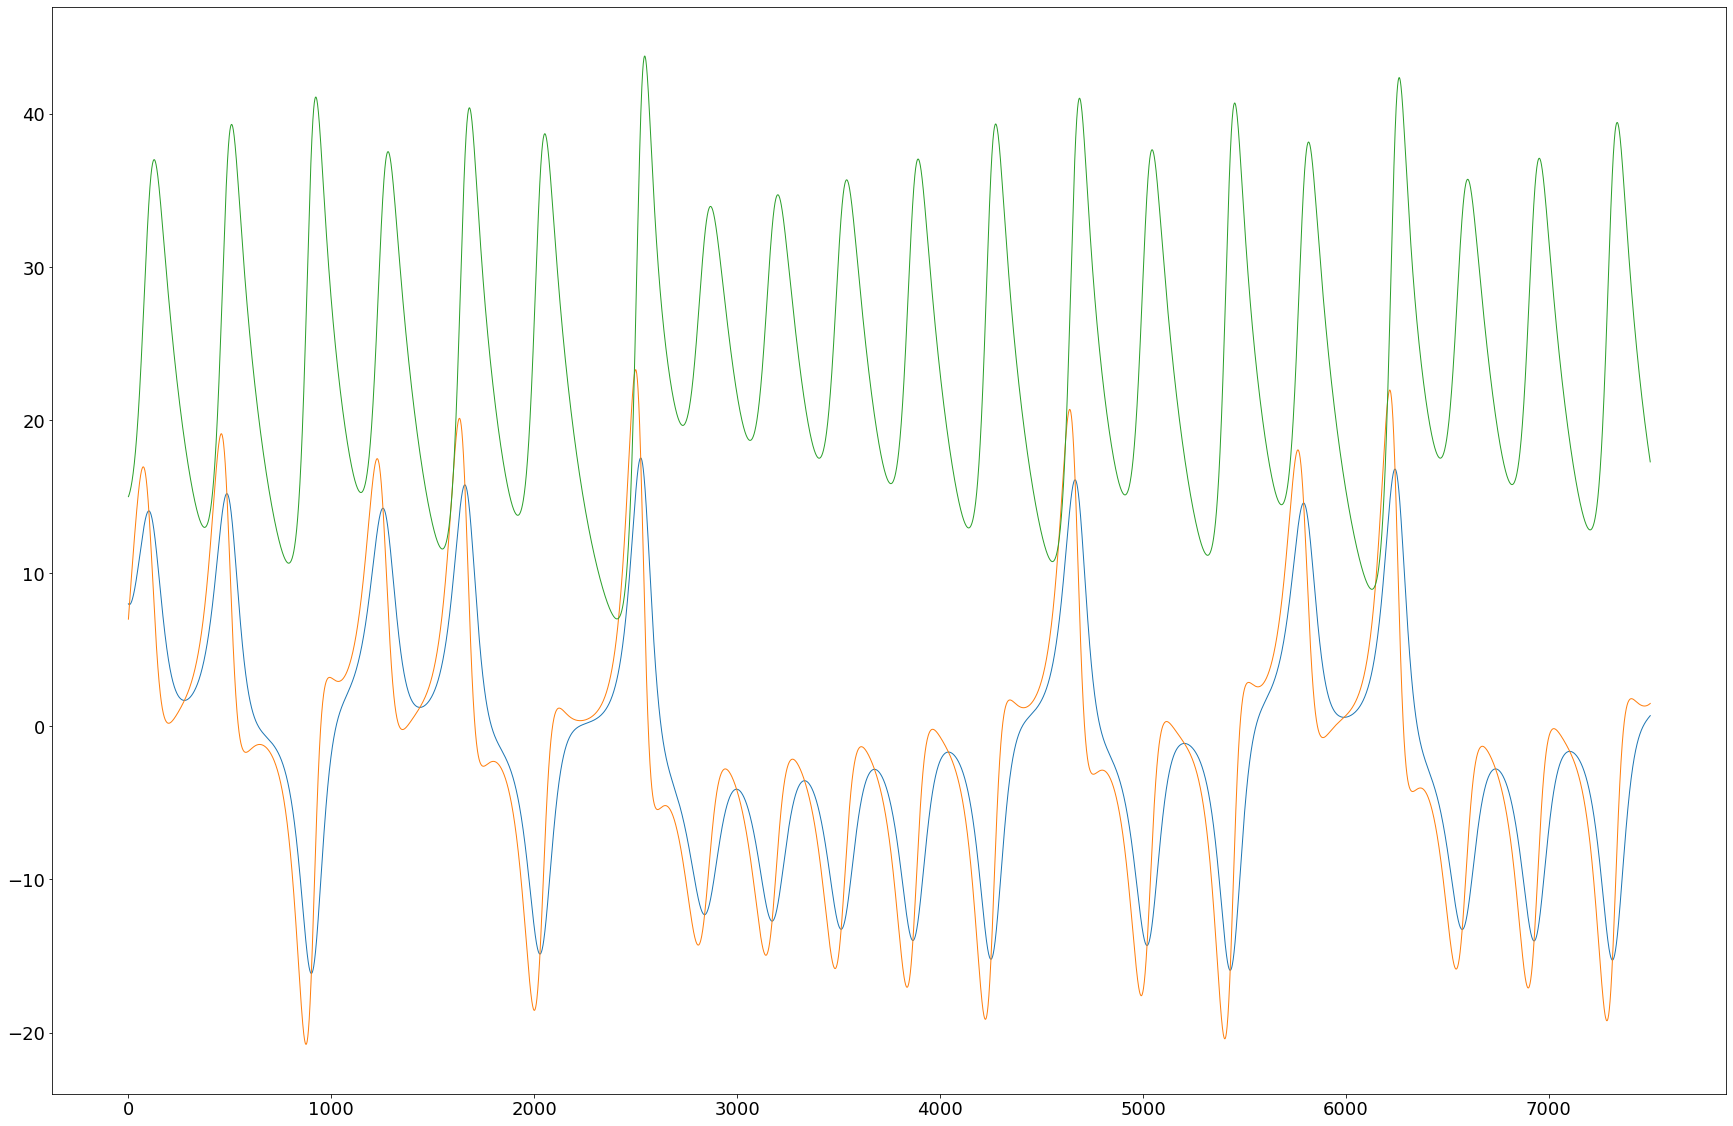

In [18]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_testset[: t_testset.size, 0],
    x_testset[: t_testset.size, 1],
    x_testset[: t_testset.size, 2],
)
plt.title("Test Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()
plt.figure(figsize = (30,20))
plt.plot(x_testset[:t_testset.size], linewidth = 1)
plt.show()

The test system above is with a smaller dataset and different initial conditions than the training dataset. Scoring the test dataset against the model trained w/ training data, we see a perfect fit, thus indicating it's able to predict the derivatives properly

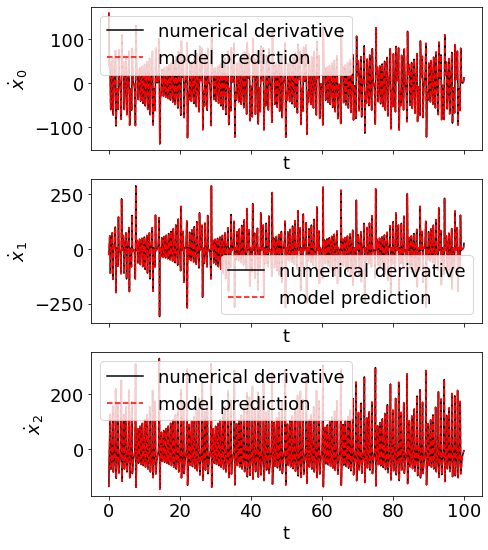

In [19]:
x_dot_train_pred = newmodel.predict(x_trainset)

x_dot_train_comp = newmodel.differentiate(x_trainset, t = newdt)

fig, axs = plt.subplots(x_trainset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_trainset.shape[1]):
    axs[i].plot(t_trainset, x_dot_train_comp[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_trainset, x_dot_train_pred[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

Predicting the derivative graphed against the true derivative shows that it matches up perfectly

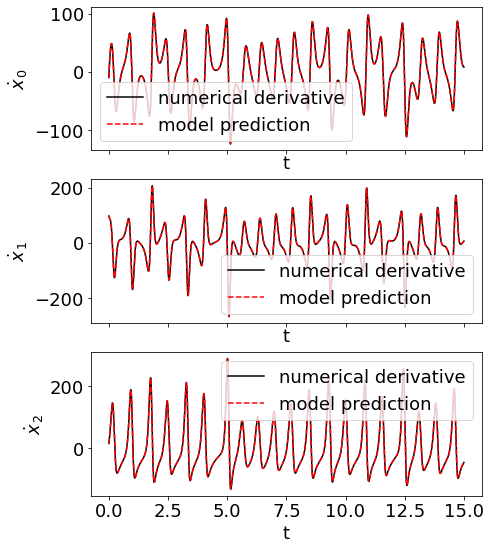

In [20]:
x_dot_test_pred = newmodel.predict(x_testset)

x_dot_test_comp = newmodel.differentiate(x_testset, t = newdt)

fig, axs = plt.subplots(x_testset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_testset.shape[1]):
    axs[i].plot(t_testset, x_dot_test_comp[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_testset, x_dot_test_pred[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

Same story here

In [21]:
x_test_sim = newmodel.simulate(x0_testset, t_testset)
x_test_sim.shape

(7500, 3)

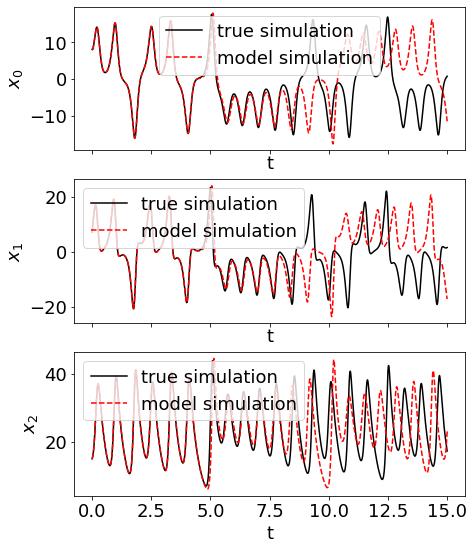

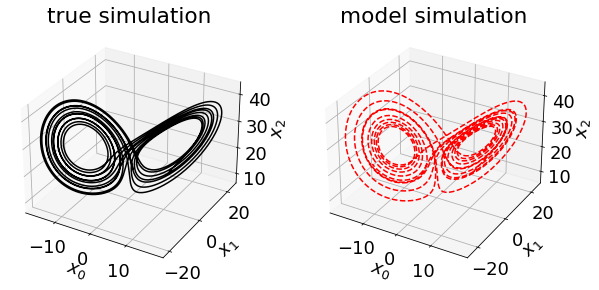

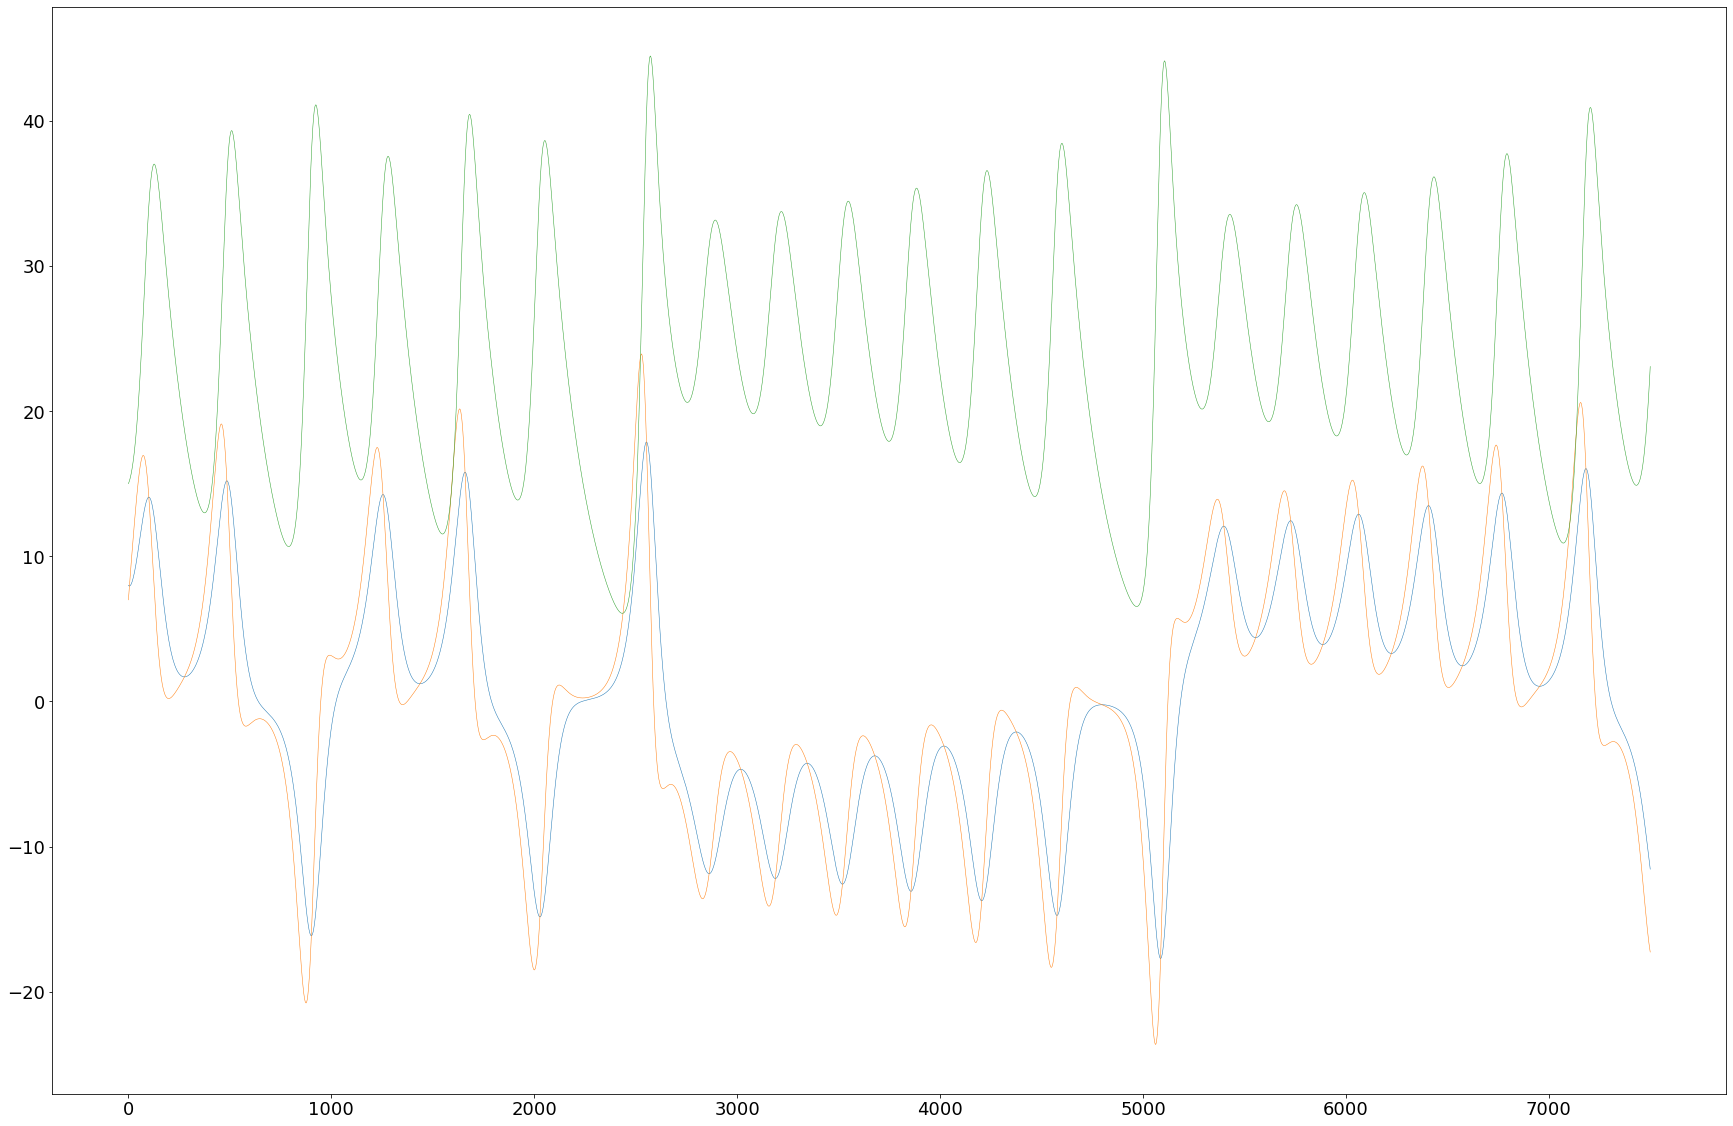

In [22]:
fig, axs = plt.subplots(x_testset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_testset.shape[1]):
    axs[i].plot(t_testset, x_testset[:, i], 'k', label='true simulation')
    axs[i].plot(t_testset, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_testset[:, 0], x_testset[:, 1], x_testset[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()
plt.figure(figsize = (30,20))
plt.plot(x_test_sim[:t_testset.size], linewidth = 0.5)
plt.show()

Running the PySINDy simulation method shows that if kept going, the modeled sparse regression approach would eventually converge on the true simulation, meaning it would properly approximate the future state based on the derivatives & current state

### Measure only $x$ states & compute derivatives

In [23]:
polynomial_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)

t_sim = np.arange(0, 20, newdt)
garbmodel = ps.SINDy(optimizer = optimize, feature_library = featurelib)
garbmodel.fit(x_trainset + np.random.normal(size = x_trainset.shape), t = newdt, quiet = True)
x_sim_nod = garbmodel.simulate(x_trainset[0], t_sim)

x_dot_train_measured_new = np.array([sindylorenz(x_trainset[i], 0) for i in range(t_trainset.size)])

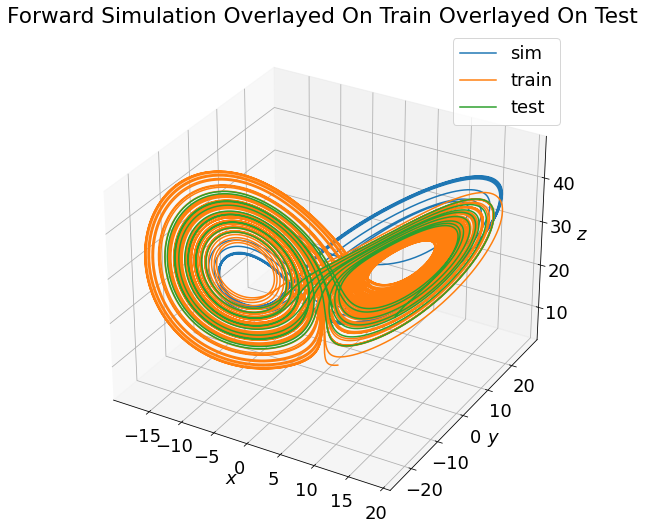

In [24]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
# Blue
pl1 = ax.plot(
    x_sim_nod[: t_sim.size, 0],
    x_sim_nod[: t_sim.size, 1],
    x_sim_nod[: t_sim.size, 2],
    label='sim'
)
# Orange
pl2 = ax.plot(
    x_trainset[: t_trainset.size, 0],
    x_trainset[: t_trainset.size, 1],
    x_trainset[: t_trainset.size, 2],
    label='train'
)
# Green
pl3 = ax.plot(
    x_testset[: t_testset.size, 0],
    x_testset[: t_testset.size, 1],
    x_testset[: t_testset.size, 2],
    label='test'
)
plt.title("Forward Simulation Overlayed On Train Overlayed On Test")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
#ax.legend([pl1, pl2, pl3], ['Sim','Train','Test'])
ax.legend()
fig.show()

The training and simulation show a semblance of similarity, meaning the algorithm is needs a bit of tuning. If you notice the forward simulation (blue), it can be noticed that the blue appearing on the top right area is what the training matrix will look like if the algorithm continues differentiating forward, thus 'completing' it. Essentially showing how the system will evolve. 

In [25]:
seed = 100
np.random.seed(seed)
noisedt = 0.001
noise_t_train = np.arange(0, 20, noisedt)
noise_x0_train = [-8,8,27]
noise_x_train = odeint(sindylorenz, noise_x0_train, noise_t_train)
noise_xdot_train_measured = np.array([sindylorenz(noise_x_train[i], 0) for i in range(noise_t_train.size)])

poly = 5
threshold = 0.5

optimize = ps.STLSQ(threshold = threshold)
flib = ps.PolynomialLibrary(degree = poly)

noises = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

noisemodels = []
noise_t_sim = np.arange(0, 20, noisedt)
noise_x_sim = []

for levels in noises:
    noisemodel = ps.SINDy(optimizer = optimize, feature_library = flib,)
    noisemodel.fit(noise_x_train, t = noisedt, x_dot = noise_xdot_train_measured + np.random.normal(scale = levels, size = noise_x_train.shape), quiet = True)
    noisemodels.append(noisemodel)
    noise_x_sim.append(noisemodel.simulate(noise_x_train[0], noise_t_sim))
    noisemodel.print()

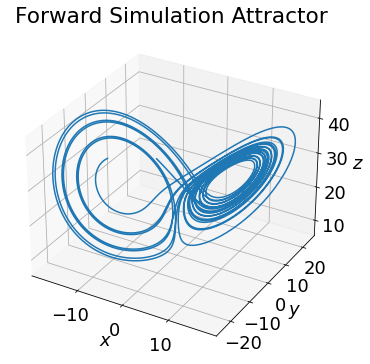

In [26]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(131, projection="3d")
model_idx = 2
ax.plot(
    noise_x_sim[model_idx][:, 0],
    noise_x_sim[model_idx][:, 1],
    noise_x_sim[model_idx][:, 2],
)
plt.title("Forward Simulation Attractor")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.show()

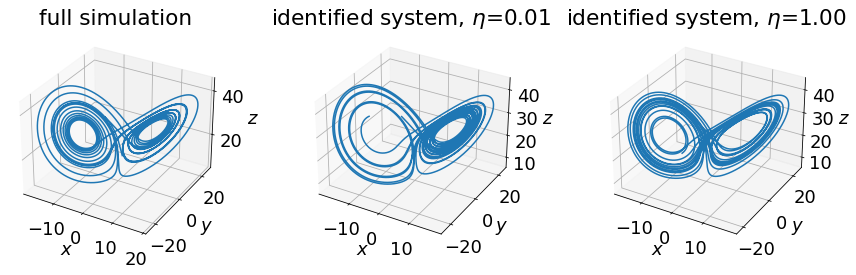

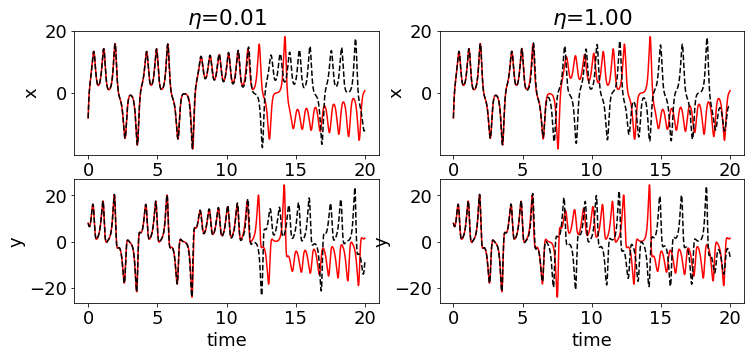

In [27]:
# Plot results

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    noise_x_train[: noise_t_sim.size, 0],
    noise_x_train[: noise_t_sim.size, 1],
    noise_x_train[: noise_t_sim.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(noise_x_sim[model_idx][:, 0], noise_x_sim[model_idx][:, 1], noise_x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noises[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(133, projection="3d")
ax.plot(noise_x_sim[model_idx][:, 0], noise_x_sim[model_idx][:, 1], noise_x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noises[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig = plt.figure(figsize=(12, 5))
model_idx = 2
ax = fig.add_subplot(221)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 0], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noises[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(223)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 1], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

model_idx = 4
ax = fig.add_subplot(222)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 0], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noises[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(224)
ax.plot(noise_t_sim, noise_x_train[: noise_t_sim.size, 1], "r")
ax.plot(noise_t_sim, noise_x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

fig.show()

This is pretty much identical to the DDSE findings for the noisy simulation, like in the docs

### Multiple Trajectories w/ Different Time Measurements

This dataset generates 50 random trajectories measured across random time domains. 

In [28]:
seed = 100
np.random.seed(seed)
n_trajectories = 50

x0s = np.array([36, 48, 41]) * (np.random.rand(n_trajectories, 3) -0.5) + np.array([0,0,25])
x_train_multi = []
t_train_multi = []

for i in range(n_trajectories):
    n_samples = np.random.randint(250,3000)
    t = np.arange(0, n_samples * newdt, newdt)
    x_train_multi.append(odeint(sindylorenz, x0s[i], t))
    t_train_multi.append(t)

model = ps.SINDy()
model.fit(x_train_multi, t = newdt, multiple_trajectories = True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.993 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


In [29]:
print('Multi-trajectory array shape: ',np.shape(x_train_multi))
#t_train_multi

Multi-trajectory array shape:  (50,)


In [30]:
def multi_traj_plot(particle_ID):
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(131, projection="3d")
    multi_idx = particle_ID
    ax.plot(
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 0],
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 1],
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 2],
    )
    plt.title("Randomized Attractor")
    ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
    fig.show()

The function above plots the randomized attractor w/ random temporal measurements

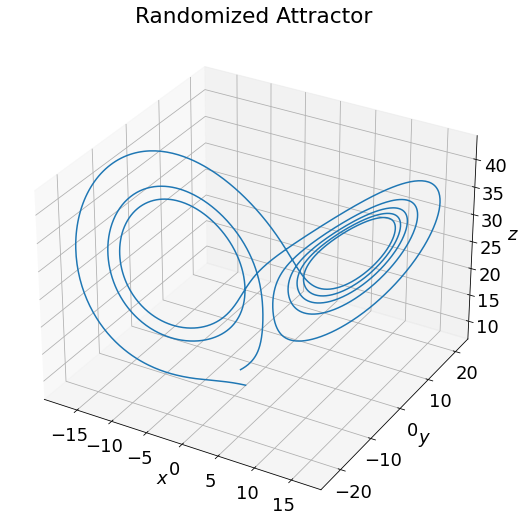

In [70]:
multi_traj_plot(30)

There are 50 (0-49) particles with random trajectories in the variable `x_train_multi` and to show the particle trajectory for any one of your choice, simply enter a number, 0-19, into the argument for the function `multi_traj_plot(enter#here)` 
<br>
The array consists of 20 particles with unique trajectories and times, so there is a very high likelihood of the selected pattern being obscure rather than a good looking attractor. This is due to the sampling rate being multiplied by `newdt` so regardless of the number, the infinitesimal increase dictates the shape of the array. Leaving it to the value it's set at is the best for reproducing valid data throughout the notebook, but newdt can be reassigned on the top of the cell right under the new multi-trajectory section if desired, being sure to hash it out while executing the notebook again.

## Lorenz System Neural Network

Since PySINDy has been implemented for model prediction & simulation, the next step is to create a neural network to predict the dynamical system's evolution spatially & temporally. The variable at hand is $x(t)$ where $x$ is the state of the system at time $t$, and the prediction (output) is $y(t+dt)$, or the state of the system after some infinitesimal time $dt$.

In DDSE pg. 216, Brunton & Kutz mention that the state of the system is given by the matrix $\textbf{x} = [x\ y\ z]^T$ and it'll require a nonlinear transfer function since the system itself is nonlinear.
<br>
<br>
The goal of the system is to produce an output matrix of the system at some arbitrary time after the measured state. 

### DDSE Prof. Brunton's Implementation

Their implementation, as done in their book & code, was outdated. They used an older Keras which is incompatible, so I redid their implementation.

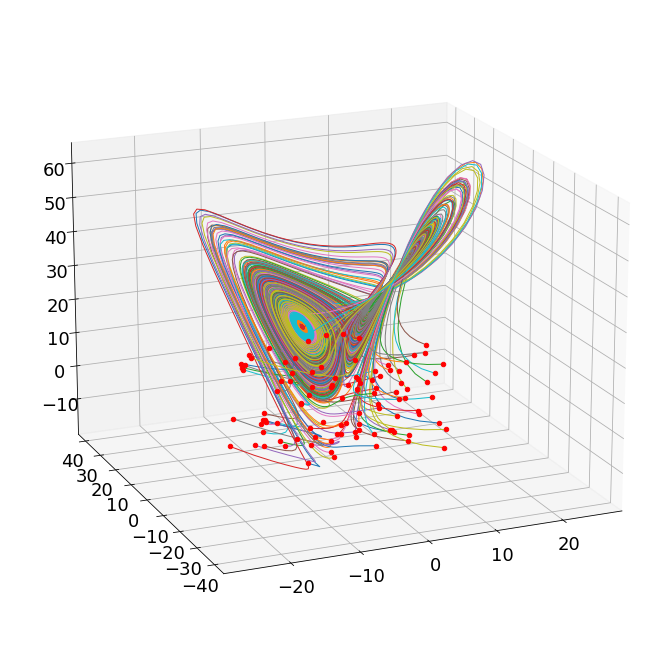

In [32]:
## Simulate the Lorenz System

dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28


nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

In [33]:
## Neural Net
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape = (3)))
model.add(layers.Dense(10,activation='sigmoid'))
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(10,activation='linear'))
model.add(layers.Dense(3,None))
model.summary()
model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(nn_input, nn_output, batch_size = 1, epochs = 30)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 293
Trainable params: 293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
80000/80000 [==============================] - 73s 908us/step - loss: -44278240.0000 - accuracy: 0.9818
Epoch 2/30
80000/80000 [==============================] - 72s 902us/step - loss: -606111744.0000 - accuracy: 0.9818
Epoch 3/30
80000/80000 [=

Training for 30 epochs takes quite some time, but it's generally a good model

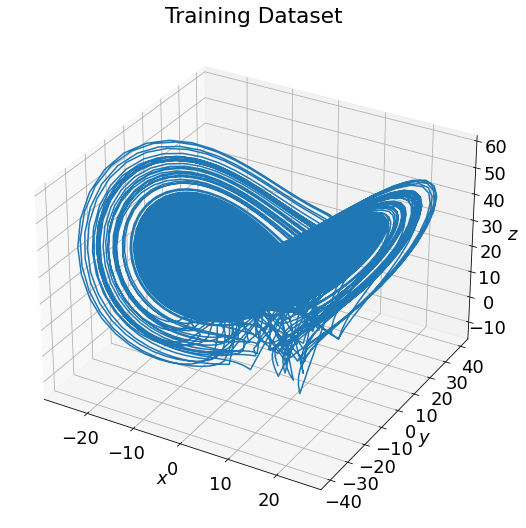

In [34]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    nn_input[: , 0],
    nn_input[: , 1],
    nn_input[: , 2],
)
plt.title("Training Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

## My Implementation

My attempt with creating a neural network for parameter learning. Considering a 'true' system, one which is controlled, I've compared that with a perturbed system with parameters which are slightly greater or lower than their truth counterpart. The goal will be to figure out how to bring the perturbed parameters closer to the ground truth values.

### Parameter Learning w/ discretized Lorenz 63

The goal of parameter learning is to incorporate automatic differentiation to compute gradients of a loss function with respect to the model parameters. Because in real life, systems are fine tuned to their specific purpose, a dynamic discovery of changing parameters proves to be challenging, so a perturbed system will be cumbersome in calibrating a system. 

We should expect to see the perturbed system's parameters reach close to the true models parameters. 

In control theory, a system where there is potential for perturbation, should return back to initial state for the system to work as intended.

In [55]:
sigma = 10
rho = 28
beta = 8/3

class LorenzTorch():
    def __init__(self, sigma, rho, beta, init, dt, param_grads):
        self.sigma, self.rho, self.beta = [Converter(param, param_grads) for param in [sigma, rho, beta]]
        self.x, self.y, self.z = [Converter(i) for i in init]
        self.dt = Converter(dt)
        self.hist = []
        self.step_count = 0
    
    def step(self):
        self.x = self.x + (self.sigma * (self.y - self.x)) * self.dt
        self.y = self.y + (self.x * (self.rho - self.z)) * self.dt
        self.z = self.z + (self.x * self.y - self.beta * self.z) * self.dt
        self.hist.append(np.squeeze(np.array([np.copy(var.data.cpu().numpy()) for var in [self.x, self.y, self.z]])))
        self.step_count += 1
    
    def integrate(self, n_steps):
        for n in range(n_steps): self.step()

def Converter(x, requires_grad=False, gpu=False):
    t = torch.FloatTensor(np.atleast_1d(x).astype(np.float32))
    if gpu: t = t.cuda()
    return Variable(t, requires_grad=requires_grad)

def plot_attractor(hists):
    if np.array(hists).ndim == 2: hists = [hists]
    hists = [np.array(h) for h in hists]
    fig = plt.figure(figsize=(10, 10)); ax = fig.gca(projection='3d')
    [ax.plot(h[:,0], h[:,1], h[:,2]) for h in hists]


def mse(true, pred):
    return ((true - pred) ** 2).mean()
    
def stack_state(l, sparse=None):
    s = torch.stack([l.x, l.y, l.z])
    if sparse is not None: s = s[sparse]
    return s    

def learning_loop(true_params, pert_params, lr, n_model_steps, n_learn_steps, sparse=None):
    hist = defaultdict(list)
    init = list(np.random.rand(3) * 10)
    for n_learn in tqdm(range(n_learn_steps)):
        ltrue = LorenzTorch(*true_params, init, 1e-2, False); ltrue.integrate(n_model_steps)
        lpert = LorenzTorch(*pert_params, init, 1e-2, True); lpert.integrate(n_model_steps)
        loss = mse(stack_state(ltrue, sparse), stack_state(lpert, sparse))
        loss.backward()
        grads = [lpert.sigma.grad.data.numpy(), lpert.rho.grad.data.numpy(), lpert.beta.grad.data.numpy()]
        pert_params = [pert_params[i] - lr*var.grad.data.numpy() for i, var in
                      enumerate([lpert.sigma, lpert.rho, lpert.beta])]
        hist['loss'].append(loss.data.numpy()); hist['pert_params'].append(pert_params)
        init = ltrue.hist[-1]
        print('Loss: ', loss)
    print('-- -- -- -- -- -- -- -- -- -- -- -- --')
    print(' ')
    print('Total Loss: ', loss)
    return hist
    
def plot_params(h):
    [plt.plot(np.array(h['pert_params'])[:, i] - true, label=l) 
     for l, (i, true) in zip(['sigma', 'rho', 'beta'], enumerate([sigma, rho, beta]))]
    plt.axhline(0, c='gray', zorder=0.1); plt.legend(); plt.title('Parameter error');

The above cell contains the class for creating an attractor object with appropriate `dt` steps and all the functions that aid with plotting & training

The below cell creates a control run where the system is untouched, pure, in a sense. 

In [56]:
ltrue = LorenzTorch(sigma, rho, beta, init=[-8, 8, 28], dt=1e-2, param_grads=False)

ltrue.integrate(2000)

(10, 2.6666666666666665, 28)

Below, the system is a bit perturbed, so the 3 parameters are slightly off. Same initial conditions, however. Plotting below shows how the perturbed system differs from the true system. 

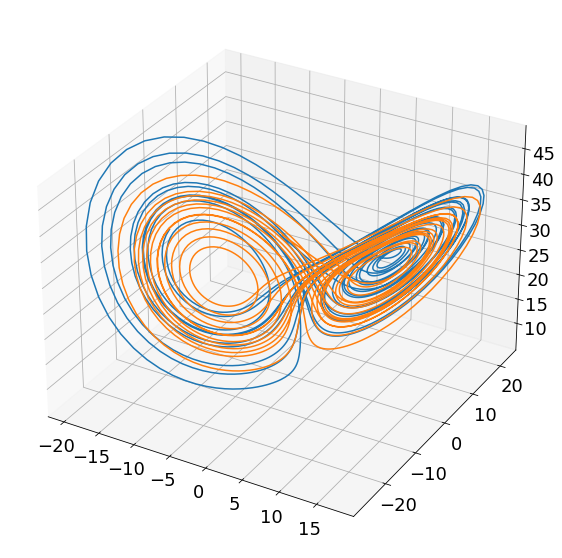

In [57]:
lpert =  LorenzTorch(sigma + 1, rho - 2, beta - 0.3, init=[-8, 8, 28], dt=1e-2, param_grads=True)

lpert.integrate(2000)

plot_attractor([ltrue.hist, lpert.hist])


In [59]:
loss = mse(stack_state(ltrue), stack_state(lpert))
loss

tensor(195.4440, grad_fn=<MeanBackward0>)

Above is the loss, using MeanSquaredError. 

In [60]:
loss.backward()

lpert.sigma.grad, lpert.rho.grad, lpert.beta.grad

(tensor([5.7909e+08]), tensor([-7.7250e+08]), tensor([-61436128.]))

Above the gradient is computed with respect to the parameters $\beta, \sigma, \rho$ and they've been computed back over the integration time which is 3000 in this case.

In [62]:
true_params = [sigma, rho, beta]
pert_params = [sigma + 1, rho - 2, beta - 0.3]

Stepping down the gradient per parameter will *hopefully* decrease the loss, at the learning rate defined below. Observing the gradients it can be noted that sigma and rho are moving down but beta is having some difficulty. Depending on the integration time and repeated computing, hopefully it will decrease, but the integration time proves to skew the correct gradients. Iteratively learning parameters makes the process easier.  

In [63]:
h = learning_loop(true_params, pert_params, 1e-3, 50, 300)

  3%|▎         | 10/300 [00:00<00:05, 49.24it/s]

Loss:  tensor(4.6067, grad_fn=<MeanBackward0>)
Loss:  tensor(23.1207, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2506, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8292, grad_fn=<MeanBackward0>)
Loss:  tensor(83.1824, grad_fn=<MeanBackward0>)
Loss:  tensor(13.1291, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4753, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9493, grad_fn=<MeanBackward0>)
Loss:  tensor(107.5183, grad_fn=<MeanBackward0>)


  6%|▌         | 18/300 [00:00<00:04, 60.07it/s]

Loss:  tensor(1.8232, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7113, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4639, grad_fn=<MeanBackward0>)
Loss:  tensor(60.0727, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8269, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3302, grad_fn=<MeanBackward0>)
Loss:  tensor(25.8211, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1791, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2703, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8685, grad_fn=<MeanBackward0>)
Loss:  tensor(13.3610, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4267, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9558, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7825, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3005, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2725, grad_fn=<MeanBackward0>)
Loss:  

 11%|█▏        | 34/300 [00:00<00:04, 65.43it/s]

tensor(0.9518, grad_fn=<MeanBackward0>)
Loss:  tensor(7.9708, grad_fn=<MeanBackward0>)
Loss:  tensor(21.5565, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3951, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8532, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1954, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5477, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3234, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4602, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4372, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8349, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3528, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3765, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2759, grad_fn=<MeanBackward0>)


 16%|█▋        | 49/300 [00:00<00:04, 55.87it/s]

Loss:  tensor(4.8529, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5562, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7282, grad_fn=<MeanBackward0>)
Loss:  tensor(12.1531, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3474, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2828, grad_fn=<MeanBackward0>)
Loss:  tensor(49.7777, grad_fn=<MeanBackward0>)
Loss:  tensor(11.6142, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7531, grad_fn=<MeanBackward0>)


 20%|██        | 61/300 [00:01<00:04, 56.27it/s]

Loss:  tensor(7.9643, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4034, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3819, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8303, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3808, grad_fn=<MeanBackward0>)
Loss:  tensor(15.7386, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5883, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9433, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4169, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4057, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4626, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2263, grad_fn=<MeanBackward0>)


 22%|██▏       | 67/300 [00:01<00:04, 53.00it/s]

Loss:  tensor(25.7333, grad_fn=<MeanBackward0>)
Loss:  tensor(14.3423, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7584, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5995, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7055, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8872, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5802, grad_fn=<MeanBackward0>)
Loss:  tensor(9.3803, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1494, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2616, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0186, grad_fn=<MeanBackward0>)


 27%|██▋       | 81/300 [00:01<00:03, 60.33it/s]

Loss:  tensor(15.5775, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3331, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3910, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5786, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5261, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3997, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3043, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7226, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5984, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2563, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5103, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5642, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8036, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5734, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0455, grad_fn=<MeanBackward0>)


 33%|███▎      | 98/300 [00:01<00:02, 68.06it/s]

Loss:  tensor(3.1001, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8923, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7510, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6504, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7247, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8505, grad_fn=<MeanBackward0>)
Loss:  tensor(30.6898, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0725, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6420, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8716, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6345, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7456, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8390, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7061, grad_fn=<MeanBackward0>)


 38%|███▊      | 115/300 [00:01<00:02, 73.88it/s]

Loss:  tensor(1.3592, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3569, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4881, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1770, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2210, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8839, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8553, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2919, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3823, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9146, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3695, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1147, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2031, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8301, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4322, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4405, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4173, grad_fn=<MeanBackward0>)


 44%|████▍     | 132/300 [00:02<00:02, 75.97it/s]

Loss:  tensor(0.5720, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6285, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1373, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3178, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7808, grad_fn=<MeanBackward0>)
Loss:  tensor(26.5958, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5502, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6148, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5339, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5431, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9924, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6830, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6860, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6754, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5131, grad_fn=<MeanBackward0>)
Loss:  

 49%|████▉     | 148/300 [00:02<00:02, 74.03it/s]

tensor(0.8227, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2670, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9559, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2302, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5637, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8266, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7694, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6806, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9459, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0554, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9619, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1218, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7011, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5558, grad_fn=<MeanBackward0>)
Loss:  

 55%|█████▍    | 164/300 [00:02<00:01, 72.10it/s]

tensor(1.6236, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2626, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8656, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9696, grad_fn=<MeanBackward0>)
Loss:  tensor(13.6643, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4704, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8982, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5624, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8353, grad_fn=<MeanBackward0>)
Loss:  tensor(11.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6895, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5958, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8828, grad_fn=<MeanBackward0>)


 60%|██████    | 181/300 [00:02<00:01, 74.33it/s]

Loss:  tensor(1.8005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7507, grad_fn=<MeanBackward0>)
Loss:  tensor(25.5867, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6428, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2768, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7427, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8705, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6168, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7107, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4218, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2626, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1814, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2297, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6678, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3523, grad_fn=<MeanBackward0>)


 63%|██████▎   | 189/300 [00:02<00:01, 62.57it/s]

Loss:  tensor(0.8463, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4507, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2156, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4725, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4918, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9509, grad_fn=<MeanBackward0>)
Loss:  tensor(9.2632, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1634, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8059, grad_fn=<MeanBackward0>)


 65%|██████▌   | 196/300 [00:03<00:01, 52.00it/s]

Loss:  tensor(16.2625, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5973, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8911, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4553, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3277, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1979, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4169, grad_fn=<MeanBackward0>)


 70%|███████   | 210/300 [00:03<00:01, 54.74it/s]

Loss:  tensor(0.7219, grad_fn=<MeanBackward0>)
Loss:  tensor(18.7824, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6570, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3684, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9245, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0680, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9681, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1450, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1513, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9239, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4606, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2702, grad_fn=<MeanBackward0>)


 76%|███████▌  | 227/300 [00:03<00:01, 67.42it/s]

Loss:  tensor(0.7380, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4999, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9517, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0833, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3791, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8152, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9201, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7671, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2109, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2898, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6592, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4543, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6278, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7105, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1942, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2107, grad_fn=<MeanBackward0>)


 78%|███████▊  | 235/300 [00:03<00:00, 69.95it/s]

Loss:  tensor(0.4088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7322, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5353, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4502, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9317, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9447, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7505, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5605, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6567, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6858, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7263, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4709, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5716, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2956, grad_fn=<MeanBackward0>)


 84%|████████▎ | 251/300 [00:03<00:00, 66.54it/s]

Loss:  tensor(0.8919, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3006, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3127, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6402, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5816, grad_fn=<MeanBackward0>)
Loss:  tensor(8.8584, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4592, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4223, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4202, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2488, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3700, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2633, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3489, grad_fn=<MeanBackward0>)


 89%|████████▉ | 267/300 [00:04<00:00, 71.44it/s]

Loss:  tensor(0.9090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4563, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7072, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5949, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5527, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3878, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4969, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8460, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4113, grad_fn=<MeanBackward0>)
Loss:  tensor(11.8101, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1468, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2310, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2461, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0664, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5166, grad_fn=<MeanBackward0>)


 95%|█████████▍| 284/300 [00:04<00:00, 74.88it/s]

Loss:  tensor(0.2426, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5229, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5953, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3717, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0757, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5743, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6233, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5496, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9789, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8665, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5257, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5154, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8280, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4989, grad_fn=<MeanBackward0>)


100%|██████████| 300/300 [00:04<00:00, 66.09it/s]

Loss:  tensor(2.3257, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5760, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4188, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5860, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0809, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7738, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3255, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1943, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3585, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2972, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7341, grad_fn=<MeanBackward0>)
-- -- -- -- -- -- -- -- -- -- -- -- --
 
Total Loss:  tensor(0.7341, grad_fn=<MeanBackward0>)


In [42]:
plt.plot(h['loss']); plt.yscale('log'); plt.title('Loss');

In [43]:
plot_params(h)

It can be noted that the parameters are much closer to approaching their true values and the error is decreasing effectively. 

In [44]:
h = learning_loop(true_params, pert_params, 1e-2, 100, 300)

  3%|▎         | 8/300 [00:00<00:07, 37.83it/s]

Loss:  tensor(6.9391, grad_fn=<MeanBackward0>)
Loss:  tensor(52.6231, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4940, grad_fn=<MeanBackward0>)
Loss:  tensor(52.1794, grad_fn=<MeanBackward0>)
Loss:  tensor(42.3082, grad_fn=<MeanBackward0>)
Loss:  tensor(999131.6875, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


  4%|▍         | 13/300 [00:00<00:06, 41.02it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


  8%|▊         | 23/300 [00:00<00:06, 41.11it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 11%|█         | 33/300 [00:00<00:06, 41.59it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 14%|█▍        | 43/300 [00:01<00:06, 42.20it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 16%|█▌        | 48/300 [00:01<00:06, 38.21it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 19%|█▊        | 56/300 [00:01<00:06, 37.07it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 22%|██▏       | 66/300 [00:01<00:05, 39.59it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 25%|██▌       | 76/300 [00:01<00:05, 40.68it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 29%|██▊       | 86/300 [00:02<00:05, 42.18it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 30%|███       | 91/300 [00:02<00:04, 42.33it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  

 34%|███▎      | 101/300 [00:02<00:04, 42.52it/s]

tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 37%|███▋      | 111/300 [00:02<00:04, 44.22it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 40%|████      | 121/300 [00:02<00:04, 44.71it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 44%|████▎     | 131/300 [00:03<00:03, 44.65it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 47%|████▋     | 141/300 [00:03<00:03, 44.33it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 50%|█████     | 151/300 [00:03<00:03, 44.95it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 54%|█████▎    | 161/300 [00:03<00:03, 45.94it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 57%|█████▋    | 171/300 [00:04<00:02, 45.94it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 60%|██████    | 181/300 [00:04<00:02, 45.87it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 64%|██████▎   | 191/300 [00:04<00:02, 44.50it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 67%|██████▋   | 201/300 [00:04<00:02, 44.93it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 70%|███████   | 211/300 [00:04<00:01, 45.83it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 74%|███████▎  | 221/300 [00:05<00:01, 45.49it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 77%|███████▋  | 231/300 [00:05<00:01, 45.45it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 80%|████████  | 241/300 [00:05<00:01, 44.05it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 84%|████████▎ | 251/300 [00:05<00:01, 45.31it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 87%|████████▋ | 261/300 [00:06<00:00, 46.13it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 90%|█████████ | 271/300 [00:06<00:00, 45.71it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 94%|█████████▎| 281/300 [00:06<00:00, 44.67it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)


 95%|█████████▌| 286/300 [00:06<00:00, 44.51it/s]

Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  

100%|██████████| 300/300 [00:06<00:00, 43.57it/s]

tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
Loss:  tensor(nan, grad_fn=<MeanBackward0>)
-- -- -- -- -- -- -- -- -- -- -- -- --
 
Total Loss:  tensor(nan, grad_fn=<MeanBackward0>)


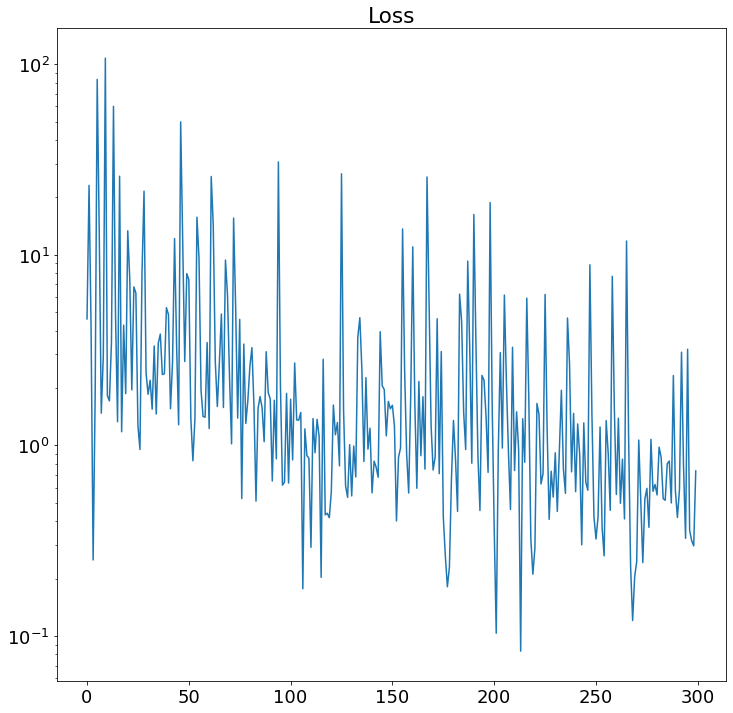

In [64]:
plt.plot(h['loss']); plt.yscale('log'); plt.title('Loss');

In [65]:
h = learning_loop(true_params, pert_params, 1e-4, 75, 5000)

  0%|          | 10/5000 [00:00<01:45, 47.43it/s]

Loss:  tensor(11.1259, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9358, grad_fn=<MeanBackward0>)
Loss:  tensor(17.8200, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6333, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1318, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7120, grad_fn=<MeanBackward0>)
Loss:  tensor(9.7968, grad_fn=<MeanBackward0>)
Loss:  tensor(21.1278, grad_fn=<MeanBackward0>)
Loss:  tensor(31.9581, grad_fn=<MeanBackward0>)
Loss:  tensor(19.5738, grad_fn=<MeanBackward0>)


  0%|          | 22/5000 [00:00<01:34, 52.84it/s]

Loss:  tensor(18.3966, grad_fn=<MeanBackward0>)
Loss:  tensor(15.4171, grad_fn=<MeanBackward0>)
Loss:  tensor(72.9362, grad_fn=<MeanBackward0>)
Loss:  tensor(8.7545, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4692, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5470, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0317, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1576, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1834, grad_fn=<MeanBackward0>)
Loss:  tensor(30.7549, grad_fn=<MeanBackward0>)
Loss:  tensor(97.3568, grad_fn=<MeanBackward0>)
Loss:  tensor(11.1136, grad_fn=<MeanBackward0>)


  1%|          | 28/5000 [00:00<01:37, 50.77it/s]

Loss:  tensor(132.3808, grad_fn=<MeanBackward0>)
Loss:  tensor(282.6032, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0422, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9444, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3876, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3258, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6942, grad_fn=<MeanBackward0>)
Loss:  tensor(16.9374, grad_fn=<MeanBackward0>)
Loss:  tensor(507.8724, grad_fn=<MeanBackward0>)
Loss:  tensor(9.1663, grad_fn=<MeanBackward0>)


  1%|          | 40/5000 [00:00<01:55, 43.01it/s]

Loss:  tensor(4.9910, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9842, grad_fn=<MeanBackward0>)
Loss:  tensor(21.6212, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3178, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7670, grad_fn=<MeanBackward0>)
Loss:  tensor(22.9756, grad_fn=<MeanBackward0>)
Loss:  tensor(9.3195, grad_fn=<MeanBackward0>)


  1%|          | 45/5000 [00:00<01:59, 41.41it/s]

Loss:  tensor(27.4809, grad_fn=<MeanBackward0>)
Loss:  tensor(247.3216, grad_fn=<MeanBackward0>)
Loss:  tensor(272.5744, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3554, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9844, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4261, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1336, grad_fn=<MeanBackward0>)
Loss:  tensor(22.2100, grad_fn=<MeanBackward0>)


  1%|          | 55/5000 [00:01<02:10, 37.80it/s]

Loss:  tensor(35.8074, grad_fn=<MeanBackward0>)
Loss:  tensor(33.0797, grad_fn=<MeanBackward0>)
Loss:  tensor(15.2028, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0253, grad_fn=<MeanBackward0>)
Loss:  tensor(54.0791, grad_fn=<MeanBackward0>)
Loss:  tensor(454.2617, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1858, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1177, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0028, grad_fn=<MeanBackward0>)


  1%|          | 60/5000 [00:01<02:06, 39.04it/s]

Loss:  tensor(27.1241, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7100, grad_fn=<MeanBackward0>)
Loss:  tensor(20.1770, grad_fn=<MeanBackward0>)
Loss:  tensor(24.3764, grad_fn=<MeanBackward0>)
Loss:  tensor(383.3757, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2544, grad_fn=<MeanBackward0>)
Loss:  tensor(547.9557, grad_fn=<MeanBackward0>)


  1%|▏         | 69/5000 [00:01<02:26, 33.58it/s]

Loss:  tensor(5.3693, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0378, grad_fn=<MeanBackward0>)
Loss:  tensor(15.1327, grad_fn=<MeanBackward0>)
Loss:  tensor(16.0383, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2600, grad_fn=<MeanBackward0>)
Loss:  tensor(148.1013, grad_fn=<MeanBackward0>)
Loss:  

  2%|▏         | 78/5000 [00:01<02:17, 35.84it/s]

tensor(460.9736, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0940, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9420, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3664, grad_fn=<MeanBackward0>)
Loss:  tensor(12.8258, grad_fn=<MeanBackward0>)
Loss:  tensor(21.4841, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0323, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3550, grad_fn=<MeanBackward0>)


  2%|▏         | 88/5000 [00:02<02:05, 39.22it/s]

Loss:  tensor(8.0722, grad_fn=<MeanBackward0>)
Loss:  tensor(74.6922, grad_fn=<MeanBackward0>)
Loss:  tensor(117.7721, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1314, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2065, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1509, grad_fn=<MeanBackward0>)
Loss:  tensor(42.8523, grad_fn=<MeanBackward0>)
Loss:  tensor(53.5279, grad_fn=<MeanBackward0>)
Loss:  tensor(6.9563, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3766, grad_fn=<MeanBackward0>)
Loss:  tensor(230.1574, grad_fn=<MeanBackward0>)


  2%|▏         | 94/5000 [00:02<02:06, 38.92it/s]

Loss:  tensor(33.0379, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4241, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1535, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4719, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6355, grad_fn=<MeanBackward0>)
Loss:  tensor(6.6369, grad_fn=<MeanBackward0>)


  2%|▏         | 99/5000 [00:02<02:27, 33.21it/s]

Loss:  tensor(1.5153, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6641, grad_fn=<MeanBackward0>)
Loss:  tensor(14.8936, grad_fn=<MeanBackward0>)
Loss:  tensor(258.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(36.7419, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0786, grad_fn=<MeanBackward0>)


  2%|▏         | 107/5000 [00:02<02:49, 28.87it/s]

Loss:  tensor(47.8439, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6421, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0967, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4702, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4897, grad_fn=<MeanBackward0>)


  2%|▏         | 111/5000 [00:03<02:44, 29.68it/s]

Loss:  tensor(102.1570, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0689, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4881, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4289, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2854, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4631, grad_fn=<MeanBackward0>)
Loss:  tensor(7.9393, grad_fn=<MeanBackward0>)


  2%|▏         | 119/5000 [00:03<02:38, 30.73it/s]

Loss:  tensor(0.3447, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4813, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8051, grad_fn=<MeanBackward0>)
Loss:  tensor(237.4514, grad_fn=<MeanBackward0>)
Loss:  tensor(16.7223, grad_fn=<MeanBackward0>)
Loss:  tensor(12.2046, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1160, grad_fn=<MeanBackward0>)


  3%|▎         | 127/5000 [00:03<02:30, 32.38it/s]

Loss:  tensor(3.7240, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7406, grad_fn=<MeanBackward0>)
Loss:  tensor(9.3566, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5212, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6020, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5602, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4038, grad_fn=<MeanBackward0>)


  3%|▎         | 135/5000 [00:03<02:26, 33.15it/s]

Loss:  tensor(0.4013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4848, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2414, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1784, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6405, grad_fn=<MeanBackward0>)
Loss:  tensor(35.5690, grad_fn=<MeanBackward0>)
Loss:  tensor(81.7488, grad_fn=<MeanBackward0>)
Loss:  tensor(178.1687, grad_fn=<MeanBackward0>)


  3%|▎         | 144/5000 [00:03<02:18, 35.07it/s]

Loss:  tensor(8.0874, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9382, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6874, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4092, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6108, grad_fn=<MeanBackward0>)
Loss:  tensor(6.6224, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7553, grad_fn=<MeanBackward0>)
Loss:  tensor(86.1734, grad_fn=<MeanBackward0>)


  3%|▎         | 148/5000 [00:04<02:22, 34.05it/s]

Loss:  tensor(3.9787, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6206, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3412, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2820, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6822, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6853, grad_fn=<MeanBackward0>)
Loss:  tensor(65.6925, grad_fn=<MeanBackward0>)


  3%|▎         | 156/5000 [00:04<02:16, 35.46it/s]

Loss:  tensor(16.3222, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0516, grad_fn=<MeanBackward0>)
Loss:  tensor(454.8944, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8365, grad_fn=<MeanBackward0>)
Loss:  tensor(12.7726, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7995, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3670, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2188, grad_fn=<MeanBackward0>)


  3%|▎         | 166/5000 [00:04<01:58, 40.72it/s]

Loss:  tensor(50.5924, grad_fn=<MeanBackward0>)
Loss:  tensor(39.3262, grad_fn=<MeanBackward0>)
Loss:  tensor(102.4995, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8653, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4743, grad_fn=<MeanBackward0>)
Loss:  tensor(10.1327, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6976, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7543, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1687, grad_fn=<MeanBackward0>)


  4%|▎         | 175/5000 [00:04<02:13, 36.06it/s]

Loss:  tensor(12.3181, grad_fn=<MeanBackward0>)
Loss:  tensor(28.7002, grad_fn=<MeanBackward0>)
Loss:  tensor(62.7258, grad_fn=<MeanBackward0>)
Loss:  tensor(26.0434, grad_fn=<MeanBackward0>)
Loss:  tensor(656.7631, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0713, grad_fn=<MeanBackward0>)
Loss:  tensor(75.0296, grad_fn=<MeanBackward0>)


  4%|▎         | 185/5000 [00:05<02:06, 38.18it/s]

Loss:  tensor(4.9574, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8168, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1874, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7128, grad_fn=<MeanBackward0>)
Loss:  tensor(12.6579, grad_fn=<MeanBackward0>)
Loss:  tensor(48.7619, grad_fn=<MeanBackward0>)
Loss:  tensor(36.0548, grad_fn=<MeanBackward0>)
Loss:  tensor(44.5951, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4243, grad_fn=<MeanBackward0>)


  4%|▍         | 196/5000 [00:05<01:48, 44.23it/s]

Loss:  tensor(694.4988, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9631, grad_fn=<MeanBackward0>)
Loss:  tensor(82.1354, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2128, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8007, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4927, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9826, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1282, grad_fn=<MeanBackward0>)
Loss:  tensor(177.4755, grad_fn=<MeanBackward0>)
Loss:  tensor(9.9976, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2491, grad_fn=<MeanBackward0>)


  4%|▍         | 201/5000 [00:05<01:59, 40.19it/s]

Loss:  tensor(1.1009, grad_fn=<MeanBackward0>)
Loss:  tensor(532.6988, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2745, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1550, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3342, grad_fn=<MeanBackward0>)
Loss:  tensor(35.1590, grad_fn=<MeanBackward0>)
Loss:  tensor(75.0281, grad_fn=<MeanBackward0>)


  4%|▍         | 210/5000 [00:05<02:15, 35.32it/s]

Loss:  tensor(192.7678, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2596, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4197, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9834, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2011, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3262, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0828, grad_fn=<MeanBackward0>)


  4%|▍         | 219/5000 [00:05<02:12, 36.12it/s]

Loss:  tensor(5.9199, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7274, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6011, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0792, grad_fn=<MeanBackward0>)
Loss:  tensor(827.4726, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5863, grad_fn=<MeanBackward0>)
Loss:  tensor(11.7217, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6549, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8319, grad_fn=<MeanBackward0>)


  5%|▍         | 228/5000 [00:06<02:06, 37.78it/s]

Loss:  tensor(3.1583, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9755, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3065, grad_fn=<MeanBackward0>)
Loss:  tensor(13.3125, grad_fn=<MeanBackward0>)
Loss:  tensor(587.0102, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7253, grad_fn=<MeanBackward0>)
Loss:  tensor(45.5986, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5560, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2776, grad_fn=<MeanBackward0>)


  5%|▍         | 237/5000 [00:06<02:02, 38.87it/s]

Loss:  tensor(2.2794, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2907, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6974, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1959, grad_fn=<MeanBackward0>)
Loss:  tensor(298.1137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5681, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3860, grad_fn=<MeanBackward0>)
Loss:  tensor(27.3149, grad_fn=<MeanBackward0>)
Loss:  

  5%|▍         | 242/5000 [00:06<01:53, 41.82it/s]

tensor(2.2882, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9879, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2660, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1534, grad_fn=<MeanBackward0>)
Loss:  tensor(43.1741, grad_fn=<MeanBackward0>)
Loss:  tensor(10.8985, grad_fn=<MeanBackward0>)
Loss:  tensor(19.9962, grad_fn=<MeanBackward0>)
Loss:  tensor(10.5715, grad_fn=<MeanBackward0>)


  5%|▌         | 251/5000 [00:06<02:11, 36.13it/s]

Loss:  tensor(11.5490, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4230, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4368, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0813, grad_fn=<MeanBackward0>)
Loss:  tensor(19.1723, grad_fn=<MeanBackward0>)
Loss:  tensor(26.8491, grad_fn=<MeanBackward0>)
Loss:  tensor(153.5457, grad_fn=<MeanBackward0>)


  5%|▌         | 259/5000 [00:07<02:18, 34.35it/s]

Loss:  tensor(11.0508, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4316, grad_fn=<MeanBackward0>)
Loss:  tensor(13.0934, grad_fn=<MeanBackward0>)
Loss:  tensor(14.2069, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0891, grad_fn=<MeanBackward0>)
Loss:  tensor(33.1046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5750, grad_fn=<MeanBackward0>)


  5%|▌         | 267/5000 [00:07<02:26, 32.31it/s]

Loss:  tensor(0.1577, grad_fn=<MeanBackward0>)
Loss:  tensor(20.1689, grad_fn=<MeanBackward0>)
Loss:  tensor(230.3378, grad_fn=<MeanBackward0>)
Loss:  tensor(22.1891, grad_fn=<MeanBackward0>)
Loss:  tensor(362.5787, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6957, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2811, grad_fn=<MeanBackward0>)


  5%|▌         | 271/5000 [00:07<02:41, 29.26it/s]

Loss:  tensor(111.0267, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9194, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6171, grad_fn=<MeanBackward0>)
Loss:  tensor(28.8562, grad_fn=<MeanBackward0>)
Loss:  tensor(42.4114, grad_fn=<MeanBackward0>)
Loss:  tensor(309.1761, grad_fn=<MeanBackward0>)


  6%|▌         | 278/5000 [00:07<02:59, 26.35it/s]

Loss:  tensor(9.5870, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7965, grad_fn=<MeanBackward0>)
Loss:  tensor(10.5191, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4679, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0030, grad_fn=<MeanBackward0>)
Loss:  

  6%|▌         | 285/5000 [00:08<02:41, 29.28it/s]

tensor(11.2197, grad_fn=<MeanBackward0>)
Loss:  tensor(31.6638, grad_fn=<MeanBackward0>)
Loss:  tensor(133.2805, grad_fn=<MeanBackward0>)
Loss:  tensor(208.4561, grad_fn=<MeanBackward0>)
Loss:  tensor(726.9280, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0135, grad_fn=<MeanBackward0>)


  6%|▌         | 290/5000 [00:08<02:27, 31.93it/s]

Loss:  tensor(23.3399, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6704, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5604, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4459, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3912, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6726, grad_fn=<MeanBackward0>)


  6%|▌         | 298/5000 [00:08<02:40, 29.30it/s]

Loss:  tensor(0.1381, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3272, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0796, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3482, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9583, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9750, grad_fn=<MeanBackward0>)
Loss:  tensor(91.5472, grad_fn=<MeanBackward0>)


  6%|▌         | 307/5000 [00:08<02:15, 34.74it/s]

Loss:  tensor(4.8551, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0720, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6350, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7393, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5368, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1655, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6603, grad_fn=<MeanBackward0>)
Loss:  tensor(16.1602, grad_fn=<MeanBackward0>)
Loss:  tensor(102.3143, grad_fn=<MeanBackward0>)


  6%|▌         | 311/5000 [00:08<02:20, 33.39it/s]

Loss:  tensor(8.8657, grad_fn=<MeanBackward0>)
Loss:  tensor(8.7691, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7279, grad_fn=<MeanBackward0>)
Loss:  tensor(11.4057, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3117, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4971, grad_fn=<MeanBackward0>)


  6%|▋         | 319/5000 [00:09<02:40, 29.20it/s]

Loss:  tensor(2.4186, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7840, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0282, grad_fn=<MeanBackward0>)
Loss:  tensor(33.4928, grad_fn=<MeanBackward0>)
Loss:  tensor(10.3454, grad_fn=<MeanBackward0>)
Loss:  tensor(11.5859, grad_fn=<MeanBackward0>)


  6%|▋         | 323/5000 [00:09<02:39, 29.34it/s]

Loss:  tensor(90.4652, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3219, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6517, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6246, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1298, grad_fn=<MeanBackward0>)
Loss:  

  7%|▋         | 331/5000 [00:09<02:39, 29.34it/s]

tensor(3.5899, grad_fn=<MeanBackward0>)
Loss:  tensor(11.6318, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5133, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3171, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0129, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6926, grad_fn=<MeanBackward0>)
Loss:  tensor(310.4366, grad_fn=<MeanBackward0>)


  7%|▋         | 335/5000 [00:09<02:32, 30.50it/s]

Loss:  tensor(3.6610, grad_fn=<MeanBackward0>)
Loss:  tensor(58.4708, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6670, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0794, grad_fn=<MeanBackward0>)
Loss:  tensor(8.9521, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4950, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2719, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8001, grad_fn=<MeanBackward0>)


  7%|▋         | 344/5000 [00:09<02:23, 32.45it/s]

Loss:  tensor(2.1237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1555, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8464, grad_fn=<MeanBackward0>)
Loss:  tensor(10.5690, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6430, grad_fn=<MeanBackward0>)


  7%|▋         | 352/5000 [00:10<02:17, 33.70it/s]

Loss:  tensor(4.0525, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8419, grad_fn=<MeanBackward0>)
Loss:  tensor(48.3568, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3537, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1221, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5733, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3470, grad_fn=<MeanBackward0>)
Loss:  tensor(14.7754, grad_fn=<MeanBackward0>)


  7%|▋         | 360/5000 [00:10<02:21, 32.75it/s]

Loss:  tensor(17.3516, grad_fn=<MeanBackward0>)
Loss:  tensor(77.0486, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3411, grad_fn=<MeanBackward0>)
Loss:  tensor(534.6669, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4753, grad_fn=<MeanBackward0>)


  7%|▋         | 369/5000 [00:10<02:03, 37.36it/s]

Loss:  tensor(0.1618, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5300, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1780, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6493, grad_fn=<MeanBackward0>)
Loss:  tensor(28.8877, grad_fn=<MeanBackward0>)
Loss:  tensor(47.1750, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0928, grad_fn=<MeanBackward0>)
Loss:  tensor(36.4143, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2559, grad_fn=<MeanBackward0>)


  7%|▋         | 374/5000 [00:10<01:53, 40.70it/s]

Loss:  tensor(6.8334, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8651, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3687, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6950, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1337, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7735, grad_fn=<MeanBackward0>)
Loss:  tensor(19.6997, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8356, grad_fn=<MeanBackward0>)


  8%|▊         | 383/5000 [00:11<02:12, 34.96it/s]

Loss:  tensor(10.8226, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5442, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1178, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2910, grad_fn=<MeanBackward0>)
Loss:  tensor(314.1105, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1655, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8891, grad_fn=<MeanBackward0>)


  8%|▊         | 391/5000 [00:11<02:19, 33.06it/s]

Loss:  tensor(0.6816, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6380, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6640, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9553, grad_fn=<MeanBackward0>)


  8%|▊         | 400/5000 [00:11<02:02, 37.70it/s]

Loss:  tensor(9.4172, grad_fn=<MeanBackward0>)
Loss:  tensor(17.9999, grad_fn=<MeanBackward0>)
Loss:  tensor(74.5775, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6972, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5337, grad_fn=<MeanBackward0>)
Loss:  tensor(251.3086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4791, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3684, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0283, grad_fn=<MeanBackward0>)
Loss:  

  8%|▊         | 411/5000 [00:11<01:43, 44.53it/s]

tensor(2.2582, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5138, grad_fn=<MeanBackward0>)
Loss:  tensor(8.5895, grad_fn=<MeanBackward0>)
Loss:  tensor(20.7817, grad_fn=<MeanBackward0>)
Loss:  tensor(11.9049, grad_fn=<MeanBackward0>)
Loss:  tensor(247.1713, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2321, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2818, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2117, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3474, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9067, grad_fn=<MeanBackward0>)


  8%|▊         | 423/5000 [00:11<01:32, 49.53it/s]

Loss:  tensor(2.7538, grad_fn=<MeanBackward0>)
Loss:  tensor(26.6077, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8939, grad_fn=<MeanBackward0>)
Loss:  tensor(16.9549, grad_fn=<MeanBackward0>)
Loss:  tensor(415.4834, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9131, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4537, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6267, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8723, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2157, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3248, grad_fn=<MeanBackward0>)
Loss:  

  9%|▊         | 434/5000 [00:12<01:29, 51.04it/s]

tensor(1.1977, grad_fn=<MeanBackward0>)
Loss:  tensor(919.2510, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4509, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7780, grad_fn=<MeanBackward0>)
Loss:  tensor(8.1871, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1826, grad_fn=<MeanBackward0>)
Loss:  tensor(20.6602, grad_fn=<MeanBackward0>)
Loss:  tensor(30.6846, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1042, grad_fn=<MeanBackward0>)


  9%|▉         | 446/5000 [00:12<01:25, 53.25it/s]

Loss:  tensor(4.6470, grad_fn=<MeanBackward0>)
Loss:  tensor(57.4425, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0592, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0619, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0946, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4150, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8385, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6668, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7869, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0571, grad_fn=<MeanBackward0>)
Loss:  tensor(137.1474, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9238, grad_fn=<MeanBackward0>)


  9%|▉         | 452/5000 [00:12<01:25, 53.24it/s]

Loss:  tensor(658.1965, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3278, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1309, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1481, grad_fn=<MeanBackward0>)
Loss:  tensor(11.6414, grad_fn=<MeanBackward0>)
Loss:  tensor(41.8757, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3872, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0692, grad_fn=<MeanBackward0>)
Loss:  tensor(847.8022, grad_fn=<MeanBackward0>)


  9%|▉         | 463/5000 [00:12<01:47, 42.05it/s]

Loss:  tensor(0.0914, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0404, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1066, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6778, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9941, grad_fn=<MeanBackward0>)
Loss:  tensor(869.6540, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3318, grad_fn=<MeanBackward0>)


  9%|▉         | 468/5000 [00:12<02:02, 37.06it/s]

Loss:  tensor(0.4883, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0303, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3809, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6972, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6290, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3905, grad_fn=<MeanBackward0>)
Loss:  tensor(183.1729, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4543, grad_fn=<MeanBackward0>)


 10%|▉         | 478/5000 [00:13<01:50, 40.98it/s]

Loss:  tensor(74.7644, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5560, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0735, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9456, grad_fn=<MeanBackward0>)
Loss:  tensor(9.8542, grad_fn=<MeanBackward0>)
Loss:  tensor(12.9021, grad_fn=<MeanBackward0>)
Loss:  tensor(128.0895, grad_fn=<MeanBackward0>)
Loss:  tensor(10.3410, grad_fn=<MeanBackward0>)
Loss:  tensor(25.4115, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4938, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8408, grad_fn=<MeanBackward0>)


 10%|▉         | 489/5000 [00:13<01:40, 44.91it/s]

Loss:  tensor(5.1645, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8081, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2344, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0581, grad_fn=<MeanBackward0>)
Loss:  tensor(70.9834, grad_fn=<MeanBackward0>)
Loss:  tensor(29.5216, grad_fn=<MeanBackward0>)
Loss:  tensor(123.7683, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7943, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2391, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0069, grad_fn=<MeanBackward0>)
Loss:  

 10%|█         | 500/5000 [00:13<01:35, 47.00it/s]

tensor(203.1332, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9279, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9110, grad_fn=<MeanBackward0>)
Loss:  tensor(6.9245, grad_fn=<MeanBackward0>)
Loss:  tensor(97.6996, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1993, grad_fn=<MeanBackward0>)
Loss:  tensor(10.5181, grad_fn=<MeanBackward0>)
Loss:  tensor(9.1269, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1834, grad_fn=<MeanBackward0>)
Loss:  tensor(18.9464, grad_fn=<MeanBackward0>)


 10%|█         | 510/5000 [00:13<01:39, 45.26it/s]

Loss:  tensor(2.1705, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0845, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0324, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2831, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4164, grad_fn=<MeanBackward0>)
Loss:  tensor(125.9386, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4871, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2138, grad_fn=<MeanBackward0>)
Loss:  tensor(343.2520, grad_fn=<MeanBackward0>)


 10%|█         | 521/5000 [00:14<01:35, 46.77it/s]

Loss:  tensor(2.3762, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3521, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4455, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7408, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4180, grad_fn=<MeanBackward0>)
Loss:  tensor(34.0584, grad_fn=<MeanBackward0>)
Loss:  tensor(366.1483, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3421, grad_fn=<MeanBackward0>)
Loss:  tensor(662.1424, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8972, grad_fn=<MeanBackward0>)


 11%|█         | 533/5000 [00:14<01:27, 51.22it/s]

Loss:  tensor(0.1674, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8460, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1264, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2540, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8101, grad_fn=<MeanBackward0>)
Loss:  tensor(14.1902, grad_fn=<MeanBackward0>)
Loss:  tensor(8.6413, grad_fn=<MeanBackward0>)
Loss:  tensor(49.3420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4612, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1419, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3263, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7673, grad_fn=<MeanBackward0>)


 11%|█         | 545/5000 [00:14<01:24, 52.74it/s]

Loss:  tensor(0.3882, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2898, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2524, grad_fn=<MeanBackward0>)
Loss:  tensor(20.3999, grad_fn=<MeanBackward0>)
Loss:  tensor(40.4916, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6519, grad_fn=<MeanBackward0>)
Loss:  tensor(505.8417, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5810, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8150, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4006, grad_fn=<MeanBackward0>)


 11%|█         | 551/5000 [00:14<01:25, 52.16it/s]

Loss:  tensor(9.9577, grad_fn=<MeanBackward0>)
Loss:  tensor(13.5486, grad_fn=<MeanBackward0>)
Loss:  tensor(136.1809, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6526, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2394, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3878, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5042, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6046, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9056, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7291, grad_fn=<MeanBackward0>)


 11%|█▏        | 563/5000 [00:14<01:30, 48.90it/s]

Loss:  tensor(2.8523, grad_fn=<MeanBackward0>)
Loss:  tensor(48.8035, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2879, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4986, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2162, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2593, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6034, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0631, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1362, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3335, grad_fn=<MeanBackward0>)


 12%|█▏        | 575/5000 [00:15<01:32, 47.72it/s]

Loss:  tensor(7.0155, grad_fn=<MeanBackward0>)
Loss:  tensor(11.1350, grad_fn=<MeanBackward0>)
Loss:  tensor(66.2585, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9915, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9593, grad_fn=<MeanBackward0>)
Loss:  tensor(730.3554, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1700, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8565, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9769, grad_fn=<MeanBackward0>)


 12%|█▏        | 580/5000 [00:15<01:44, 42.10it/s]

Loss:  tensor(2.4680, grad_fn=<MeanBackward0>)
Loss:  tensor(11.4708, grad_fn=<MeanBackward0>)
Loss:  tensor(10.8844, grad_fn=<MeanBackward0>)
Loss:  tensor(200.3261, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6419, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2026, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0669, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7839, grad_fn=<MeanBackward0>)


 12%|█▏        | 589/5000 [00:15<01:57, 37.65it/s]

Loss:  tensor(1.0493, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4883, grad_fn=<MeanBackward0>)
Loss:  tensor(72.6202, grad_fn=<MeanBackward0>)
Loss:  tensor(39.5890, grad_fn=<MeanBackward0>)
Loss:  tensor(361.0482, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0841, grad_fn=<MeanBackward0>)
Loss:  tensor(19.3829, grad_fn=<MeanBackward0>)
Loss:  tensor(9.6949, grad_fn=<MeanBackward0>)


 12%|█▏        | 599/5000 [00:15<01:52, 39.16it/s]

Loss:  tensor(1.8748, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6636, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5619, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4678, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5005, grad_fn=<MeanBackward0>)
Loss:  tensor(16.0242, grad_fn=<MeanBackward0>)
Loss:  tensor(24.0438, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5390, grad_fn=<MeanBackward0>)


 12%|█▏        | 604/5000 [00:15<02:06, 34.63it/s]

Loss:  tensor(255.7103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8178, grad_fn=<MeanBackward0>)
Loss:  tensor(117.8314, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4611, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1422, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4862, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6690, grad_fn=<MeanBackward0>)


 12%|█▏        | 612/5000 [00:16<02:15, 32.37it/s]

Loss:  tensor(3.3267, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0862, grad_fn=<MeanBackward0>)
Loss:  tensor(204.4988, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7336, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0606, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1393, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2910, grad_fn=<MeanBackward0>)

 12%|█▏        | 616/5000 [00:16<02:16, 32.22it/s]


Loss:  tensor(1.3436, grad_fn=<MeanBackward0>)
Loss:  tensor(11.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(177.1641, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2522, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9016, grad_fn=<MeanBackward0>)


 12%|█▏        | 624/5000 [00:16<02:12, 33.06it/s]

Loss:  tensor(0.3801, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5271, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3353, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3244, grad_fn=<MeanBackward0>)
Loss:  tensor(25.3690, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2846, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3471, grad_fn=<MeanBackward0>)
Loss:  tensor(634.4820, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2581, grad_fn=<MeanBackward0>)


 13%|█▎        | 633/5000 [00:16<02:10, 33.52it/s]

Loss:  tensor(0.0236, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2092, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7032, grad_fn=<MeanBackward0>)
Loss:  tensor(18.3710, grad_fn=<MeanBackward0>)


 13%|█▎        | 637/5000 [00:17<02:28, 29.37it/s]

Loss:  tensor(1.3700, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7396, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1847, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1204, grad_fn=<MeanBackward0>)
Loss:  tensor(12.3255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2706, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2670, grad_fn=<MeanBackward0>)
Loss:  

 13%|█▎        | 646/5000 [00:17<02:15, 32.21it/s]

tensor(4.0476, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1685, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7593, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3531, grad_fn=<MeanBackward0>)
Loss:  tensor(167.9599, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1155, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1964, grad_fn=<MeanBackward0>)


 13%|█▎        | 654/5000 [00:17<02:16, 31.83it/s]

Loss:  tensor(0.0944, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4158, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0441, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0346, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0541, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5705, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1105, grad_fn=<MeanBackward0>)


 13%|█▎        | 658/5000 [00:17<02:25, 29.83it/s]

Loss:  tensor(0.5696, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6464, grad_fn=<MeanBackward0>)
Loss:  tensor(10.1703, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1915, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2467, grad_fn=<MeanBackward0>)


 13%|█▎        | 666/5000 [00:17<02:21, 30.62it/s]

Loss:  tensor(5.6558, grad_fn=<MeanBackward0>)
Loss:  tensor(14.0764, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5934, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5008, grad_fn=<MeanBackward0>)
Loss:  tensor(9.6299, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6248, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5859, grad_fn=<MeanBackward0>)


 13%|█▎        | 670/5000 [00:18<02:31, 28.67it/s]

Loss:  tensor(0.2943, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5831, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9412, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7937, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0474, grad_fn=<MeanBackward0>)
Loss:  

 14%|█▎        | 678/5000 [00:18<02:21, 30.64it/s]

tensor(7.3774, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2820, grad_fn=<MeanBackward0>)
Loss:  tensor(8.3929, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7269, grad_fn=<MeanBackward0>)
Loss:  tensor(452.5125, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2102, grad_fn=<MeanBackward0>)
Loss:  

 14%|█▎        | 687/5000 [00:18<02:00, 35.78it/s]

tensor(0.0779, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5816, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2770, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0592, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1702, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2777, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6401, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7155, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0842, grad_fn=<MeanBackward0>)


 14%|█▍        | 695/5000 [00:18<02:16, 31.43it/s]

Loss:  tensor(1.2942, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0668, grad_fn=<MeanBackward0>)
Loss:  tensor(231.3201, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2362, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1110, grad_fn=<MeanBackward0>)


 14%|█▍        | 704/5000 [00:19<02:00, 35.56it/s]

Loss:  tensor(0.1166, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9101, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1982, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4519, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8939, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5793, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2431, grad_fn=<MeanBackward0>)
Loss:  tensor(1121.9987, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6544, grad_fn=<MeanBackward0>)


 14%|█▍        | 712/5000 [00:19<02:01, 35.16it/s]

Loss:  tensor(0.1228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1813, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7545, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1487, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1565, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7650, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2133, grad_fn=<MeanBackward0>)
Loss:  tensor(73.2743, grad_fn=<MeanBackward0>)


 14%|█▍        | 721/5000 [00:19<01:52, 37.89it/s]

Loss:  tensor(0.6197, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3419, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4105, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2584, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0900, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2675, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9546, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1807, grad_fn=<MeanBackward0>)


 15%|█▍        | 732/5000 [00:19<01:34, 45.24it/s]

Loss:  tensor(31.2575, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2662, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0495, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2758, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3640, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1231, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1400, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4644, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2139, grad_fn=<MeanBackward0>)
Loss:  tensor(472.5056, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9270, grad_fn=<MeanBackward0>)


 15%|█▍        | 743/5000 [00:19<01:29, 47.53it/s]

Loss:  tensor(6.3729, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2734, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1541, grad_fn=<MeanBackward0>)
Loss:  tensor(7.9128, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4285, grad_fn=<MeanBackward0>)
Loss:  tensor(89.3702, grad_fn=<MeanBackward0>)
Loss:  tensor(63.8034, grad_fn=<MeanBackward0>)
Loss:  tensor(911.2975, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4929, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8757, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5275, grad_fn=<MeanBackward0>)


 15%|█▍        | 748/5000 [00:20<01:36, 44.00it/s]

Loss:  tensor(1.7333, grad_fn=<MeanBackward0>)
Loss:  tensor(930.2441, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5148, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3403, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6668, grad_fn=<MeanBackward0>)
Loss:  

 15%|█▌        | 758/5000 [00:20<01:46, 39.80it/s]

tensor(0.8351, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3912, grad_fn=<MeanBackward0>)
Loss:  tensor(13.0487, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8648, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4329, grad_fn=<MeanBackward0>)
Loss:  tensor(11.2871, grad_fn=<MeanBackward0>)
Loss:  tensor(23.8115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7730, grad_fn=<MeanBackward0>)


 15%|█▌        | 763/5000 [00:20<01:45, 40.27it/s]

Loss:  tensor(0.1949, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0528, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2041, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4640, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2343, grad_fn=<MeanBackward0>)
Loss:  tensor(293.5309, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4641, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4799, grad_fn=<MeanBackward0>)


 15%|█▌        | 773/5000 [00:20<01:43, 40.65it/s]

Loss:  tensor(1.1374, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6194, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2476, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4348, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6895, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4080, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3387, grad_fn=<MeanBackward0>)


 16%|█▌        | 784/5000 [00:21<01:42, 41.12it/s]

Loss:  tensor(1.1056, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4141, grad_fn=<MeanBackward0>)
Loss:  tensor(46.4848, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9908, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5011, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7424, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7781, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3332, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8071, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1532, grad_fn=<MeanBackward0>)


 16%|█▌        | 790/5000 [00:21<01:35, 44.29it/s]

Loss:  tensor(1.3282, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8487, grad_fn=<MeanBackward0>)
Loss:  tensor(10.5650, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6991, grad_fn=<MeanBackward0>)
Loss:  tensor(115.3210, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3580, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8100, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4629, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0326, grad_fn=<MeanBackward0>)


 16%|█▌        | 800/5000 [00:21<01:54, 36.59it/s]

Loss:  tensor(0.1643, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6062, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1277, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5421, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8334, grad_fn=<MeanBackward0>)
Loss:  tensor(23.5408, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0439, grad_fn=<MeanBackward0>)


 16%|█▌        | 809/5000 [00:21<01:48, 38.76it/s]

Loss:  tensor(0.1599, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1848, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7398, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2487, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5867, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5731, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3931, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4996, grad_fn=<MeanBackward0>)


 16%|█▋        | 813/5000 [00:21<01:57, 35.54it/s]

Loss:  tensor(0.8951, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0319, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3475, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0653, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5628, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4358, grad_fn=<MeanBackward0>)


 16%|█▋        | 821/5000 [00:22<02:02, 34.22it/s]

Loss:  tensor(0.3141, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9076, grad_fn=<MeanBackward0>)
Loss:  tensor(18.6401, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3070, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2944, grad_fn=<MeanBackward0>)
Loss:  tensor(9.7521, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0729, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0673, grad_fn=<MeanBackward0>)


 17%|█▋        | 831/5000 [00:22<01:55, 35.96it/s]

Loss:  tensor(0.6707, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4339, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0248, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1302, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1332, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8399, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8546, grad_fn=<MeanBackward0>)


 17%|█▋        | 839/5000 [00:22<01:53, 36.51it/s]

Loss:  tensor(3.6631, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1197, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4177, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3939, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2586, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4227, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6821, grad_fn=<MeanBackward0>)


 17%|█▋        | 850/5000 [00:22<01:34, 43.75it/s]

Loss:  tensor(5.1551, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2896, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8654, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0895, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4374, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3754, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2249, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6491, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5089, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2334, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3958, grad_fn=<MeanBackward0>)


 17%|█▋        | 855/5000 [00:22<01:33, 44.39it/s]

Loss:  tensor(1.7398, grad_fn=<MeanBackward0>)
Loss:  tensor(12.7013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0121, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1215, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4734, grad_fn=<MeanBackward0>)
Loss:  tensor(286.0427, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3718, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0701, grad_fn=<MeanBackward0>)
Loss:  

 17%|█▋        | 866/5000 [00:23<01:27, 47.06it/s]

tensor(0.0412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6609, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4808, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2533, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9688, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3905, grad_fn=<MeanBackward0>)
Loss:  tensor(10.4600, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0428, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2171, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0246, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1092, grad_fn=<MeanBackward0>)


 18%|█▊        | 878/5000 [00:23<01:25, 48.04it/s]

Loss:  tensor(0.0953, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3545, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1934, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7976, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6405, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1863, grad_fn=<MeanBackward0>)
Loss:  tensor(6.6831, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5806, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0918, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0310, grad_fn=<MeanBackward0>)


 18%|█▊        | 889/5000 [00:23<01:27, 46.94it/s]

Loss:  tensor(0.0338, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3514, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1856, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5845, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6550, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1558, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0392, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0450, grad_fn=<MeanBackward0>)


 18%|█▊        | 894/5000 [00:23<01:27, 47.15it/s]

Loss:  tensor(3.4730, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6250, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4604, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1808, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)


 18%|█▊        | 904/5000 [00:24<01:47, 38.17it/s]

Loss:  tensor(4.8141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2836, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7835, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1981, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2494, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7968, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1583, grad_fn=<MeanBackward0>)


 18%|█▊        | 916/5000 [00:24<01:29, 45.50it/s]

Loss:  tensor(0.0944, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0733, grad_fn=<MeanBackward0>)
Loss:  tensor(66.5147, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0764, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8251, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2054, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4115, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0531, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1767, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0581, grad_fn=<MeanBackward0>)


 18%|█▊        | 922/5000 [00:24<01:26, 47.39it/s]

Loss:  tensor(0.4133, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2664, grad_fn=<MeanBackward0>)
Loss:  tensor(26.6723, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2612, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0419, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6214, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7453, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2327, grad_fn=<MeanBackward0>)


 19%|█▊        | 932/5000 [00:24<01:35, 42.49it/s]

Loss:  tensor(43.0435, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0159, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0988, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2136, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2213, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3760, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0716, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2973, grad_fn=<MeanBackward0>)


 19%|█▉        | 942/5000 [00:24<01:42, 39.63it/s]

Loss:  tensor(0.0810, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0344, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0418, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1616, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7127, grad_fn=<MeanBackward0>)


 19%|█▉        | 947/5000 [00:24<01:41, 40.09it/s]

Loss:  tensor(0.1647, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7302, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3132, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2473, grad_fn=<MeanBackward0>)
Loss:  tensor(54.9075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1945, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1258, grad_fn=<MeanBackward0>)


 19%|█▉        | 957/5000 [00:25<01:45, 38.18it/s]

Loss:  tensor(0.1181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1700, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0646, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2766, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1646, grad_fn=<MeanBackward0>)


 19%|█▉        | 968/5000 [00:25<01:45, 38.35it/s]

Loss:  tensor(4.3587, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0886, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1952, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0400, grad_fn=<MeanBackward0>)
Loss:  tensor(37.0963, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0795, grad_fn=<MeanBackward0>)


 20%|█▉        | 980/5000 [00:25<01:27, 46.08it/s]

Loss:  tensor(0.1345, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4969, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1630, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3407, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7867, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4998, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8524, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0748, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1476, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5267, grad_fn=<MeanBackward0>)


 20%|█▉        | 985/5000 [00:25<01:26, 46.39it/s]

Loss:  tensor(0.1088, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8870, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2614, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2164, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0712, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0659, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1743, grad_fn=<MeanBackward0>)


 20%|█▉        | 995/5000 [00:26<01:50, 36.13it/s]

Loss:  tensor(0.9253, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1826, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4996, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9920, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2819, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7971, grad_fn=<MeanBackward0>)


 20%|█▉        | 999/5000 [00:26<01:57, 33.91it/s]

Loss:  tensor(0.1483, grad_fn=<MeanBackward0>)
Loss:  tensor(95.3326, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2307, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1703, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0685, grad_fn=<MeanBackward0>)


 20%|██        | 1003/5000 [00:26<02:02, 32.74it/s]

Loss:  tensor(0.4967, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0930, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1758, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0845, grad_fn=<MeanBackward0>)


 20%|██        | 1010/5000 [00:26<02:36, 25.50it/s]

Loss:  tensor(0.0192, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2289, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2199, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6368, grad_fn=<MeanBackward0>)


 20%|██        | 1016/5000 [00:27<02:30, 26.42it/s]

Loss:  tensor(0.0471, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0508, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3626, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0510, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1235, grad_fn=<MeanBackward0>)
Loss:  

 20%|██        | 1022/5000 [00:27<02:30, 26.37it/s]

tensor(0.2375, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2224, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1847, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3774, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5684, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1538, grad_fn=<MeanBackward0>)


 20%|██        | 1025/5000 [00:27<02:38, 25.15it/s]

Loss:  tensor(0.2948, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1446, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1603, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2289, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4046, grad_fn=<MeanBackward0>)


 21%|██        | 1031/5000 [00:27<02:33, 25.84it/s]

Loss:  tensor(0.1732, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1381, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0624, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0657, grad_fn=<MeanBackward0>)


 21%|██        | 1038/5000 [00:27<02:31, 26.22it/s]

Loss:  tensor(0.4217, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5981, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0441, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0885, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6801, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0529, grad_fn=<MeanBackward0>)


 21%|██        | 1044/5000 [00:28<02:32, 25.92it/s]

Loss:  tensor(0.2006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1966, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1855, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3873, grad_fn=<MeanBackward0>)


 21%|██        | 1047/5000 [00:28<02:31, 26.16it/s]

Loss:  tensor(11.1544, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0133, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1375, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1257, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3733, grad_fn=<MeanBackward0>)


 21%|██        | 1053/5000 [00:28<02:38, 24.97it/s]

Loss:  tensor(0.0993, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6413, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0767, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9824, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3691, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6311, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4959, grad_fn=<MeanBackward0>)


 21%|██        | 1060/5000 [00:28<02:23, 27.48it/s]

Loss:  tensor(11.1035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1338, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0778, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7491, grad_fn=<MeanBackward0>)


 21%|██▏       | 1067/5000 [00:28<02:22, 27.66it/s]

Loss:  tensor(0.1009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4644, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9395, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9329, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2368, grad_fn=<MeanBackward0>)
Loss:  tensor(22.9099, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)


 21%|██▏       | 1073/5000 [00:29<02:35, 25.22it/s]

Loss:  tensor(0.1431, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5272, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0744, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1828, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6799, grad_fn=<MeanBackward0>)


 22%|██▏       | 1084/5000 [00:29<01:45, 37.19it/s]

Loss:  tensor(0.2561, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0264, grad_fn=<MeanBackward0>)
Loss:  tensor(89.9355, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4933, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0418, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5990, grad_fn=<MeanBackward0>)
Loss:  tensor(14.6880, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0472, grad_fn=<MeanBackward0>)
Loss:  tensor(88.2397, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4558, grad_fn=<MeanBackward0>)


 22%|██▏       | 1090/5000 [00:29<01:34, 41.55it/s]

Loss:  tensor(21.9320, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5395, grad_fn=<MeanBackward0>)
Loss:  tensor(34.4506, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3856, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8227, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6795, grad_fn=<MeanBackward0>)
Loss:  tensor(12.9522, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9842, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7120, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3773, grad_fn=<MeanBackward0>)
Loss:  

 22%|██▏       | 1096/5000 [00:29<01:26, 45.14it/s]

tensor(1.3940, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6988, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3938, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5688, grad_fn=<MeanBackward0>)


 22%|██▏       | 1105/5000 [00:30<01:54, 34.02it/s]

Loss:  tensor(0.4600, grad_fn=<MeanBackward0>)
Loss:  tensor(19.4727, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4955, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1824, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0108, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0987, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6022, grad_fn=<MeanBackward0>)


 22%|██▏       | 1113/5000 [00:30<01:58, 32.72it/s]

Loss:  tensor(0.5012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2772, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8296, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8582, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1346, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0267, grad_fn=<MeanBackward0>)


 22%|██▏       | 1122/5000 [00:30<01:49, 35.27it/s]

Loss:  tensor(0.3276, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5753, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6905, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1681, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5444, grad_fn=<MeanBackward0>)
Loss:  tensor(287.3659, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7349, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6590, grad_fn=<MeanBackward0>)


 23%|██▎       | 1128/5000 [00:30<01:39, 39.07it/s]

Loss:  tensor(2.4596, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7691, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1783, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9044, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0088, grad_fn=<MeanBackward0>)
Loss:  tensor(30.6600, grad_fn=<MeanBackward0>)
Loss:  tensor(539.3384, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2655, grad_fn=<MeanBackward0>)


 23%|██▎       | 1136/5000 [00:30<01:45, 36.59it/s]

Loss:  tensor(2.9883, grad_fn=<MeanBackward0>)
Loss:  tensor(306.6141, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3148, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1554, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7127, grad_fn=<MeanBackward0>)


 23%|██▎       | 1144/5000 [00:31<02:01, 31.74it/s]

Loss:  tensor(100.0215, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1965, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1199, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5897, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1158, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)


 23%|██▎       | 1148/5000 [00:31<02:07, 30.18it/s]

Loss:  tensor(0.0495, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0623, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0407, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1364, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0193, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0872, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0903, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0877, grad_fn=<MeanBackward0>)

 23%|██▎       | 1156/5000 [00:31<02:02, 31.30it/s]


Loss:  tensor(0.2419, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1768, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1492, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0334, grad_fn=<MeanBackward0>)


 23%|██▎       | 1164/5000 [00:31<02:02, 31.21it/s]

Loss:  tensor(1.0837, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0957, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6235, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0996, grad_fn=<MeanBackward0>)
Loss:  tensor(276.8857, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2396, grad_fn=<MeanBackward0>)


 23%|██▎       | 1168/5000 [00:31<02:07, 30.05it/s]

Loss:  tensor(0.5361, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7164, grad_fn=<MeanBackward0>)
Loss:  tensor(12.0188, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7573, grad_fn=<MeanBackward0>)
Loss:  tensor(64.9273, grad_fn=<MeanBackward0>)


 24%|██▎       | 1175/5000 [00:32<02:22, 26.89it/s]

Loss:  tensor(0.0754, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8162, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0507, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0663, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0671, grad_fn=<MeanBackward0>)


 24%|██▎       | 1182/5000 [00:32<02:11, 28.96it/s]

Loss:  tensor(0.1858, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0270, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2482, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0715, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0207, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0883, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0940, grad_fn=<MeanBackward0>)


 24%|██▎       | 1186/5000 [00:32<02:10, 29.22it/s]

Loss:  tensor(0.0844, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0573, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1399, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1905, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0917, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2117, grad_fn=<MeanBackward0>)


 24%|██▍       | 1195/5000 [00:32<01:49, 34.60it/s]

Loss:  tensor(0.0540, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1105, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0434, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7151, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8529, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6114, grad_fn=<MeanBackward0>)


 24%|██▍       | 1206/5000 [00:33<01:30, 42.11it/s]

Loss:  tensor(12.1923, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2555, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1559, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4125, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2335, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1428, grad_fn=<MeanBackward0>)
Loss:  tensor(13.9713, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3949, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9274, grad_fn=<MeanBackward0>)
Loss:  tensor(41.5119, grad_fn=<MeanBackward0>)


 24%|██▍       | 1217/5000 [00:33<01:23, 45.30it/s]

Loss:  tensor(1.4116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0358, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2869, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5626, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6951, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5180, grad_fn=<MeanBackward0>)
Loss:  tensor(6.5255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5184, grad_fn=<MeanBackward0>)
Loss:  tensor(13.4269, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0717, grad_fn=<MeanBackward0>)


 25%|██▍       | 1228/5000 [00:33<01:17, 48.55it/s]

Loss:  tensor(0.3654, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3384, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9009, grad_fn=<MeanBackward0>)
Loss:  tensor(8.6281, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3232, grad_fn=<MeanBackward0>)
Loss:  tensor(24.5949, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1831, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9363, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0959, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0824, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0392, grad_fn=<MeanBackward0>)


 25%|██▍       | 1240/5000 [00:33<01:15, 49.87it/s]

Loss:  tensor(0.0966, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2386, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1432, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0675, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0788, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0595, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0415, grad_fn=<MeanBackward0>)


 25%|██▌       | 1252/5000 [00:33<01:14, 50.56it/s]

Loss:  tensor(0.4340, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4480, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0414, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2119, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1634, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0425, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0289, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3481, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3567, grad_fn=<MeanBackward0>)


 25%|██▌       | 1264/5000 [00:34<01:13, 50.72it/s]

Loss:  tensor(1.7022, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5435, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0982, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1396, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0774, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0247, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0702, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3277, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5446, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2739, grad_fn=<MeanBackward0>)
Loss:  

 25%|██▌       | 1270/5000 [00:34<01:19, 46.92it/s]

tensor(0.3353, grad_fn=<MeanBackward0>)
Loss:  tensor(31.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1232, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6846, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3506, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1806, grad_fn=<MeanBackward0>)


 26%|██▌       | 1275/5000 [00:34<01:34, 39.54it/s]

Loss:  tensor(0.7239, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6270, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6188, grad_fn=<MeanBackward0>)
Loss:  tensor(109.1158, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5120, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0712, grad_fn=<MeanBackward0>)


 26%|██▌       | 1284/5000 [00:34<01:51, 33.39it/s]

Loss:  tensor(0.0721, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0380, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0232, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9724, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6640, grad_fn=<MeanBackward0>)
Loss:  tensor(24.1763, grad_fn=<MeanBackward0>)


 26%|██▌       | 1288/5000 [00:34<01:55, 32.10it/s]

Loss:  tensor(0.1004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0276, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3765, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0756, grad_fn=<MeanBackward0>)
Loss:  tensor(522.3389, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4817, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)


 26%|██▌       | 1296/5000 [00:35<01:54, 32.38it/s]

Loss:  tensor(0.0697, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1680, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3743, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2496, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2516, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1931, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2996, grad_fn=<MeanBackward0>)


 26%|██▌       | 1304/5000 [00:35<02:01, 30.54it/s]

Loss:  tensor(0.0565, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1222, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2604, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2783, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1125, grad_fn=<MeanBackward0>)


 26%|██▌       | 1308/5000 [00:35<02:03, 29.78it/s]

Loss:  tensor(0.3747, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3500, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2716, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0470, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9986, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0637, grad_fn=<MeanBackward0>)


 26%|██▋       | 1315/5000 [00:35<02:17, 26.75it/s]

Loss:  tensor(0.2542, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2368, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0294, grad_fn=<MeanBackward0>)
Loss:  tensor(217.4063, grad_fn=<MeanBackward0>)
Loss:  tensor(8.3256, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2509, grad_fn=<MeanBackward0>)


 26%|██▋       | 1322/5000 [00:36<02:08, 28.54it/s]

Loss:  tensor(2.2827, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3805, grad_fn=<MeanBackward0>)
Loss:  tensor(112.6051, grad_fn=<MeanBackward0>)
Loss:  tensor(6.9867, grad_fn=<MeanBackward0>)
Loss:  tensor(737.5847, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2302, grad_fn=<MeanBackward0>)
Loss:  tensor(15.8161, grad_fn=<MeanBackward0>)


 27%|██▋       | 1329/5000 [00:36<01:59, 30.79it/s]

Loss:  tensor(13.1820, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2094, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4627, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0514, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8841, grad_fn=<MeanBackward0>)


 27%|██▋       | 1337/5000 [00:36<01:59, 30.74it/s]

Loss:  tensor(10.4085, grad_fn=<MeanBackward0>)
Loss:  tensor(55.9741, grad_fn=<MeanBackward0>)
Loss:  tensor(68.4446, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0243, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9482, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0788, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5344, grad_fn=<MeanBackward0>)


 27%|██▋       | 1346/5000 [00:36<01:46, 34.21it/s]

Loss:  tensor(5.1438, grad_fn=<MeanBackward0>)
Loss:  tensor(133.1644, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8867, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4233, grad_fn=<MeanBackward0>)
Loss:  tensor(18.1734, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1238, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2875, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2655, grad_fn=<MeanBackward0>)


 27%|██▋       | 1350/5000 [00:37<01:47, 33.85it/s]

Loss:  tensor(0.3037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5210, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7077, grad_fn=<MeanBackward0>)
Loss:  tensor(31.0834, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9559, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1440, grad_fn=<MeanBackward0>)


 27%|██▋       | 1358/5000 [00:37<02:00, 30.29it/s]

Loss:  tensor(0.2399, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0865, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0920, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0621, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0996, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4286, grad_fn=<MeanBackward0>)


 27%|██▋       | 1362/5000 [00:37<01:58, 30.62it/s]

Loss:  tensor(0.2823, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0345, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0741, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0723, grad_fn=<MeanBackward0>)


 27%|██▋       | 1370/5000 [00:37<01:59, 30.48it/s]

Loss:  tensor(0.0499, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0429, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4833, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8475, grad_fn=<MeanBackward0>)
Loss:  tensor(37.9373, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0733, grad_fn=<MeanBackward0>)


 28%|██▊       | 1378/5000 [00:37<01:58, 30.56it/s]

Loss:  tensor(0.0461, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0545, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7796, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0704, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)


 28%|██▊       | 1386/5000 [00:38<01:57, 30.87it/s]

Loss:  tensor(1.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2776, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8179, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0395, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0258, grad_fn=<MeanBackward0>)


 28%|██▊       | 1395/5000 [00:38<01:45, 34.13it/s]

Loss:  tensor(0.0564, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0316, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0631, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1360, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2768, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0226, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0352, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1041, grad_fn=<MeanBackward0>)


 28%|██▊       | 1399/5000 [00:38<01:44, 34.46it/s]

Loss:  tensor(0.0760, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0711, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0520, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0596, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0405, grad_fn=<MeanBackward0>)


 28%|██▊       | 1403/5000 [00:38<02:11, 27.27it/s]

Loss:  tensor(0.2867, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3203, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7771, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0530, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0557, grad_fn=<MeanBackward0>)
Loss:  

 28%|██▊       | 1411/5000 [00:39<02:04, 28.80it/s]

tensor(0.0964, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0292, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0216, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0743, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0401, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  

 28%|██▊       | 1418/5000 [00:39<02:05, 28.59it/s]

tensor(0.0221, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3085, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6283, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0409, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2703, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0883, grad_fn=<MeanBackward0>)


 28%|██▊       | 1422/5000 [00:39<02:02, 29.14it/s]

Loss:  tensor(0.0185, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0714, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0587, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0743, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0870, grad_fn=<MeanBackward0>)


 29%|██▊       | 1430/5000 [00:39<01:55, 30.90it/s]

Loss:  tensor(0.0608, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0513, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0421, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1030, grad_fn=<MeanBackward0>)


 29%|██▉       | 1438/5000 [00:40<02:04, 28.67it/s]

Loss:  tensor(0.0368, grad_fn=<MeanBackward0>)
Loss:  tensor(6.5014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2337, grad_fn=<MeanBackward0>)
Loss:  tensor(13.3038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0432, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)


 29%|██▉       | 1442/5000 [00:40<02:01, 29.20it/s]

Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1785, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2239, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2972, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2179, grad_fn=<MeanBackward0>)
Loss: 

 29%|██▉       | 1450/5000 [00:40<01:54, 31.12it/s]

 tensor(0.1815, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2272, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0987, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0300, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0970, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1975, grad_fn=<MeanBackward0>)


 29%|██▉       | 1458/5000 [00:40<01:56, 30.41it/s]

Loss:  tensor(0.9693, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0890, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4885, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0198, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2806, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0272, grad_fn=<MeanBackward0>)


 29%|██▉       | 1462/5000 [00:40<01:59, 29.64it/s]

Loss:  tensor(0.0175, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0653, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1262, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0249, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2635, grad_fn=<MeanBackward0>)
Loss:  

 29%|██▉       | 1470/5000 [00:41<01:47, 32.89it/s]

tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0992, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0383, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0308, grad_fn=<MeanBackward0>)


 30%|██▉       | 1478/5000 [00:41<01:51, 31.55it/s]

Loss:  tensor(0.1600, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0988, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4585, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4324, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1813, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1928, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0500, grad_fn=<MeanBackward0>)


 30%|██▉       | 1487/5000 [00:41<01:45, 33.42it/s]

Loss:  tensor(0.0121, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0874, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2773, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3043, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0702, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0371, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0824, grad_fn=<MeanBackward0>)


 30%|██▉       | 1491/5000 [00:41<01:49, 32.14it/s]

Loss:  tensor(0.0295, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2212, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4964, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6598, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1057, grad_fn=<MeanBackward0>)


 30%|██▉       | 1495/5000 [00:41<01:48, 32.35it/s]

Loss:  tensor(0.0265, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0309, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0716, grad_fn=<MeanBackward0>)
Loss:  

 30%|███       | 1502/5000 [00:42<02:13, 26.27it/s]

tensor(0.0687, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0786, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1783, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0862, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0980, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9033, grad_fn=<MeanBackward0>)


 30%|███       | 1509/5000 [00:42<02:11, 26.53it/s]

Loss:  tensor(0.0692, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0730, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0238, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0859, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)


 30%|███       | 1514/5000 [00:42<01:53, 30.65it/s]

Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0091, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2692, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0501, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0099, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2267, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9596, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0456, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0778, grad_fn=<MeanBackward0>)


 30%|███       | 1523/5000 [00:42<02:00, 28.79it/s]

Loss:  tensor(0.0678, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0126, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)


 31%|███       | 1529/5000 [00:43<02:00, 28.74it/s]

Loss:  tensor(0.1876, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5244, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0585, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0540, grad_fn=<MeanBackward0>)
Loss:  tensor(91.6975, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2796, grad_fn=<MeanBackward0>)


 31%|███       | 1537/5000 [00:43<01:52, 30.72it/s]

Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0694, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0598, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4442, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2498, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0733, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0713, grad_fn=<MeanBackward0>)

 31%|███       | 1546/5000 [00:43<01:38, 35.13it/s]


Loss:  tensor(0.0466, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1393, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1409, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3134, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6499, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0388, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0577, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0889, grad_fn=<MeanBackward0>)


 31%|███       | 1557/5000 [00:43<01:20, 42.95it/s]

Loss:  tensor(0.0258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3524, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0620, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1185, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2810, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9351, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0160, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4732, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0641, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0994, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0690, grad_fn=<MeanBackward0>)


 31%|███       | 1562/5000 [00:43<01:27, 39.39it/s]

Loss:  tensor(0.0162, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1932, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0389, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8248, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1093, grad_fn=<MeanBackward0>)


 31%|███▏      | 1572/5000 [00:44<01:27, 39.12it/s]

Loss:  tensor(1.0959, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0668, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0934, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0929, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0491, grad_fn=<MeanBackward0>)


 32%|███▏      | 1582/5000 [00:44<01:19, 43.24it/s]

Loss:  tensor(0.1200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2838, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0336, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0235, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1492, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2926, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0232, grad_fn=<MeanBackward0>)


 32%|███▏      | 1592/5000 [00:44<01:20, 42.44it/s]

Loss:  tensor(0.1163, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0558, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1666, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0872, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0352, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0818, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3690, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0248, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2142, grad_fn=<MeanBackward0>)


 32%|███▏      | 1597/5000 [00:44<01:23, 40.91it/s]

Loss:  tensor(6.3974, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1197, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0342, grad_fn=<MeanBackward0>)
Loss:  tensor(94.8849, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0514, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0159, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9651, grad_fn=<MeanBackward0>)


 32%|███▏      | 1608/5000 [00:44<01:28, 38.51it/s]

Loss:  tensor(0.0229, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1401, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4915, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0577, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2309, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0907, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0865, grad_fn=<MeanBackward0>)


 32%|███▏      | 1613/5000 [00:45<01:31, 36.95it/s]

Loss:  tensor(0.4218, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0190, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0698, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5318, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1354, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5000, grad_fn=<MeanBackward0>)


 32%|███▏      | 1617/5000 [00:45<01:46, 31.82it/s]

Loss:  tensor(0.0575, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2604, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0847, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0881, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0863, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2964, grad_fn=<MeanBackward0>)


 32%|███▎      | 1625/5000 [00:45<01:52, 30.10it/s]

Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0375, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0738, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0391, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1586, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0454, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)


 33%|███▎      | 1633/5000 [00:45<01:49, 30.74it/s]

Loss:  tensor(0.0306, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0202, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1397, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0811, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0590, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0756, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0396, grad_fn=<MeanBackward0>)


 33%|███▎      | 1640/5000 [00:46<01:53, 29.61it/s]

Loss:  tensor(1.6385, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0662, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0360, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0225, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9065, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0009, grad_fn=<MeanBackward0>)


 33%|███▎      | 1644/5000 [00:46<01:51, 30.03it/s]

Loss:  tensor(0.4475, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3601, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0701, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0262, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0226, grad_fn=<MeanBackward0>)


 33%|███▎      | 1652/5000 [00:46<01:48, 30.85it/s]

Loss:  tensor(0.0310, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0133, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1287, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1418, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2116, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5463, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0848, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0404, grad_fn=<MeanBackward0>)


 33%|███▎      | 1660/5000 [00:46<01:47, 31.10it/s]

Loss:  tensor(398.4207, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2438, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7554, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0732, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(17.9345, grad_fn=<MeanBackward0>)
Loss:  tensor(118.4721, grad_fn=<MeanBackward0>)


 33%|███▎      | 1669/5000 [00:46<01:33, 35.45it/s]

Loss:  tensor(0.1547, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8841, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0536, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0155, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5752, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0845, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1306, grad_fn=<MeanBackward0>)


 34%|███▎      | 1681/5000 [00:47<01:13, 45.02it/s]

Loss:  tensor(0.0157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0855, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0163, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0624, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0444, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3423, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0672, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9301, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0696, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0378, grad_fn=<MeanBackward0>)


 34%|███▍      | 1692/5000 [00:47<01:10, 46.98it/s]

Loss:  tensor(0.0650, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0439, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0158, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4394, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3339, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1342, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0760, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0366, grad_fn=<MeanBackward0>)
Loss:  tensor(27.5693, grad_fn=<MeanBackward0>)
Loss:  

 34%|███▍      | 1698/5000 [00:47<01:07, 48.95it/s]

tensor(0.7463, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3769, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1954, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4502, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5376, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1883, grad_fn=<MeanBackward0>)
Loss:  tensor(19.1165, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1438, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3324, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9905, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2188, grad_fn=<MeanBackward0>)


 34%|███▍      | 1710/5000 [00:47<01:08, 47.99it/s]

Loss:  tensor(0.1314, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1536, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2715, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3207, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1417, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4894, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3213, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1519, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5649, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3292, grad_fn=<MeanBackward0>)


 34%|███▍      | 1722/5000 [00:48<01:06, 49.47it/s]

Loss:  tensor(0.0411, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0521, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0932, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2419, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4225, grad_fn=<MeanBackward0>)
Loss:  tensor(10.0838, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1962, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2491, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0512, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1903, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0327, grad_fn=<MeanBackward0>)


 35%|███▍      | 1734/5000 [00:48<01:03, 51.65it/s]

Loss:  tensor(0.2674, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0374, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0817, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3562, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3733, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1319, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0266, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1259, grad_fn=<MeanBackward0>)


 35%|███▍      | 1746/5000 [00:48<01:01, 52.85it/s]

Loss:  tensor(0.0516, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4471, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2889, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0185, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9804, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0398, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0852, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9977, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0251, grad_fn=<MeanBackward0>)


 35%|███▌      | 1752/5000 [00:48<01:02, 51.71it/s]

Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1834, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0484, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0410, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0348, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2057, grad_fn=<MeanBackward0>)
Loss:  

 35%|███▌      | 1764/5000 [00:48<01:05, 49.63it/s]

tensor(0.8291, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4530, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0533, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0318, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0442, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2454, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6618, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0435, grad_fn=<MeanBackward0>)


 36%|███▌      | 1776/5000 [00:49<01:03, 50.50it/s]

Loss:  tensor(0.7222, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3984, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0290, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0366, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0970, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0541, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0478, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2157, grad_fn=<MeanBackward0>)


 36%|███▌      | 1788/5000 [00:49<01:02, 51.63it/s]

Loss:  tensor(0.4516, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0497, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0731, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2608, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0472, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1244, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2071, grad_fn=<MeanBackward0>)
Loss:  tensor(41.2196, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1566, grad_fn=<MeanBackward0>)


 36%|███▌      | 1800/5000 [00:49<01:00, 53.29it/s]

Loss:  tensor(1.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5431, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9682, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7186, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5339, grad_fn=<MeanBackward0>)
Loss:  tensor(119.1682, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1127, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2573, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1335, grad_fn=<MeanBackward0>)


 36%|███▌      | 1806/5000 [00:49<01:04, 49.43it/s]

Loss:  tensor(0.1260, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0471, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0199, grad_fn=<MeanBackward0>)
Loss:  tensor(100.7810, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0912, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0819, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8809, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1250, grad_fn=<MeanBackward0>)


 36%|███▋      | 1818/5000 [00:49<01:05, 48.61it/s]

Loss:  tensor(0.1407, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0789, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0198, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3071, grad_fn=<MeanBackward0>)
Loss:  tensor(55.1041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0491, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0267, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9654, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0687, grad_fn=<MeanBackward0>)


 37%|███▋      | 1830/5000 [00:50<01:02, 50.80it/s]

Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0470, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0588, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0193, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0431, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9321, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0346, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0413, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0213, grad_fn=<MeanBackward0>)


 37%|███▋      | 1842/5000 [00:50<00:59, 53.19it/s]

Loss:  tensor(0.0590, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1483, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5327, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0586, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0302, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0210, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0509, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0622, grad_fn=<MeanBackward0>)


 37%|███▋      | 1854/5000 [00:50<00:58, 54.06it/s]

Loss:  tensor(0.0220, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0566, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0676, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0405, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2148, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0548, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0193, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0624, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0850, grad_fn=<MeanBackward0>)


 37%|███▋      | 1860/5000 [00:50<01:02, 50.47it/s]

Loss:  tensor(0.0900, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0437, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0963, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3695, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7648, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2725, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0711, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0203, grad_fn=<MeanBackward0>)


 37%|███▋      | 1872/5000 [00:50<01:02, 50.26it/s]

Loss:  tensor(1.1096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0263, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0194, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0400, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0323, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0241, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2410, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7309, grad_fn=<MeanBackward0>)


 38%|███▊      | 1884/5000 [00:51<01:01, 50.75it/s]

Loss:  tensor(0.0858, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0282, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1605, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0440, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0192, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1316, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1467, grad_fn=<MeanBackward0>)


 38%|███▊      | 1896/5000 [00:51<00:59, 51.74it/s]

Loss:  tensor(1.2123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0306, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0222, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0897, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0518, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1981, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0603, grad_fn=<MeanBackward0>)


 38%|███▊      | 1908/5000 [00:51<00:58, 52.58it/s]

Loss:  tensor(7.3369, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0352, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0179, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1906, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3428, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0212, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0211, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0578, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0186, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0810, grad_fn=<MeanBackward0>)


 38%|███▊      | 1914/5000 [00:51<00:59, 51.78it/s]

Loss:  tensor(0.0587, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0896, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0517, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2645, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9671, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0819, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)


 39%|███▊      | 1926/5000 [00:51<01:04, 47.96it/s]

Loss:  tensor(0.0307, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0481, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0346, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4394, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6580, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1935, grad_fn=<MeanBackward0>)
Loss:  tensor(82.1398, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4289, grad_fn=<MeanBackward0>)


 39%|███▉      | 1938/5000 [00:52<01:01, 50.18it/s]

Loss:  tensor(0.4215, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5159, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5092, grad_fn=<MeanBackward0>)
Loss:  tensor(308.9919, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1751, grad_fn=<MeanBackward0>)
Loss:  tensor(8.1122, grad_fn=<MeanBackward0>)
Loss:  tensor(20.9448, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0430, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1560, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4308, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4642, grad_fn=<MeanBackward0>)


 39%|███▉      | 1950/5000 [00:52<00:58, 52.14it/s]

Loss:  tensor(1.8595, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3820, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5492, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4358, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5595, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1525, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0354, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2449, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8401, grad_fn=<MeanBackward0>)
Loss:  tensor(23.3394, grad_fn=<MeanBackward0>)
Loss:  tensor(54.0666, grad_fn=<MeanBackward0>)


 39%|███▉      | 1962/5000 [00:52<00:56, 53.41it/s]

Loss:  tensor(2.9040, grad_fn=<MeanBackward0>)
Loss:  tensor(38.4440, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7641, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2797, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9786, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5736, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6310, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0659, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8750, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7061, grad_fn=<MeanBackward0>)
Loss:  tensor(72.8185, grad_fn=<MeanBackward0>)


 39%|███▉      | 1968/5000 [00:52<00:57, 52.93it/s]

Loss:  tensor(4.4439, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2327, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4632, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4650, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2356, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1872, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4200, grad_fn=<MeanBackward0>)
Loss:  tensor(25.7806, grad_fn=<MeanBackward0>)


 40%|███▉      | 1979/5000 [00:53<01:02, 48.09it/s]

Loss:  tensor(0.3874, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1212, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0562, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0791, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0487, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0716, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0405, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0836, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2439, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5889, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8433, grad_fn=<MeanBackward0>)


 40%|███▉      | 1991/5000 [00:53<01:00, 49.71it/s]

Loss:  tensor(0.3410, grad_fn=<MeanBackward0>)
Loss:  tensor(17.2803, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0133, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1598, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0658, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0220, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0158, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0551, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2162, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5289, grad_fn=<MeanBackward0>)


 40%|████      | 2003/5000 [00:53<00:58, 51.11it/s]

Loss:  tensor(0.8979, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0822, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8247, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0460, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0736, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0417, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0232, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0635, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)


 40%|████      | 2015/5000 [00:53<00:57, 52.18it/s]

Loss:  tensor(1.9106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0333, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0519, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0308, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0281, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1365, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0053, grad_fn=<MeanBackward0>)


 40%|████      | 2021/5000 [00:53<00:58, 50.76it/s]

Loss:  tensor(0.0620, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0768, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1162, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0538, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0217, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1345, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0232, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0191, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0442, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0741, grad_fn=<MeanBackward0>)


 41%|████      | 2033/5000 [00:54<01:01, 48.31it/s]

Loss:  tensor(0.4869, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7565, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1159, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0785, grad_fn=<MeanBackward0>)
Loss:  tensor(51.2938, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0720, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1579, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3421, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6509, grad_fn=<MeanBackward0>)


 41%|████      | 2045/5000 [00:54<00:59, 50.08it/s]

Loss:  tensor(5.6042, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1126, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3313, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0843, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0823, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0385, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1624, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7796, grad_fn=<MeanBackward0>)
Loss:  tensor(11.8665, grad_fn=<MeanBackward0>)


 41%|████      | 2057/5000 [00:54<00:56, 51.91it/s]

Loss:  tensor(0.1693, grad_fn=<MeanBackward0>)
Loss:  tensor(108.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5207, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5526, grad_fn=<MeanBackward0>)
Loss:  tensor(52.2202, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8182, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4585, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4397, grad_fn=<MeanBackward0>)


 41%|████▏     | 2069/5000 [00:54<00:55, 53.10it/s]

Loss:  tensor(0.6876, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4483, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3328, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4452, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1115, grad_fn=<MeanBackward0>)
Loss:  tensor(61.1789, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5156, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5294, grad_fn=<MeanBackward0>)
Loss:  tensor(8.5447, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1387, grad_fn=<MeanBackward0>)


 42%|████▏     | 2075/5000 [00:54<00:55, 52.76it/s]

Loss:  tensor(0.1450, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0554, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1242, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0820, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0540, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1713, grad_fn=<MeanBackward0>)
Loss:  tensor(33.6499, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0263, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0269, grad_fn=<MeanBackward0>)


 42%|████▏     | 2087/5000 [00:55<01:00, 48.00it/s]

Loss:  tensor(0.2285, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0389, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0550, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0532, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0307, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0519, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3810, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0470, grad_fn=<MeanBackward0>)


 42%|████▏     | 2099/5000 [00:55<00:57, 50.61it/s]

Loss:  tensor(24.2294, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0480, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0144, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2577, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0656, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0301, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0357, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0548, grad_fn=<MeanBackward0>)


 42%|████▏     | 2111/5000 [00:55<00:55, 52.52it/s]

Loss:  tensor(0.0577, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0594, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0219, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3492, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0326, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0325, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0341, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0219, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0294, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2078, grad_fn=<MeanBackward0>)


 42%|████▏     | 2117/5000 [00:55<00:55, 52.26it/s]

Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1385, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7474, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0396, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1890, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0838, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0299, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0464, grad_fn=<MeanBackward0>)
Loss:  

 43%|████▎     | 2129/5000 [00:55<00:57, 49.98it/s]

tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0439, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0881, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0330, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0208, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1725, grad_fn=<MeanBackward0>)


 43%|████▎     | 2141/5000 [00:56<00:59, 48.30it/s]

Loss:  tensor(0.1989, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4324, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0198, grad_fn=<MeanBackward0>)
Loss:  tensor(122.6476, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3891, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5706, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5499, grad_fn=<MeanBackward0>)
Loss:  

 43%|████▎     | 2153/5000 [00:56<00:55, 51.54it/s]

tensor(0.2497, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5519, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8159, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8458, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6512, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5559, grad_fn=<MeanBackward0>)
Loss:  tensor(8.2292, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8339, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5327, grad_fn=<MeanBackward0>)
Loss:  tensor(10.2764, grad_fn=<MeanBackward0>)
Loss:  tensor(690.6479, grad_fn=<MeanBackward0>)


 43%|████▎     | 2165/5000 [00:56<00:52, 53.60it/s]

Loss:  tensor(4.7211, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4843, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2918, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5283, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4241, grad_fn=<MeanBackward0>)
Loss:  tensor(20.1683, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8160, grad_fn=<MeanBackward0>)
Loss:  tensor(103.8741, grad_fn=<MeanBackward0>)
Loss:  tensor(884.3892, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7919, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9089, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4863, grad_fn=<MeanBackward0>)


 43%|████▎     | 2171/5000 [00:56<00:53, 53.07it/s]

Loss:  tensor(1.7178, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4148, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2873, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8878, grad_fn=<MeanBackward0>)
Loss:  tensor(109.6522, grad_fn=<MeanBackward0>)
Loss:  tensor(10.2562, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3030, grad_fn=<MeanBackward0>)
Loss:  tensor(7.9515, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0333, grad_fn=<MeanBackward0>)
Loss:  tensor(11.3188, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3863, grad_fn=<MeanBackward0>)


 44%|████▎     | 2183/5000 [00:57<00:57, 48.90it/s]

Loss:  tensor(1.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0343, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5847, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7079, grad_fn=<MeanBackward0>)
Loss:  tensor(93.3468, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2406, grad_fn=<MeanBackward0>)
Loss:  tensor(605.9575, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3873, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1943, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1271, grad_fn=<MeanBackward0>)


 44%|████▍     | 2195/5000 [00:57<00:58, 47.74it/s]

Loss:  tensor(0.0805, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0455, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2518, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9615, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6140, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6686, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1939, grad_fn=<MeanBackward0>)
Loss:  tensor(299.9716, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1600, grad_fn=<MeanBackward0>)


 44%|████▍     | 2207/5000 [00:57<00:54, 51.37it/s]

Loss:  tensor(1.3352, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8247, grad_fn=<MeanBackward0>)
Loss:  tensor(16.2317, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8677, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7055, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1399, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3733, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2007, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8382, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9698, grad_fn=<MeanBackward0>)


 44%|████▍     | 2219/5000 [00:57<00:53, 51.72it/s]

Loss:  tensor(0.7156, grad_fn=<MeanBackward0>)
Loss:  tensor(8.9008, grad_fn=<MeanBackward0>)
Loss:  tensor(51.1249, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(11.2997, grad_fn=<MeanBackward0>)
Loss:  tensor(98.2332, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0371, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3951, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0443, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)


 45%|████▍     | 2231/5000 [00:57<00:52, 53.11it/s]

Loss:  tensor(0.0152, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0399, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0136, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0108, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0338, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0276, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0358, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0314, grad_fn=<MeanBackward0>)


 45%|████▍     | 2243/5000 [00:58<00:50, 54.29it/s]

Loss:  tensor(1.1952, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0091, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0187, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0160, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1261, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0154, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6472, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0940, grad_fn=<MeanBackward0>)
Loss:  tensor(11.6872, grad_fn=<MeanBackward0>)


 45%|████▍     | 2249/5000 [00:58<00:52, 52.90it/s]

Loss:  tensor(0.0116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0389, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0282, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2327, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0187, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0377, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0810, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0356, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1264, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0175, grad_fn=<MeanBackward0>)


 45%|████▌     | 2261/5000 [00:58<00:53, 50.93it/s]

Loss:  tensor(0.0412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0443, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0239, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0423, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1990, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8531, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2295, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2432, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)


 45%|████▌     | 2273/5000 [00:58<00:53, 51.22it/s]

Loss:  tensor(0.0145, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0588, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0410, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0979, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0194, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0368, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2929, grad_fn=<MeanBackward0>)


 46%|████▌     | 2285/5000 [00:58<00:52, 51.58it/s]

Loss:  tensor(0.0451, grad_fn=<MeanBackward0>)
Loss:  tensor(11.4241, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0793, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1317, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0263, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6264, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)


 46%|████▌     | 2297/5000 [00:59<00:51, 52.47it/s]

Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0614, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0603, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0240, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0108, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0178, grad_fn=<MeanBackward0>)
Loss:  tensor(86.7832, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0423, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0120, grad_fn=<MeanBackward0>)


 46%|████▌     | 2303/5000 [00:59<00:51, 52.50it/s]

Loss:  tensor(0.0404, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0746, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3037, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0830, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0199, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0337, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)


 46%|████▋     | 2315/5000 [00:59<00:53, 49.80it/s]

Loss:  tensor(0.3420, grad_fn=<MeanBackward0>)
Loss:  tensor(11.5399, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0969, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0427, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0253, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4871, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0578, grad_fn=<MeanBackward0>)


 47%|████▋     | 2327/5000 [00:59<00:51, 51.46it/s]

Loss:  tensor(0.0502, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0411, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0972, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0662, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8154, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0232, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0235, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3701, grad_fn=<MeanBackward0>)


 47%|████▋     | 2339/5000 [01:00<00:50, 52.92it/s]

Loss:  tensor(2.4669, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1303, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0146, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0446, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1488, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6718, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0574, grad_fn=<MeanBackward0>)


 47%|████▋     | 2351/5000 [01:00<00:48, 54.25it/s]

Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0463, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0084, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0346, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0878, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0120, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0839, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0296, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7350, grad_fn=<MeanBackward0>)


 47%|████▋     | 2357/5000 [01:00<00:49, 53.88it/s]

Loss:  tensor(0.0113, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0374, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5975, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)


 47%|████▋     | 2369/5000 [01:00<00:52, 49.82it/s]

Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0999, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0218, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0301, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0245, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0781, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4950, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)


 48%|████▊     | 2381/5000 [01:00<00:52, 50.02it/s]

Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3700, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0155, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0084, grad_fn=<MeanBackward0>)


 48%|████▊     | 2393/5000 [01:01<00:51, 50.62it/s]

Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0143, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0120, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0491, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0247, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0181, grad_fn=<MeanBackward0>)


 48%|████▊     | 2405/5000 [01:01<00:49, 52.58it/s]

Loss:  tensor(0.1648, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1254, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0823, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0569, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0171, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0196, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0428, grad_fn=<MeanBackward0>)


 48%|████▊     | 2411/5000 [01:01<00:48, 53.19it/s]

Loss:  tensor(0.1196, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0637, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1918, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0460, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2968, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)


 48%|████▊     | 2422/5000 [01:01<00:53, 47.74it/s]

Loss:  tensor(0.0167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0495, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0521, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0633, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0283, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0610, grad_fn=<MeanBackward0>)


 49%|████▊     | 2434/5000 [01:01<00:52, 49.02it/s]

Loss:  tensor(0.1002, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2754, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0404, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0415, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1082, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3302, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0344, grad_fn=<MeanBackward0>)


 49%|████▉     | 2440/5000 [01:01<00:51, 50.03it/s]

Loss:  tensor(0.0564, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3623, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0126, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  

 49%|████▉     | 2451/5000 [01:02<00:55, 45.97it/s]

tensor(0.1579, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1695, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)


 49%|████▉     | 2462/5000 [01:02<00:54, 46.76it/s]

Loss:  tensor(0.0498, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0638, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7723, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0534, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0551, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  

 49%|████▉     | 2472/5000 [01:02<00:53, 46.98it/s]

tensor(0.0169, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1544, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0161, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0224, grad_fn=<MeanBackward0>)


 50%|████▉     | 2483/5000 [01:02<00:51, 48.48it/s]

Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0662, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0245, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0293, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0113, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0364, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)


 50%|████▉     | 2495/5000 [01:03<00:49, 50.56it/s]

Loss:  tensor(0.0508, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0722, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0224, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0380, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0177, grad_fn=<MeanBackward0>)


 50%|█████     | 2507/5000 [01:03<00:48, 51.83it/s]

Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0261, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0316, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0931, grad_fn=<MeanBackward0>)


 50%|█████     | 2519/5000 [01:03<00:46, 53.12it/s]

Loss:  tensor(1.9479, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0121, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0326, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0282, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0159, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3107, grad_fn=<MeanBackward0>)
Loss:  tensor(11.2014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0385, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0218, grad_fn=<MeanBackward0>)


 50%|█████     | 2525/5000 [01:03<00:50, 49.47it/s]

Loss:  tensor(30.8939, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0238, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0253, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0825, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3720, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0614, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0305, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0119, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0326, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0484, grad_fn=<MeanBackward0>)


 51%|█████     | 2537/5000 [01:03<00:50, 48.56it/s]

Loss:  tensor(0.0119, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0303, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0571, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0507, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3611, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0313, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0134, grad_fn=<MeanBackward0>)


 51%|█████     | 2549/5000 [01:04<00:49, 49.86it/s]

Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0147, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0649, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1517, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2663, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1897, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8895, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0551, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)


 51%|█████     | 2561/5000 [01:04<00:47, 51.70it/s]

Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2592, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2380, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9876, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0474, grad_fn=<MeanBackward0>)
Loss:  tensor(20.8485, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0492, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1384, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1947, grad_fn=<MeanBackward0>)


 51%|█████▏    | 2573/5000 [01:04<00:48, 49.89it/s]

Loss:  tensor(1.3546, grad_fn=<MeanBackward0>)
Loss:  tensor(18.4599, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0215, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0146, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0329, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0801, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3680, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1230, grad_fn=<MeanBackward0>)


 52%|█████▏    | 2579/5000 [01:04<00:48, 49.83it/s]

Loss:  tensor(0.0851, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0464, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0233, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4550, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1453, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0574, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0596, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2461, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0461, grad_fn=<MeanBackward0>)


 52%|█████▏    | 2591/5000 [01:05<00:48, 50.17it/s]

Loss:  tensor(0.0224, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0315, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0245, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0226, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0534, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1495, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)


 52%|█████▏    | 2603/5000 [01:05<00:47, 50.45it/s]

Loss:  tensor(0.0315, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0293, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0604, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  

 52%|█████▏    | 2615/5000 [01:05<00:45, 52.13it/s]

tensor(0.0513, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0208, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0859, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0218, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1532, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0303, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)


 52%|█████▏    | 2621/5000 [01:05<00:44, 53.19it/s]

Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0763, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0108, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0183, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6312, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0554, grad_fn=<MeanBackward0>)


 53%|█████▎    | 2632/5000 [01:05<00:49, 47.66it/s]

Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0084, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0219, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0706, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1412, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9670, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0347, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0559, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0570, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0204, grad_fn=<MeanBackward0>)
Loss:  

 53%|█████▎    | 2644/5000 [01:06<00:47, 49.32it/s]

tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0553, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0147, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0536, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0949, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0517, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0355, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0134, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0101, grad_fn=<MeanBackward0>)


 53%|█████▎    | 2656/5000 [01:06<00:45, 51.29it/s]

Loss:  tensor(40.9451, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0299, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0519, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0434, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0881, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1760, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0252, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0193, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0324, grad_fn=<MeanBackward0>)


 53%|█████▎    | 2668/5000 [01:06<00:44, 51.85it/s]

Loss:  tensor(0.0587, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4836, grad_fn=<MeanBackward0>)
Loss:  tensor(134.2106, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0611, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7940, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0579, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5903, grad_fn=<MeanBackward0>)
Loss:  tensor(12.6385, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6981, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2971, grad_fn=<MeanBackward0>)


 54%|█████▎    | 2680/5000 [01:06<00:44, 52.52it/s]

Loss:  tensor(36.1731, grad_fn=<MeanBackward0>)
Loss:  tensor(109.2017, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5612, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2719, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9414, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8567, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9205, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8934, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3778, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1017, grad_fn=<MeanBackward0>)
Loss:  tensor(70.7821, grad_fn=<MeanBackward0>)


 54%|█████▎    | 2686/5000 [01:06<00:45, 50.85it/s]

Loss:  tensor(2.0972, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5828, grad_fn=<MeanBackward0>)
Loss:  tensor(35.2574, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5401, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1948, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5712, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3549, grad_fn=<MeanBackward0>)
Loss:  tensor(17.1648, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3561, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2686, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8340, grad_fn=<MeanBackward0>)


 54%|█████▍    | 2697/5000 [01:07<00:48, 47.64it/s]

Loss:  tensor(0.3982, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1321, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1268, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1503, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1794, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6763, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2446, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9245, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0767, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0545, grad_fn=<MeanBackward0>)


 54%|█████▍    | 2709/5000 [01:07<00:45, 49.94it/s]

Loss:  tensor(0.0596, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0614, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0626, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0731, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1320, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4395, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8080, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7356, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3802, grad_fn=<MeanBackward0>)
Loss:  tensor(41.1621, grad_fn=<MeanBackward0>)
Loss:  

 54%|█████▍    | 2720/5000 [01:07<00:48, 47.23it/s]

tensor(0.0259, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1306, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0574, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0382, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0264, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0250, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1776, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6598, grad_fn=<MeanBackward0>)
Loss:  tensor(64.6983, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4711, grad_fn=<MeanBackward0>)


 55%|█████▍    | 2730/5000 [01:07<00:47, 47.70it/s]

Loss:  tensor(0.6919, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3081, grad_fn=<MeanBackward0>)
Loss:  tensor(41.1767, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1949, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0865, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0829, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2930, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1462, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1596, grad_fn=<MeanBackward0>)


 55%|█████▍    | 2740/5000 [01:08<00:47, 47.68it/s]

Loss:  tensor(0.1993, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2447, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1725, grad_fn=<MeanBackward0>)
Loss:  tensor(61.8498, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0238, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1169, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0536, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0320, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0238, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0602, grad_fn=<MeanBackward0>)


 55%|█████▌    | 2752/5000 [01:08<00:44, 50.41it/s]

Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1855, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0143, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0431, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0622, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2717, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0976, grad_fn=<MeanBackward0>)


 55%|█████▌    | 2764/5000 [01:08<00:42, 52.67it/s]

Loss:  tensor(0.3464, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0223, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0407, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(30.6534, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6926, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6994, grad_fn=<MeanBackward0>)


 56%|█████▌    | 2776/5000 [01:08<00:41, 53.56it/s]

Loss:  tensor(0.3472, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6832, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4516, grad_fn=<MeanBackward0>)
Loss:  tensor(19.4208, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7121, grad_fn=<MeanBackward0>)
Loss:  tensor(26.8919, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8831, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0452, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1494, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1286, grad_fn=<MeanBackward0>)
Loss:  

 56%|█████▌    | 2782/5000 [01:08<00:41, 52.87it/s]

tensor(0.0999, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1350, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1928, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7465, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1810, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0922, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5268, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1488, grad_fn=<MeanBackward0>)


 56%|█████▌    | 2793/5000 [01:09<00:53, 40.88it/s]

Loss:  tensor(0.0625, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0532, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0603, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1284, grad_fn=<MeanBackward0>)
Loss:  tensor(17.3370, grad_fn=<MeanBackward0>)


 56%|█████▌    | 2805/5000 [01:09<00:46, 47.59it/s]

Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0723, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0928, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0187, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)
Loss:  

 56%|█████▌    | 2811/5000 [01:09<00:43, 50.41it/s]

tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0692, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  

 56%|█████▋    | 2825/5000 [01:09<00:39, 55.59it/s]

tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1327, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1938, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0376, grad_fn=<MeanBackward0>)


 57%|█████▋    | 2837/5000 [01:09<00:43, 49.45it/s]

Loss:  tensor(0.0145, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0487, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0225, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1816, grad_fn=<MeanBackward0>)
Loss:  tensor(14.6393, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1408, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3752, grad_fn=<MeanBackward0>)


 57%|█████▋    | 2843/5000 [01:10<00:45, 46.92it/s]

Loss:  tensor(0.1799, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1220, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5702, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2271, grad_fn=<MeanBackward0>)
Loss:  tensor(97.2908, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5528, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7430, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3550, grad_fn=<MeanBackward0>)


 57%|█████▋    | 2854/5000 [01:10<00:45, 47.46it/s]

Loss:  tensor(0.2356, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1436, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1873, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2457, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2315, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0380, grad_fn=<MeanBackward0>)
Loss:  tensor(10.5073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1299, grad_fn=<MeanBackward0>)
Loss:  tensor(45.0974, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0314, grad_fn=<MeanBackward0>)


 57%|█████▋    | 2866/5000 [01:10<00:43, 49.28it/s]

Loss:  tensor(0.0154, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0240, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2313, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3277, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0751, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0512, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0203, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0535, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1046, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5261, grad_fn=<MeanBackward0>)


 58%|█████▊    | 2878/5000 [01:10<00:42, 49.70it/s]

Loss:  tensor(0.0961, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8152, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1171, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0158, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0213, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1568, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0694, grad_fn=<MeanBackward0>)


 58%|█████▊    | 2890/5000 [01:11<00:42, 49.94it/s]

Loss:  tensor(0.2772, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0282, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0318, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3437, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0177, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0109, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0159, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)
Loss:  

 58%|█████▊    | 2896/5000 [01:11<00:44, 47.50it/s]

tensor(4.5652, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0882, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0900, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0372, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0414, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0210, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1780, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0890, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1962, grad_fn=<MeanBackward0>)
Loss:  

 58%|█████▊    | 2906/5000 [01:11<00:45, 45.72it/s]

tensor(7.3683, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0154, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0136, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0201, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3417, grad_fn=<MeanBackward0>)


 58%|█████▊    | 2917/5000 [01:11<00:43, 47.63it/s]

Loss:  tensor(1.0668, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0175, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0781, grad_fn=<MeanBackward0>)
Loss:  

 58%|█████▊    | 2923/5000 [01:11<00:42, 48.66it/s]

tensor(0.1770, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2405, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0284, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0095, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)


 59%|█████▊    | 2934/5000 [01:11<00:44, 46.48it/s]

Loss:  tensor(0.0091, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0423, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0754, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0825, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0400, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3994, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0629, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0168, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0537, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0580, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0255, grad_fn=<MeanBackward0>)


 59%|█████▉    | 2946/5000 [01:12<00:43, 46.94it/s]

Loss:  tensor(0.0335, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0422, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0550, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1566, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9963, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0400, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0560, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0620, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0458, grad_fn=<MeanBackward0>)


 59%|█████▉    | 2958/5000 [01:12<00:40, 49.87it/s]

Loss:  tensor(0.0237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0952, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0598, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1813, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1162, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0668, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2957, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)


 59%|█████▉    | 2970/5000 [01:12<00:40, 50.07it/s]

Loss:  tensor(0.0627, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3221, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0486, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0303, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)


 60%|█████▉    | 2976/5000 [01:12<00:39, 50.67it/s]

Loss:  tensor(0.0283, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0992, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2344, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4335, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0548, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3430, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0099, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  

 60%|█████▉    | 2988/5000 [01:13<00:37, 53.14it/s]

tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0422, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0693, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2641, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0316, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0240, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)


 60%|██████    | 3001/5000 [01:13<00:37, 52.63it/s]

Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0842, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2803, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0171, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9472, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2827, grad_fn=<MeanBackward0>)


 60%|██████    | 3013/5000 [01:13<00:37, 52.51it/s]

Loss:  tensor(0.2348, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0113, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0134, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0426, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1676, grad_fn=<MeanBackward0>)
Loss:  

 60%|██████    | 3025/5000 [01:13<00:36, 53.57it/s]

tensor(0.0684, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0249, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0609, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0240, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1243, grad_fn=<MeanBackward0>)


 61%|██████    | 3031/5000 [01:13<00:37, 51.98it/s]

Loss:  tensor(1.8063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0326, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0121, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2694, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0320, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1011, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0107, grad_fn=<MeanBackward0>)


 61%|██████    | 3043/5000 [01:14<00:39, 50.04it/s]

Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0381, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0868, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2322, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2427, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0579, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0123, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0698, grad_fn=<MeanBackward0>)
Loss:  

 61%|██████    | 3055/5000 [01:14<00:38, 51.02it/s]

tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3908, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0295, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0657, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0548, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)


 61%|██████▏   | 3067/5000 [01:14<00:38, 49.65it/s]

Loss:  tensor(0.0205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0318, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0477, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1918, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0163, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0136, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6724, grad_fn=<MeanBackward0>)


 61%|██████▏   | 3073/5000 [01:14<00:38, 49.99it/s]

Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0242, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7271, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0286, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)


 62%|██████▏   | 3085/5000 [01:14<00:38, 49.75it/s]

Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0315, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1191, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2125, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0294, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0906, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0135, grad_fn=<MeanBackward0>)


 62%|██████▏   | 3097/5000 [01:15<00:37, 50.70it/s]

Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0900, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0320, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)


 62%|██████▏   | 3109/5000 [01:15<00:36, 51.80it/s]

Loss:  tensor(0.0628, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0817, grad_fn=<MeanBackward0>)


 62%|██████▏   | 3121/5000 [01:15<00:37, 50.38it/s]

Loss:  tensor(0.0572, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1188, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)


 63%|██████▎   | 3127/5000 [01:15<00:37, 50.57it/s]

Loss:  tensor(0.1449, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1929, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0766, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7778, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  

 63%|██████▎   | 3139/5000 [01:15<00:37, 49.83it/s]

tensor(0.1665, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1541, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0557, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1677, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2160, grad_fn=<MeanBackward0>)
Loss:  

 63%|██████▎   | 3151/5000 [01:16<00:36, 50.53it/s]

tensor(0.1246, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0367, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8454e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0504, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0109, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)


 63%|██████▎   | 3163/5000 [01:16<00:34, 52.72it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2306, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0177, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)


 64%|██████▎   | 3175/5000 [01:16<00:35, 50.82it/s]

Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)


 64%|██████▎   | 3181/5000 [01:16<00:35, 50.62it/s]

Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0513, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 64%|██████▍   | 3193/5000 [01:17<00:36, 49.90it/s]

Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)


 64%|██████▍   | 3205/5000 [01:17<00:35, 50.24it/s]

Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3843, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1260, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4193, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)


 64%|██████▍   | 3217/5000 [01:17<00:34, 51.34it/s]

Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0164, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0494, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0766, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)


 64%|██████▍   | 3223/5000 [01:17<00:35, 50.66it/s]

Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0168, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0325, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0878, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0415, grad_fn=<MeanBackward0>)


 65%|██████▍   | 3234/5000 [01:17<00:37, 47.63it/s]

Loss:  tensor(0.0354, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0143, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9972, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0121, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0189, grad_fn=<MeanBackward0>)
Loss:  

 65%|██████▍   | 3246/5000 [01:18<00:36, 48.25it/s]

tensor(0.5373, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1493, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 65%|██████▌   | 3258/5000 [01:18<00:33, 51.37it/s]

Loss:  tensor(0.0713, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0728, grad_fn=<MeanBackward0>)


 65%|██████▌   | 3264/5000 [01:18<00:33, 51.85it/s]

Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0436, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0858, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2044, grad_fn=<MeanBackward0>)


 66%|██████▌   | 3276/5000 [01:18<00:33, 51.29it/s]

Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0396, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2488, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)


 66%|██████▌   | 3288/5000 [01:18<00:34, 49.59it/s]

Loss:  tensor(0.0718, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0301, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1875, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)


 66%|██████▌   | 3300/5000 [01:19<00:32, 51.56it/s]

Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3602, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0318, grad_fn=<MeanBackward0>)


 66%|██████▌   | 3312/5000 [01:19<00:32, 52.58it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0267, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0548, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0222, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)


 66%|██████▋   | 3318/5000 [01:19<00:31, 52.59it/s]

Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0519, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)


 67%|██████▋   | 3330/5000 [01:19<00:33, 50.12it/s]

Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1911, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0371, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5712, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0885, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0480, grad_fn=<MeanBackward0>)


 67%|██████▋   | 3341/5000 [01:19<00:33, 49.48it/s]

Loss:  tensor(0.1537, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9491, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1112, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4546, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8387, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0357, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0182, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0182, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0213, grad_fn=<MeanBackward0>)


 67%|██████▋   | 3353/5000 [01:20<00:31, 51.71it/s]

Loss:  tensor(0.0985, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0322, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0196, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2172, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3266, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0164, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0136, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0288, grad_fn=<MeanBackward0>)


 67%|██████▋   | 3365/5000 [01:20<00:30, 53.36it/s]

Loss:  tensor(0.5629, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0546, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9267, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  

 68%|██████▊   | 3377/5000 [01:20<00:29, 54.60it/s]

tensor(0.2232, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0895, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0339, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0232, grad_fn=<MeanBackward0>)


 68%|██████▊   | 3383/5000 [01:20<00:30, 53.07it/s]

Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0537, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)


 68%|██████▊   | 3395/5000 [01:21<00:32, 49.28it/s]

Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0670, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0099e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0242, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0995, grad_fn=<MeanBackward0>)


 68%|██████▊   | 3407/5000 [01:21<00:31, 50.54it/s]

Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1325, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3868e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0496, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)


 68%|██████▊   | 3419/5000 [01:21<00:30, 52.53it/s]

Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6672e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0084, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0744, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  

 68%|██████▊   | 3425/5000 [01:21<00:29, 52.58it/s]

tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0337, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  

 69%|██████▊   | 3437/5000 [01:21<00:29, 53.07it/s]

tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2469, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0278, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0452, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0600, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)


 69%|██████▉   | 3449/5000 [01:22<00:31, 49.18it/s]

Loss:  tensor(0.0831, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2665, grad_fn=<MeanBackward0>)
Loss:  

 69%|██████▉   | 3461/5000 [01:22<00:30, 50.70it/s]

tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3910, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)


 69%|██████▉   | 3473/5000 [01:22<00:28, 52.68it/s]

Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1539, grad_fn=<MeanBackward0>)
Loss:  tensor(9.8608e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)


 70%|██████▉   | 3485/5000 [01:22<00:28, 53.57it/s]

Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0413, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0640, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


 70%|██████▉   | 3497/5000 [01:22<00:27, 54.32it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0309, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0416, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  

 70%|███████   | 3503/5000 [01:23<00:30, 48.46it/s]

tensor(0.0126, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0135, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 70%|███████   | 3515/5000 [01:23<00:30, 48.93it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0551, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 71%|███████   | 3527/5000 [01:23<00:28, 51.54it/s]

Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0154, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)


 71%|███████   | 3533/5000 [01:23<00:28, 52.03it/s]

Loss:  tensor(9.8422e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)


 71%|███████   | 3545/5000 [01:23<00:29, 49.99it/s]

Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5702, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)


 71%|███████   | 3557/5000 [01:24<00:31, 45.96it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1158, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


 71%|███████▏  | 3563/5000 [01:24<00:30, 47.77it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0385, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  

 72%|███████▏  | 3575/5000 [01:24<00:29, 49.00it/s]

tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0212, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0116, grad_fn=<MeanBackward0>)


 72%|███████▏  | 3587/5000 [01:24<00:28, 50.21it/s]

Loss:  tensor(0.0144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0506, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0354, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)


 72%|███████▏  | 3599/5000 [01:24<00:27, 51.13it/s]

Loss:  tensor(6.5995, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0213, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0889, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6649, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8356, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0225, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)


 72%|███████▏  | 3605/5000 [01:25<00:26, 52.54it/s]

Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0507, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7309, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0329, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0523, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0291, grad_fn=<MeanBackward0>)
Loss:  

 72%|███████▏  | 3617/5000 [01:25<00:27, 50.40it/s]

tensor(0.0147, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0268, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0244, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0611, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5515, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0242, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)


 73%|███████▎  | 3629/5000 [01:25<00:27, 50.55it/s]

Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0468, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1396, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0879, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0223, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0113, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0446, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5556, grad_fn=<MeanBackward0>)


 73%|███████▎  | 3641/5000 [01:25<00:27, 50.20it/s]

Loss:  tensor(0.0205, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1708, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0137, grad_fn=<MeanBackward0>)


 73%|███████▎  | 3653/5000 [01:26<00:26, 50.38it/s]

Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0207, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0426, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0826, grad_fn=<MeanBackward0>)


 73%|███████▎  | 3665/5000 [01:26<00:26, 50.39it/s]

Loss:  tensor(0.0201, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0653, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2944, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0472, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)


 73%|███████▎  | 3671/5000 [01:26<00:26, 51.02it/s]

Loss:  tensor(0.0288, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0326, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1175, grad_fn=<MeanBackward0>)
Loss:  

 74%|███████▎  | 3683/5000 [01:26<00:26, 50.26it/s]

tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0676, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0104, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2819e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0175, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)


 74%|███████▍  | 3695/5000 [01:26<00:25, 50.74it/s]

Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0989, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0813, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0461, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0876, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8423, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0741, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0687, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4955, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9514, grad_fn=<MeanBackward0>)


 74%|███████▍  | 3707/5000 [01:27<00:25, 50.79it/s]

Loss:  tensor(0.0498, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0780, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0337, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0364, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0419, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6966, grad_fn=<MeanBackward0>)
Loss:  tensor(33.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2844, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1891, grad_fn=<MeanBackward0>)


 74%|███████▍  | 3719/5000 [01:27<00:24, 52.00it/s]

Loss:  tensor(0.1001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0912, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1642, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1433, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9537, grad_fn=<MeanBackward0>)
Loss:  tensor(24.4808, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0129, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0800, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0324, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0168, grad_fn=<MeanBackward0>)


 75%|███████▍  | 3731/5000 [01:27<00:24, 52.85it/s]

Loss:  tensor(0.0300, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0676, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6337, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0570, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1622, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0350, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  

 75%|███████▍  | 3737/5000 [01:27<00:23, 52.91it/s]

tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0299, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1571, grad_fn=<MeanBackward0>)
Loss:  tensor(17.2210, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5727, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3197, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2453, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2550, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3245, grad_fn=<MeanBackward0>)


 75%|███████▍  | 3749/5000 [01:27<00:25, 49.85it/s]

Loss:  tensor(0.5108, grad_fn=<MeanBackward0>)
Loss:  tensor(33.4845, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2003, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1182, grad_fn=<MeanBackward0>)
Loss:  tensor(126.1448, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0746, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0931, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0879, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0652, grad_fn=<MeanBackward0>)


 75%|███████▌  | 3761/5000 [01:28<00:24, 50.89it/s]

Loss:  tensor(0.4506, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2361, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1535, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1284, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6703, grad_fn=<MeanBackward0>)
Loss:  tensor(16.3179, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0781, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3562, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5592, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0161, grad_fn=<MeanBackward0>)


 75%|███████▌  | 3773/5000 [01:28<00:23, 51.51it/s]

Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0572, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0178, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0447, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0631, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0455, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0095, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)


 76%|███████▌  | 3785/5000 [01:28<00:23, 50.65it/s]

Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0244, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1107, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(9.0797, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1229, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0697, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0973, grad_fn=<MeanBackward0>)


 76%|███████▌  | 3791/5000 [01:28<00:23, 50.67it/s]

Loss:  tensor(0.1756, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7521, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4108, grad_fn=<MeanBackward0>)
Loss:  tensor(14.4844, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0454, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0368, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0417, grad_fn=<MeanBackward0>)


 76%|███████▌  | 3803/5000 [01:28<00:23, 50.15it/s]

Loss:  tensor(0.1836, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0651, grad_fn=<MeanBackward0>)
Loss:  tensor(6.6419, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)


 76%|███████▋  | 3815/5000 [01:29<00:23, 50.74it/s]

Loss:  tensor(0.0506, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0443, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4428, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0294, grad_fn=<MeanBackward0>)


 77%|███████▋  | 3827/5000 [01:29<00:22, 51.53it/s]

Loss:  tensor(0.4579, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0523, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1353, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(8.2024e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)


 77%|███████▋  | 3839/5000 [01:29<00:22, 51.14it/s]

Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3744, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0309, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1244, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7091, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0811, grad_fn=<MeanBackward0>)


 77%|███████▋  | 3845/5000 [01:29<00:23, 48.38it/s]

Loss:  tensor(0.1547, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0761, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0504, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0474, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1241, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0929, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9068, grad_fn=<MeanBackward0>)
Loss:  tensor(13.7665, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0519, grad_fn=<MeanBackward0>)


 77%|███████▋  | 3857/5000 [01:30<00:23, 48.59it/s]

Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0467, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0782, grad_fn=<MeanBackward0>)
Loss:  

 77%|███████▋  | 3869/5000 [01:30<00:22, 50.05it/s]

tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0135, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0325, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3881/5000 [01:30<00:21, 51.97it/s]

Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0345, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0193, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1401, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3893/5000 [01:30<00:21, 50.61it/s]

Loss:  tensor(0.1788, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4941e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0212, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3899/5000 [01:30<00:22, 48.22it/s]

Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6129e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0223, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0266, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3909/5000 [01:31<00:25, 43.11it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8837e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0135, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0875, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6275, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)


 78%|███████▊  | 3920/5000 [01:31<00:23, 45.15it/s]

Loss:  tensor(0.0160, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0292, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0236, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8917, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0316, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0272, grad_fn=<MeanBackward0>)


 79%|███████▊  | 3930/5000 [01:31<00:23, 45.37it/s]

Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0266, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0198, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)


 79%|███████▉  | 3940/5000 [01:31<00:23, 45.15it/s]

Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0099, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1354, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)


 79%|███████▉  | 3946/5000 [01:31<00:22, 47.36it/s]

Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)


 79%|███████▉  | 3956/5000 [01:32<00:25, 41.76it/s]

Loss:  tensor(0.2866, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0313, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)


 79%|███████▉  | 3967/5000 [01:32<00:23, 44.78it/s]

Loss:  tensor(0.0208, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0110, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4908e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)


 80%|███████▉  | 3978/5000 [01:32<00:21, 47.59it/s]

Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0712, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0646, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0619e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)


 80%|███████▉  | 3983/5000 [01:32<00:21, 46.47it/s]

Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0421, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0123, grad_fn=<MeanBackward0>)


 80%|███████▉  | 3992/5000 [01:33<00:30, 32.91it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(8.6183e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)


 80%|████████  | 4003/5000 [01:33<00:24, 41.23it/s]

Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0119, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0294, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0334, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)


 80%|████████  | 4013/5000 [01:33<00:22, 43.18it/s]

Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8793e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0344, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 80%|████████  | 4019/5000 [01:33<00:21, 45.78it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0259, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0945e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 81%|████████  | 4029/5000 [01:33<00:22, 43.07it/s]

Loss:  tensor(0.0390, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(8.9916e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0896e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0164, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)


 81%|████████  | 4040/5000 [01:34<00:22, 43.31it/s]

Loss:  tensor(0.0564, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0129, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0756e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)


 81%|████████  | 4052/5000 [01:34<00:19, 48.67it/s]

Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0136, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0229, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)


 81%|████████▏ | 4064/5000 [01:34<00:18, 51.78it/s]

Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1754, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1932, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4076/5000 [01:34<00:17, 53.03it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0185, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4082/5000 [01:34<00:18, 48.36it/s]

Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0271, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0321, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0164, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0331, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4094/5000 [01:35<00:18, 49.30it/s]

Loss:  tensor(0.0211, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0681, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0478, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6701, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0103, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6569, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0158, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4106/5000 [01:35<00:17, 51.01it/s]

Loss:  tensor(0.0197, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2593, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0296, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)


 82%|████████▏ | 4118/5000 [01:35<00:17, 50.86it/s]

Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0266, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0376, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4706e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4130/5000 [01:35<00:16, 51.94it/s]

Loss:  tensor(0.1567, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4136/5000 [01:36<00:17, 48.60it/s]

Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0809, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8020e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1885e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4148/5000 [01:36<00:17, 49.22it/s]

Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0812, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4160/5000 [01:36<00:16, 50.95it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0235, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4929e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 83%|████████▎ | 4172/5000 [01:36<00:15, 52.33it/s]

Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0255, grad_fn=<MeanBackward0>)
Loss:  tensor(6.5316e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 84%|████████▎ | 4184/5000 [01:36<00:15, 52.88it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6260, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0269, grad_fn=<MeanBackward0>)


 84%|████████▍ | 4190/5000 [01:37<00:16, 49.80it/s]

Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0978, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0343, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  

 84%|████████▍ | 4202/5000 [01:37<00:16, 49.15it/s]

tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4322, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)


 84%|████████▍ | 4214/5000 [01:37<00:15, 50.36it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0276, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7492, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0349, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0232, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0199, grad_fn=<MeanBackward0>)


 85%|████████▍ | 4226/5000 [01:37<00:15, 50.52it/s]

Loss:  tensor(0.2111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8579, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0275, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5796, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0418, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0115, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0210, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0263, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0730, grad_fn=<MeanBackward0>)


 85%|████████▍ | 4232/5000 [01:37<00:15, 50.29it/s]

Loss:  tensor(0.0161, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2182, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7109, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0338, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0652, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0318, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0203, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0190, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0251, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9824, grad_fn=<MeanBackward0>)


 85%|████████▍ | 4244/5000 [01:38<00:15, 47.34it/s]

Loss:  tensor(0.0404, grad_fn=<MeanBackward0>)
Loss:  tensor(11.9290, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0284, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1480, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0258, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0196, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0351, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0178, grad_fn=<MeanBackward0>)


 85%|████████▌ | 4256/5000 [01:38<00:15, 49.29it/s]

Loss:  tensor(0.7690, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0147, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0502, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0329, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0168, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0129, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0144, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6508, grad_fn=<MeanBackward0>)


 85%|████████▌ | 4268/5000 [01:38<00:14, 52.14it/s]

Loss:  tensor(0.1481, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1845, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0238, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0117, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0874, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9344, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)


 86%|████████▌ | 4280/5000 [01:38<00:13, 52.25it/s]

Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0109, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0125, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)


 86%|████████▌ | 4286/5000 [01:39<00:13, 51.51it/s]

Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0303, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4909e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 86%|████████▌ | 4298/5000 [01:39<00:14, 48.55it/s]

Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0169, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1357, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)


 86%|████████▌ | 4310/5000 [01:39<00:13, 49.78it/s]

Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0508, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2578, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0323, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 86%|████████▋ | 4322/5000 [01:39<00:13, 51.83it/s]

Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0095, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2119, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6242e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(9.6375e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 87%|████████▋ | 4334/5000 [01:39<00:12, 51.58it/s]

Loss:  tensor(5.0980e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3316e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(9.7942e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5314e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 87%|████████▋ | 4340/5000 [01:40<00:12, 51.41it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(9.2862e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7700e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6566, grad_fn=<MeanBackward0>)


 87%|████████▋ | 4352/5000 [01:40<00:12, 50.13it/s]

Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0146, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0266, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)


 87%|████████▋ | 4364/5000 [01:40<00:12, 50.78it/s]

Loss:  tensor(7.0715e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7540e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7459e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.9058e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0860e-05, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4376/5000 [01:40<00:12, 50.91it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0251, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(9.7565e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1192e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3131e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6012e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4388/5000 [01:41<00:11, 52.04it/s]

Loss:  tensor(5.2392e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(9.6489e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0102e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8202e-05, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4400/5000 [01:41<00:11, 53.49it/s]

Loss:  tensor(8.4056e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(8.9101e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1318, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0948, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4406/5000 [01:41<00:11, 52.96it/s]

Loss:  tensor(6.8478e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(6.6926e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0161, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1097, grad_fn=<MeanBackward0>)


 88%|████████▊ | 4418/5000 [01:41<00:11, 49.68it/s]

Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0715, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2907, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5187e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)


 89%|████████▊ | 4430/5000 [01:41<00:11, 49.92it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4495e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2187e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2562e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(9.7964e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4442/5000 [01:42<00:10, 51.63it/s]

Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(9.1238e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1390e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7713e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8731e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4448/5000 [01:42<00:10, 51.58it/s]

Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3791e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6440e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0377, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4460/5000 [01:42<00:10, 50.91it/s]

Loss:  tensor(3.4714e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1964e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.9181e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7215e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0315, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 89%|████████▉ | 4472/5000 [01:42<00:10, 49.38it/s]

Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0718, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2872, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0177, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)


 90%|████████▉ | 4483/5000 [01:42<00:10, 49.51it/s]

Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0434, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3906, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)


 90%|████████▉ | 4495/5000 [01:43<00:09, 51.25it/s]

Loss:  tensor(0.0415, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0164, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4762, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8778, grad_fn=<MeanBackward0>)


 90%|█████████ | 4507/5000 [01:43<00:09, 53.52it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0210, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2758e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)


 90%|█████████ | 4519/5000 [01:43<00:08, 54.24it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5171, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(9.7909e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4152e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)


 90%|█████████ | 4525/5000 [01:43<00:09, 48.93it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 91%|█████████ | 4537/5000 [01:43<00:09, 48.32it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3186e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 91%|█████████ | 4549/5000 [01:44<00:08, 51.26it/s]

Loss:  tensor(7.0555e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9067e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0142, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4468e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7497e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6451e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 91%|█████████ | 4555/5000 [01:44<00:08, 51.75it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1094e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3257e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7674e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3574e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0039e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.0584e-06, grad_fn=<MeanBackward0>)
Loss:  

 91%|█████████▏| 4567/5000 [01:44<00:08, 53.87it/s]

tensor(6.7215e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0766e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6664e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2692e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0515e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4579/5000 [01:44<00:08, 48.29it/s]

Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3653e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9041e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7703e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4591/5000 [01:44<00:08, 50.33it/s]

Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1179, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0187, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3769, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4603/5000 [01:45<00:07, 52.72it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 92%|█████████▏| 4615/5000 [01:45<00:07, 53.90it/s]

Loss:  tensor(0.0108, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0435, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0413, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0083, grad_fn=<MeanBackward0>)


 93%|█████████▎| 4627/5000 [01:45<00:06, 54.69it/s]

Loss:  tensor(0.3331, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0131, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1269, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1951, grad_fn=<MeanBackward0>)


 93%|█████████▎| 4633/5000 [01:45<00:06, 53.07it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2225e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0516e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8883e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4937e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4583e-05, grad_fn=<MeanBackward0>)


 93%|█████████▎| 4645/5000 [01:46<00:07, 50.55it/s]

Loss:  tensor(1.8037e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8207e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6194e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4864e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)


 93%|█████████▎| 4657/5000 [01:46<00:06, 50.67it/s]

Loss:  tensor(3.4119e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2320e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9903e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7978e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2723e-05, grad_fn=<MeanBackward0>)


 93%|█████████▎| 4669/5000 [01:46<00:06, 51.27it/s]

Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0161, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5561e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)


 94%|█████████▎| 4681/5000 [01:46<00:06, 52.60it/s]

Loss:  tensor(0.0474, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8886e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2656e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0261e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0531e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3753e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4324e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0243, grad_fn=<MeanBackward0>)


 94%|█████████▎| 4687/5000 [01:46<00:06, 50.85it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(6.6705e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0723, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9950e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0212e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.8410e-05, grad_fn=<MeanBackward0>)


 94%|█████████▍| 4698/5000 [01:47<00:06, 47.91it/s]

Loss:  tensor(6.1231e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4355e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0074, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7486e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2050e-05, grad_fn=<MeanBackward0>)


 94%|█████████▍| 4709/5000 [01:47<00:06, 48.03it/s]

Loss:  tensor(8.1319e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3215e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3920e-05, grad_fn=<MeanBackward0>)


 94%|█████████▍| 4721/5000 [01:47<00:05, 49.87it/s]

Loss:  tensor(3.6088e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5459e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5972e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6821e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.1790e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9575e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7234e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5732e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 95%|█████████▍| 4733/5000 [01:47<00:05, 50.99it/s]

Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1781e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(8.6458e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6299e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2555e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1133e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2155e-05, grad_fn=<MeanBackward0>)


 95%|█████████▍| 4739/5000 [01:47<00:05, 50.10it/s]

Loss:  tensor(2.2941e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1849e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2291e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8784e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4674e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  

 95%|█████████▌| 4750/5000 [01:48<00:05, 46.23it/s]

tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0168, grad_fn=<MeanBackward0>)
Loss:  tensor(8.8741e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2737e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7640e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3688e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7617e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)


 95%|█████████▌| 4761/5000 [01:48<00:04, 48.23it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7918e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8486e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(9.6412e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1074e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0612e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4072e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(8.3052e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0233e-05, grad_fn=<MeanBackward0>)


 95%|█████████▌| 4773/5000 [01:48<00:04, 50.10it/s]

Loss:  tensor(3.2885e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2475e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1511e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5317e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(8.6838e-05, grad_fn=<MeanBackward0>)


 96%|█████████▌| 4785/5000 [01:48<00:04, 52.02it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3619e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.5987e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.9113e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4931e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6468e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6084e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 96%|█████████▌| 4797/5000 [01:49<00:03, 52.33it/s]

Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9151e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0307, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0242, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)


 96%|█████████▌| 4803/5000 [01:49<00:03, 50.93it/s]

Loss:  tensor(0.1022, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0242e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4665e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)


 96%|█████████▋| 4815/5000 [01:49<00:03, 50.27it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0825, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2476, grad_fn=<MeanBackward0>)


 97%|█████████▋| 4827/5000 [01:49<00:03, 51.09it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9527e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7411e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7010e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1620e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9572e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.6835e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7875e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 97%|█████████▋| 4839/5000 [01:49<00:03, 49.78it/s]

Loss:  tensor(0.0141, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2958, grad_fn=<MeanBackward0>)


 97%|█████████▋| 4851/5000 [01:50<00:02, 52.32it/s]

Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2260, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0087, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0667, grad_fn=<MeanBackward0>)


 97%|█████████▋| 4857/5000 [01:50<00:02, 48.23it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


 97%|█████████▋| 4869/5000 [01:50<00:02, 48.89it/s]

Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0361, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0219, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9535e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6920e-05, grad_fn=<MeanBackward0>)


 98%|█████████▊| 4881/5000 [01:50<00:02, 50.03it/s]

Loss:  tensor(6.8842e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0076e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7830e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2622e-05, grad_fn=<MeanBackward0>)


 98%|█████████▊| 4893/5000 [01:50<00:02, 50.52it/s]

Loss:  tensor(1.3656e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(8.5220e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8287e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.0120e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2951e-05, grad_fn=<MeanBackward0>)


 98%|█████████▊| 4905/5000 [01:51<00:01, 52.46it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0213e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4855e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3437e-05, grad_fn=<MeanBackward0>)


 98%|█████████▊| 4911/5000 [01:51<00:01, 48.23it/s]

Loss:  tensor(1.2585e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6242e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.0026e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1644e-05, grad_fn=<MeanBackward0>)


 98%|█████████▊| 4923/5000 [01:51<00:01, 48.34it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2017e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7580e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8119e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.8817e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2987e-05, grad_fn=<MeanBackward0>)


 99%|█████████▊| 4935/5000 [01:51<00:01, 50.02it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0890e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.3334e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3039e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2803e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1162e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)


 99%|█████████▉| 4947/5000 [01:51<00:01, 51.47it/s]

Loss:  tensor(0.0137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3686e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7704e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0237e-05, grad_fn=<MeanBackward0>)


 99%|█████████▉| 4953/5000 [01:52<00:00, 51.64it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1507e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4994e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0518, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9466e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.5702e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.6073e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0120, grad_fn=<MeanBackward0>)


 99%|█████████▉| 4965/5000 [01:52<00:00, 45.86it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0461e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3955e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.8590e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)


100%|█████████▉| 4977/5000 [01:52<00:00, 50.17it/s]

Loss:  tensor(1.2786e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(9.0604e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7956e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0113, grad_fn=<MeanBackward0>)
Loss:  

100%|█████████▉| 4983/5000 [01:52<00:00, 50.97it/s]

tensor(3.6068e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8964e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4493e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5472e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  

100%|█████████▉| 4995/5000 [01:52<00:00, 50.44it/s]

tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0473e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7169e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8987e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0278e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7838e-05, grad_fn=<MeanBackward0>)


100%|██████████| 5000/5000 [01:53<00:00, 44.23it/s]

Loss:  tensor(6.3414e-06, grad_fn=<MeanBackward0>)
-- -- -- -- -- -- -- -- -- -- -- -- --
 
Total Loss:  tensor(6.3414e-06, grad_fn=<MeanBackward0>)


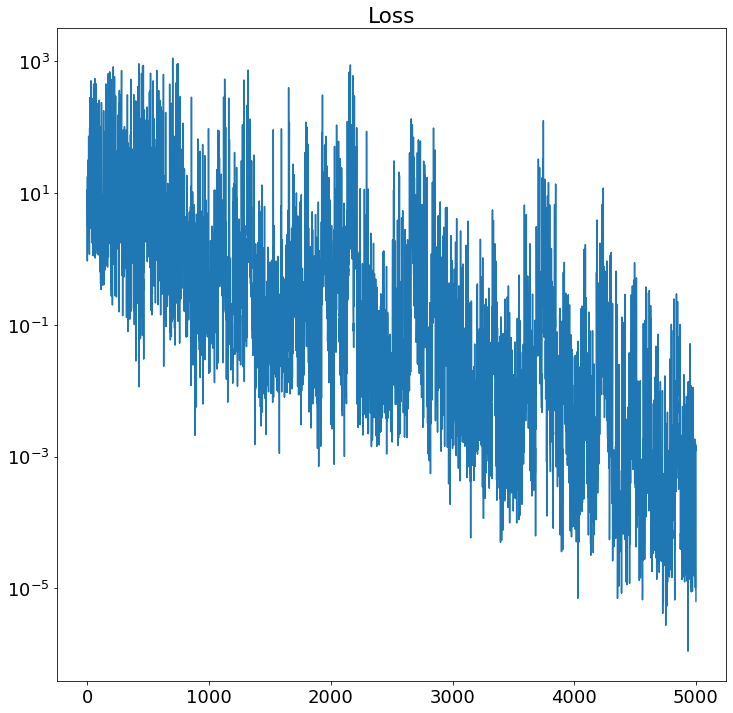

In [66]:
plt.plot(h['loss']); plt.yscale('log'); plt.title('Loss');

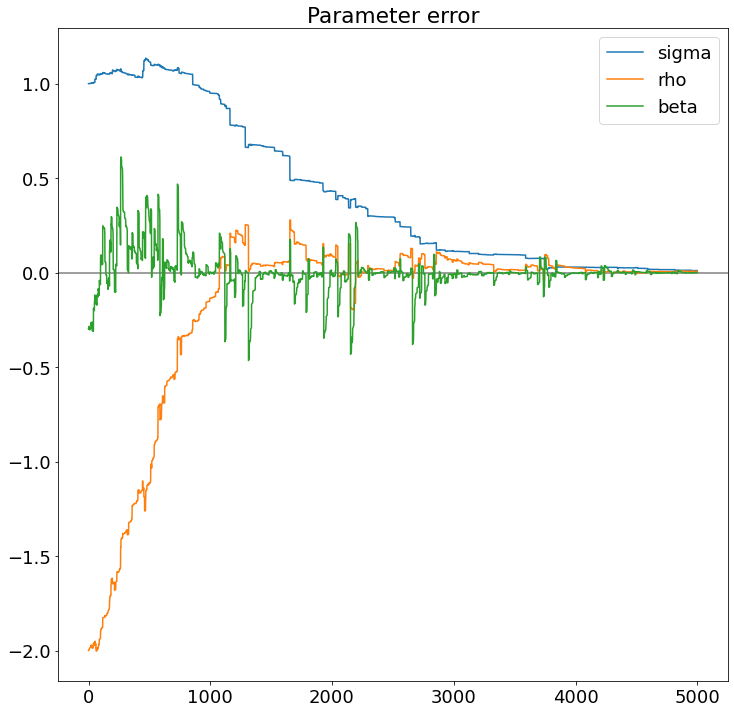

In [67]:
plot_params(h)

In [68]:
h = learning_loop(true_params, pert_params, 1e-3, 50, 2000, sparse=1)

  0%|          | 7/2000 [00:00<00:32, 61.22it/s]

Loss:  tensor(6.0321, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6058, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1143, grad_fn=<MeanBackward0>)
Loss:  tensor(9.8613, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(21.0541, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0475, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4724, grad_fn=<MeanBackward0>)
Loss:  tensor(182.1866, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4642, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1910, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1533, grad_fn=<MeanBackward0>)
Loss:  tensor(21.4127, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4004, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:00<00:35, 56.22it/s]

Loss:  tensor(1.5892, grad_fn=<MeanBackward0>)
Loss:  tensor(12.8668, grad_fn=<MeanBackward0>)
Loss:  tensor(156.3406, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0838, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9694, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7916, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6366, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9999, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1065, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4883, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5802, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:00<00:36, 54.50it/s]

Loss:  tensor(2.1907, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1850, grad_fn=<MeanBackward0>)
Loss:  tensor(155.5112, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0397, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3556, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1260, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8412, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3476, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3652, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7685, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4992, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5130, grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:00<00:34, 57.09it/s]

Loss:  tensor(2.2987, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7229, grad_fn=<MeanBackward0>)
Loss:  tensor(66.0620, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7568, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3242, grad_fn=<MeanBackward0>)
Loss:  tensor(6.6344, grad_fn=<MeanBackward0>)
Loss:  tensor(10.9413, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7532, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7378, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6652, grad_fn=<MeanBackward0>)
Loss:  tensor(18.6815, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6588, grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:01<00:28, 67.05it/s]

Loss:  tensor(5.8019, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2005, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5889, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8904, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7955, grad_fn=<MeanBackward0>)
Loss:  tensor(3.0189, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8373, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5526, grad_fn=<MeanBackward0>)
Loss:  tensor(6.9739, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7809, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3439, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9338, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0441, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7821, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5169, grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:01<00:35, 54.04it/s]

Loss:  tensor(1.6163, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9785, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2493, grad_fn=<MeanBackward0>)
Loss:  tensor(83.2482, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6164, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5697, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5545, grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:01<00:41, 46.16it/s]

Loss:  tensor(3.1871, grad_fn=<MeanBackward0>)
Loss:  tensor(10.0719, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9246, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6837, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4377, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9754, grad_fn=<MeanBackward0>)
Loss:  tensor(10.8880, grad_fn=<MeanBackward0>)


  4%|▍         | 89/2000 [00:01<00:42, 45.02it/s]

Loss:  tensor(1.8207, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7929, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4613, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5287, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7488, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4463, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6377, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0783, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1515, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9685, grad_fn=<MeanBackward0>)


  5%|▍         | 95/2000 [00:01<00:40, 47.48it/s]

Loss:  tensor(3.6739, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0480, grad_fn=<MeanBackward0>)
Loss:  tensor(15.7033, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5502, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5707, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4985, grad_fn=<MeanBackward0>)
Loss:  tensor(34.2129, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2256, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9337, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5160, grad_fn=<MeanBackward0>)


  6%|▌         | 110/2000 [00:02<00:33, 56.07it/s]

Loss:  tensor(20.4347, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6295, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3966, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2834, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8927, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6590, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1540, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0676, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1410, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4655, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5241, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7763, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1273, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2234, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4518, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1858, grad_fn=<MeanBackward0>)


  6%|▋         | 128/2000 [00:02<00:26, 70.85it/s]

Loss:  tensor(0.4541, grad_fn=<MeanBackward0>)
Loss:  tensor(15.8027, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3366, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7267, grad_fn=<MeanBackward0>)
Loss:  tensor(6.1869, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2073, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4694, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1256, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4663, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7747, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3136, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9156, grad_fn=<MeanBackward0>)
Loss:  tensor(8.1750, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2851, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1382, grad_fn=<MeanBackward0>)
Loss:  tensor(12.1967, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2384, grad_fn=<MeanBackward0>)


  7%|▋         | 147/2000 [00:02<00:23, 80.02it/s]

Loss:  tensor(1.1032, grad_fn=<MeanBackward0>)
Loss:  tensor(40.3532, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3782, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4315, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0135, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6867, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3525, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8061, grad_fn=<MeanBackward0>)
Loss:  tensor(10.5012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7663, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3944, grad_fn=<MeanBackward0>)
Loss:  tensor(11.3345, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8201, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6098, grad_fn=<MeanBackward0>)


  8%|▊         | 156/2000 [00:02<00:22, 80.35it/s]

Loss:  tensor(8.1757, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1542, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8550, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9404, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4651, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7613, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5164, grad_fn=<MeanBackward0>)
Loss: 

  9%|▊         | 172/2000 [00:02<00:28, 63.76it/s]

 tensor(0.2198, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0855, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3242, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3274, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8859, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6152, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3501, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6784, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7120, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2375, grad_fn=<MeanBackward0>)
Loss:  tensor(10.1031, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0504, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2134, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2356, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9338, grad_fn=<MeanBackward0>)


  9%|▉         | 189/2000 [00:03<00:25, 69.73it/s]

Loss:  tensor(0.9215, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3480, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6091, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3820, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1203, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2287, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6351, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1499, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0665, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1231, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3789, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2698, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1612, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3391, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3543, grad_fn=<MeanBackward0>)


 10%|█         | 205/2000 [00:03<00:24, 72.65it/s]

Loss:  tensor(1.7566, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5832, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0542, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2786, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0971, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4451, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0311, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7611, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7482, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8573, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0847, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9866, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5373, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4560, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5290, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5428, grad_fn=<MeanBackward0>)


 11%|█         | 222/2000 [00:03<00:23, 74.95it/s]

Loss:  tensor(0.4218, grad_fn=<MeanBackward0>)
Loss:  tensor(26.8541, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8189, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0136, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0834, grad_fn=<MeanBackward0>)
Loss:  tensor(14.8915, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8970, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4867, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0203, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9742, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8973, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0533, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0424, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5983, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0550, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2579, grad_fn=<MeanBackward0>)


 12%|█▏        | 230/2000 [00:03<00:26, 66.98it/s]

Loss:  tensor(0.9644, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2662, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0642, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0171, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0428, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3873, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7708, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3878, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0589, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4058, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8046, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0247, grad_fn=<MeanBackward0>)


 12%|█▏        | 244/2000 [00:03<00:26, 65.21it/s]

Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4330, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1900, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2765, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7238, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4921, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(12.2198, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4498, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0860, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8969, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5085, grad_fn=<MeanBackward0>)


 13%|█▎        | 261/2000 [00:04<00:25, 67.43it/s]

Loss:  tensor(0.3706, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1046, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2742, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7964, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5643, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4473, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0326, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0906, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2353, grad_fn=<MeanBackward0>)


 13%|█▎        | 268/2000 [00:04<00:31, 55.32it/s]

Loss:  tensor(0.0544, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1379, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0660, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2456, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2401, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1510, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6801, grad_fn=<MeanBackward0>)


 14%|█▍        | 280/2000 [00:04<00:36, 46.82it/s]

Loss:  tensor(0.5774, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5431, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1674, grad_fn=<MeanBackward0>)
Loss:  tensor(12.8497, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5507, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5697, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0874, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0381, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3543, grad_fn=<MeanBackward0>)


 14%|█▍        | 290/2000 [00:04<00:39, 43.63it/s]

Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1892, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8053, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6280, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5311, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4461, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7315, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2634, grad_fn=<MeanBackward0>)


 15%|█▍        | 296/2000 [00:05<00:36, 46.64it/s]

Loss:  tensor(0.1628, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3943, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4129, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0388, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6100, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2316, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0328, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3999, grad_fn=<MeanBackward0>)


 15%|█▌        | 306/2000 [00:05<00:42, 39.77it/s]

Loss:  tensor(0.3639, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5210, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8290, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2984, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5610, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)


 16%|█▌        | 315/2000 [00:05<00:44, 38.05it/s]

Loss:  tensor(0.5303, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0831, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5841, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(10.4253, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1205, grad_fn=<MeanBackward0>)


 16%|█▋        | 327/2000 [00:05<00:35, 47.43it/s]

Loss:  tensor(0.2185, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5390, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2088, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2161, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0861, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1808, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0754, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1546, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7339, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7165, grad_fn=<MeanBackward0>)


 17%|█▋        | 334/2000 [00:05<00:32, 50.91it/s]

Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1668, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2578, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1457, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6304, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1497, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3041, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7228e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1261, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3364, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)

 17%|█▋        | 346/2000 [00:06<00:35, 46.44it/s]


Loss:  tensor(0.0645, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1441, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1265, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0771, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5497, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2134, grad_fn=<MeanBackward0>)


 18%|█▊        | 356/2000 [00:06<00:36, 45.45it/s]

Loss:  tensor(0.0833, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0907, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8072, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4547, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0099, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8383, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2503, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0106, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3956, grad_fn=<MeanBackward0>)


 18%|█▊        | 367/2000 [00:06<00:33, 48.06it/s]

Loss:  tensor(0.4858, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4930, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1380, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0380, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0249, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0414, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0929, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0656, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0342, grad_fn=<MeanBackward0>)


 19%|█▉        | 378/2000 [00:06<00:33, 48.73it/s]

Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2506, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4677, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0211, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0257, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1281, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1288, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0656, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1223, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1945, grad_fn=<MeanBackward0>)


 19%|█▉        | 383/2000 [00:06<00:34, 46.58it/s]

Loss:  tensor(0.0633, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0616, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1689, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4329, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1536, grad_fn=<MeanBackward0>)


 20%|█▉        | 393/2000 [00:07<00:39, 40.88it/s]

Loss:  tensor(0.1520, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1134, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1461, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0677, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1163, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1713, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1994, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9594, grad_fn=<MeanBackward0>)


 20%|██        | 403/2000 [00:07<00:37, 42.63it/s]

Loss:  tensor(0.1469, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1474, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9418, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0745, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0995, grad_fn=<MeanBackward0>)
Loss:  tensor(16.3993, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2719, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0540, grad_fn=<MeanBackward0>)


 21%|██        | 414/2000 [00:07<00:35, 45.15it/s]

Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0225, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1688, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2601, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1169, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0157, grad_fn=<MeanBackward0>)
Loss:  

 21%|██        | 421/2000 [00:07<00:31, 50.57it/s]

tensor(0.1964, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1538, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1279, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0780, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1260, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7333, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1328, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0433, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1103, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6472, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0860, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0565, grad_fn=<MeanBackward0>)
Loss:  

 22%|██▏       | 433/2000 [00:08<00:31, 49.04it/s]

tensor(0.0974, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8850, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4771, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1760, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0151, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1469, grad_fn=<MeanBackward0>)


 22%|██▏       | 443/2000 [00:08<00:36, 42.36it/s]

Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8635, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1986, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1186, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0434, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2368, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0177, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)


 22%|██▏       | 448/2000 [00:08<00:37, 41.77it/s]

Loss:  tensor(1.2878, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1546, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1525, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1288, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2807, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2635, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0349, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4417, grad_fn=<MeanBackward0>)


 23%|██▎       | 460/2000 [00:08<00:33, 45.32it/s]

Loss:  tensor(0.6561, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1374, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0339, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5417, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2216, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1367, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2424, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8267, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1108, grad_fn=<MeanBackward0>)


 24%|██▎       | 471/2000 [00:08<00:32, 46.84it/s]

Loss:  tensor(0.0784, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3132, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0396, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0134, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1664, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1378, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3875, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0711, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0834, grad_fn=<MeanBackward0>)


 24%|██▍       | 483/2000 [00:09<00:29, 52.11it/s]

Loss:  tensor(0.0386, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0228, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1746, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8408, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0911, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0336, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0197, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2198e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0646, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0660, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)


 25%|██▍       | 497/2000 [00:09<00:25, 58.59it/s]

Loss:  tensor(0.0917, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0613, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0553, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0105, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4692, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0687, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0594, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4543, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0512, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1127, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3976, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1867, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)


 26%|██▌       | 512/2000 [00:09<00:23, 63.89it/s]

Loss:  tensor(0.1213, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7412, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1411, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1742, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3780, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0801, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8492, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0285, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0715, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0883, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0665, grad_fn=<MeanBackward0>)


 26%|██▋       | 527/2000 [00:09<00:21, 67.60it/s]

Loss:  tensor(2.1899, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0923, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0586, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3494, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0339, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8882, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0590, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0382, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6275, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0496, grad_fn=<MeanBackward0>)


 27%|██▋       | 544/2000 [00:09<00:20, 69.74it/s]

Loss:  tensor(1.0197, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0183, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0108, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1939, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1186, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0254, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0154, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2708, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0451, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0577, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0581, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0559, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0379, grad_fn=<MeanBackward0>)


 28%|██▊       | 560/2000 [00:10<00:20, 71.60it/s]

Loss:  tensor(0.1695, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0698, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1352, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0547, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1459, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0707, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6619, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0242, grad_fn=<MeanBackward0>)


 29%|██▉       | 576/2000 [00:10<00:20, 70.06it/s]

Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4686, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0338, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0465, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6292, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0877, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0223, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7899, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 30%|██▉       | 592/2000 [00:10<00:19, 72.92it/s]

Loss:  tensor(0.0150, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0416, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0286, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0621, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0607, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0187, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2229, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0775, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0318, grad_fn=<MeanBackward0>)


 30%|███       | 608/2000 [00:10<00:18, 75.83it/s]

Loss:  tensor(0.1918, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0368, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4248, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0552, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0508, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0598, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0269, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0293, grad_fn=<MeanBackward0>)


 31%|███       | 616/2000 [00:10<00:18, 74.57it/s]

Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0229, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0173, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0200, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2818, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0683, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3124e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0306, grad_fn=<MeanBackward0>)
Loss:  tensor(0.9622, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0501, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8541e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0780, grad_fn=<MeanBackward0>)


 32%|███▏      | 632/2000 [00:11<00:19, 71.07it/s]

Loss:  tensor(0.1371, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0458, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1124, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0156, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(9.7672e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0101, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0427, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2783, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4213, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2446, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0556, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)


 32%|███▏      | 649/2000 [00:11<00:19, 67.56it/s]

Loss:  tensor(0.0210, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0265, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0166, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0429, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0293, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4105, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2315e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0338, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0691, grad_fn=<MeanBackward0>)


 33%|███▎      | 665/2000 [00:11<00:18, 70.84it/s]

Loss:  tensor(0.0594, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0555, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1906, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0717, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2900, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0667, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0374, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8581e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0149, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0307, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3401, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0207, grad_fn=<MeanBackward0>)


 34%|███▍      | 681/2000 [00:11<00:18, 73.24it/s]

Loss:  tensor(0.0095, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3454, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0920, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1968, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0326, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0172, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0122, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0169, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0318, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3466, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0332, grad_fn=<MeanBackward0>)


 35%|███▍      | 697/2000 [00:12<00:17, 74.15it/s]

Loss:  tensor(0.0256, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0825, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1699, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0299, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0201, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6541e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0314, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0292, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0353, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0364, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0990, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1137, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0342, grad_fn=<MeanBackward0>)


 36%|███▌      | 713/2000 [00:12<00:17, 74.90it/s]

Loss:  tensor(0.0135, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0125, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0715, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0453, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9199e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0478, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0265, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0524, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5249, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0201, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0187, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)


 36%|███▌      | 721/2000 [00:12<00:18, 70.75it/s]

Loss:  tensor(0.8604, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0143, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0162, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0322, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0680, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0227, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3990, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7520, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)


 37%|███▋      | 737/2000 [00:12<00:18, 67.59it/s]

Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0130, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5903, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0054, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0443, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0251, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4060, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0182, grad_fn=<MeanBackward0>)


 38%|███▊      | 754/2000 [00:12<00:17, 70.53it/s]

Loss:  tensor(0.0221, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0121, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0363, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5790, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1508e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0346, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0191, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4398e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5300, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0097, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0157, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0510, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)


 39%|███▊      | 771/2000 [00:13<00:16, 72.69it/s]

Loss:  tensor(0.0905, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0171, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2037e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0601, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7118e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1989, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)


 39%|███▉      | 787/2000 [00:13<00:16, 75.12it/s]

Loss:  tensor(0.0154, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8554, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0467, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0124, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7374, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0408, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(9.2603e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)


 40%|███▉      | 795/2000 [00:13<00:16, 72.08it/s]

Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)
Loss:  tensor(0.7297, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0208, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0246, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0301, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0568, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0230, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2369, grad_fn=<MeanBackward0>)
Loss:  

 41%|████      | 811/2000 [00:13<00:16, 73.26it/s]

tensor(0.0252, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0422, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0641, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6833, grad_fn=<MeanBackward0>)
Loss:  tensor(9.7014e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0066, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0127, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3757, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1507, grad_fn=<MeanBackward0>)


 41%|████▏     | 828/2000 [00:13<00:16, 73.11it/s]

Loss:  tensor(0.0190, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0323, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0136, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0444, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2883, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(9.6357e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0330, grad_fn=<MeanBackward0>)


 42%|████▏     | 845/2000 [00:14<00:15, 74.30it/s]

Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0254, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0771, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0194, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0102, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3370, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0505, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 43%|████▎     | 861/2000 [00:14<00:15, 74.09it/s]

Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0329, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0670, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1289e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6999, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0195, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0209, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 44%|████▍     | 877/2000 [00:14<00:15, 72.21it/s]

Loss:  tensor(0.0291, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0055, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0418, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0084, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0089, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2298, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0067, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0078, grad_fn=<MeanBackward0>)
Loss:  tensor(9.3104e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0651, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1558, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8265e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 45%|████▍     | 893/2000 [00:14<00:14, 74.58it/s]

Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0072, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0092, grad_fn=<MeanBackward0>)
Loss:  tensor(8.1323e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3301, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0650, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2910e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4901e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0260, grad_fn=<MeanBackward0>)


 45%|████▌     | 909/2000 [00:14<00:14, 74.98it/s]

Loss:  tensor(0.0295, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1246, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0184, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0212, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9825e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1248, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)


 46%|████▋     | 925/2000 [00:15<00:14, 76.53it/s]

Loss:  tensor(0.0711, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3833e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0630, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8586, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0179, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)


 47%|████▋     | 941/2000 [00:15<00:13, 76.40it/s]

Loss:  tensor(0.0279, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0369, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0923, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7634e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.5930, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)


 48%|████▊     | 957/2000 [00:15<00:14, 73.30it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0599, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0049, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.3082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0270, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0337, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0249, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0050, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  

 49%|████▊     | 973/2000 [00:15<00:13, 75.14it/s]

tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0751, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0562, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0549e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9446e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0337, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0355, grad_fn=<MeanBackward0>)


 49%|████▉     | 989/2000 [00:16<00:13, 75.62it/s]

Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1153, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1931, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)


 50%|████▉     | 997/2000 [00:16<00:13, 74.21it/s]

Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0281, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1267, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2988e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3871e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0357, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8603, grad_fn=<MeanBackward0>)


 51%|█████     | 1014/2000 [00:16<00:13, 72.60it/s]

Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(8.2220e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0199, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0159, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2892e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0382, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)


 52%|█████▏    | 1031/2000 [00:16<00:13, 72.59it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2169, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0167, grad_fn=<MeanBackward0>)
Loss:  tensor(0.8349, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0288, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0120, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)


 52%|█████▏    | 1047/2000 [00:16<00:13, 70.97it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0182, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2520e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0275, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0566, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)


 53%|█████▎    | 1063/2000 [00:17<00:13, 71.93it/s]

Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9716e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0076, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0640, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1363e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9064e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)


 54%|█████▍    | 1079/2000 [00:17<00:12, 73.66it/s]

Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1392, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0883, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3773e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0163, grad_fn=<MeanBackward0>)


 55%|█████▍    | 1096/2000 [00:17<00:12, 74.47it/s]

Loss:  tensor(2.7537e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1998, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0058, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0667e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0135, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)


 56%|█████▌    | 1112/2000 [00:17<00:11, 75.14it/s]

Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0325, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5892e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.4927e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4891, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0116, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)


 56%|█████▋    | 1128/2000 [00:17<00:12, 71.78it/s]

Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0056, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4018e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0138, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0111, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0496, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0002e-06, grad_fn=<MeanBackward0>)


 57%|█████▋    | 1136/2000 [00:18<00:12, 67.04it/s]

Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.4075, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2254e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(7.7340e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0142, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0384, grad_fn=<MeanBackward0>)


 58%|█████▊    | 1152/2000 [00:18<00:12, 68.16it/s]

Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3304e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0080, grad_fn=<MeanBackward0>)
Loss:  tensor(8.8875e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7212e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0052, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2243, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0108, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0234, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0081, grad_fn=<MeanBackward0>)


 58%|█████▊    | 1168/2000 [00:18<00:11, 71.60it/s]

Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2070e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1206, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0244, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7841e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1914, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)


 59%|█████▉    | 1184/2000 [00:18<00:12, 67.66it/s]

Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0751, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1453e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5644e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0060, grad_fn=<MeanBackward0>)
Loss:  tensor(8.1745e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0580, grad_fn=<MeanBackward0>)


 60%|█████▉    | 1198/2000 [00:18<00:11, 66.96it/s]

Loss:  tensor(0.0133, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(1.2833e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1976, grad_fn=<MeanBackward0>)
Loss:  tensor(0.6989, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0199, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 61%|██████    | 1214/2000 [00:19<00:10, 71.67it/s]

Loss:  tensor(7.8479e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0570, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8384e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0359, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)


 62%|██████▏   | 1230/2000 [00:19<00:10, 72.85it/s]

Loss:  tensor(0.0164, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0161, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0244, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2195e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0112, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0118, grad_fn=<MeanBackward0>)
Loss:  tensor(6.6440e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0247, grad_fn=<MeanBackward0>)


 62%|██████▏   | 1246/2000 [00:19<00:10, 73.22it/s]

Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0240, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0297, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0255, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5825e-08, grad_fn=<MeanBackward0>)


 63%|██████▎   | 1263/2000 [00:19<00:09, 75.02it/s]

Loss:  tensor(0.1801, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9258e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6173e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0249, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0476, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0206, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8497e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 64%|██████▎   | 1271/2000 [00:19<00:09, 73.00it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.2064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0310, grad_fn=<MeanBackward0>)
Loss:  tensor(8.3340e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9327e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 64%|██████▍   | 1287/2000 [00:20<00:10, 70.68it/s]

Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0128, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1778, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6126e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0091, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2851e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)


 65%|██████▌   | 1304/2000 [00:20<00:09, 71.54it/s]

Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0077, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0185, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0333e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0109, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6941e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0705, grad_fn=<MeanBackward0>)


 66%|██████▌   | 1321/2000 [00:20<00:09, 72.02it/s]

Loss:  tensor(4.8700e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1290e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0279, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1204e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0667, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0091, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(2.4122e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 67%|██████▋   | 1337/2000 [00:20<00:08, 73.90it/s]

Loss:  tensor(0.0549, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0289, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0340, grad_fn=<MeanBackward0>)


 68%|██████▊   | 1353/2000 [00:21<00:09, 69.50it/s]

Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1641e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0293, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0926e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0329, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0546, grad_fn=<MeanBackward0>)


 68%|██████▊   | 1361/2000 [00:21<00:09, 70.14it/s]

Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(8.3767e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6822e-08, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4787e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0361, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0203, grad_fn=<MeanBackward0>)


 69%|██████▉   | 1378/2000 [00:21<00:08, 70.78it/s]

Loss:  tensor(2.4583e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0381, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0582e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1439e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2327e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0212, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)


 70%|██████▉   | 1395/2000 [00:21<00:08, 68.56it/s]

Loss:  tensor(2.1992e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(3.8122e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0175, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1089e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1397, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3314e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0028, grad_fn=<MeanBackward0>)


 71%|███████   | 1412/2000 [00:21<00:08, 72.12it/s]

Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0630, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5297e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4648e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8258e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0152, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7231e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0093, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1154e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7796e-05, grad_fn=<MeanBackward0>)


 71%|███████▏  | 1428/2000 [00:22<00:07, 73.27it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8454e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0727e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(4.5848e-07, grad_fn=<MeanBackward0>)


 72%|███████▏  | 1444/2000 [00:22<00:07, 74.13it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0730, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8862e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1050e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0194, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0063, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 73%|███████▎  | 1452/2000 [00:22<00:07, 72.45it/s]

Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0048, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6310e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1236, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0699, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9758e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 73%|███████▎  | 1468/2000 [00:22<00:07, 67.49it/s]

Loss:  tensor(4.6509e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0036, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0194, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0181, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(9.3030e-05, grad_fn=<MeanBackward0>)


 74%|███████▍  | 1485/2000 [00:22<00:07, 70.43it/s]

Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0390e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(3.7653e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0094, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0071, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3100e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 75%|███████▌  | 1501/2000 [00:23<00:06, 72.68it/s]

Loss:  tensor(0.0453, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1606e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7757e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0096, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0572e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0453, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(5.9799e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0953, grad_fn=<MeanBackward0>)
Loss: 

 76%|███████▌  | 1517/2000 [00:23<00:06, 70.66it/s]

 tensor(0.0073, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5515e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1346e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0126, grad_fn=<MeanBackward0>)


 77%|███████▋  | 1533/2000 [00:23<00:06, 73.66it/s]

Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0180, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1909e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0430, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0039, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6893e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 77%|███████▋  | 1541/2000 [00:23<00:06, 73.39it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3351e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3621e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0294, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0086, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6877e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4948e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(5.1517e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3787e-05, grad_fn=<MeanBackward0>)


 78%|███████▊  | 1558/2000 [00:23<00:06, 71.38it/s]

Loss:  tensor(0.0884, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0070, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8808e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3332e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1324, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 79%|███████▉  | 1575/2000 [00:24<00:05, 72.63it/s]

Loss:  tensor(7.3150e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(8.8600e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4606e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0079, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0566e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4984e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4364e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)


 79%|███████▉  | 1584/2000 [00:24<00:05, 74.11it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0204, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0232e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3370e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2767e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0214, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0040, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8598e-08, grad_fn=<MeanBackward0>)


 80%|███████▉  | 1599/2000 [00:24<00:06, 64.75it/s]

Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(9.6030e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.6157e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0873, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0139, grad_fn=<MeanBackward0>)


 81%|████████  | 1614/2000 [00:24<00:05, 65.64it/s]

Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(8.7304e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4567e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0114, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0176, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0046, grad_fn=<MeanBackward0>)


 81%|████████▏ | 1629/2000 [00:25<00:05, 64.35it/s]

Loss:  tensor(1.0248e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4674e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0164, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1904e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)


 82%|████████▏ | 1645/2000 [00:25<00:05, 69.20it/s]

Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2248e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0420, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0640, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0033, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0069, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1877e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7352e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0467, grad_fn=<MeanBackward0>)


 83%|████████▎ | 1653/2000 [00:25<00:05, 68.96it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0064, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(2.0607e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 83%|████████▎ | 1667/2000 [00:25<00:05, 61.01it/s]

Loss:  tensor(1.6087e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0458, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0170, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6393e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9967e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.2601e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0617, grad_fn=<MeanBackward0>)


 84%|████████▍ | 1683/2000 [00:25<00:04, 66.60it/s]

Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0487, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0027, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0082, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7713e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0341, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0068, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7333e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(7.1677e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0165e-06, grad_fn=<MeanBackward0>)


 85%|████████▍ | 1699/2000 [00:26<00:04, 71.52it/s]

Loss:  tensor(9.7239e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8298e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0753e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0043, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4977e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3744e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4439e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(2.3268e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1748e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.1289e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 86%|████████▌ | 1715/2000 [00:26<00:03, 74.36it/s]

Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7670e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.1233, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(9.9404e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1096e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4045e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.5323e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0034, grad_fn=<MeanBackward0>)
Loss:  tensor(3.2962e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 87%|████████▋ | 1731/2000 [00:26<00:03, 75.18it/s]

Loss:  tensor(0.0057, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7757e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4707e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0090, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0155, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0017, grad_fn=<MeanBackward0>)
Loss:  tensor(4.6171e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3468e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0062, grad_fn=<MeanBackward0>)


 87%|████████▋ | 1739/2000 [00:26<00:03, 68.39it/s]

Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(3.3306e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5803e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0032, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0326e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0020, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0037, grad_fn=<MeanBackward0>)
Loss:  tensor(1.5967e-06, grad_fn=<MeanBackward0>)


 88%|████████▊ | 1756/2000 [00:26<00:03, 69.48it/s]

Loss:  tensor(5.2082e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5976e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0567, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(4.0051e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0044, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7070e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2819e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 89%|████████▊ | 1772/2000 [00:27<00:03, 69.68it/s]

Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0237, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0009, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0042, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0006, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4801e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0233, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9096e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5289e-05, grad_fn=<MeanBackward0>)


 89%|████████▉ | 1789/2000 [00:27<00:02, 71.91it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3048e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(4.4833e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(1.4983e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 90%|█████████ | 1805/2000 [00:27<00:02, 74.75it/s]

Loss:  tensor(1.0460e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.5874e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.4833e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0384, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5507e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0053, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(5.2384e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.7404e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0513, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)


 91%|█████████ | 1821/2000 [00:27<00:02, 70.90it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0179, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1120e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(7.2301e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0045, grad_fn=<MeanBackward0>)
Loss:  tensor(8.5217e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.6958e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.7493e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0275, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0500e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


 92%|█████████▏| 1837/2000 [00:27<00:02, 72.86it/s]

Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0213, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0030, grad_fn=<MeanBackward0>)
Loss:  tensor(8.8421e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(2.5857e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9581e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8598e-08, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(7.8730e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0011, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7069e-05, grad_fn=<MeanBackward0>)


 93%|█████████▎| 1853/2000 [00:28<00:01, 74.89it/s]

Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0085, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(3.9357e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.1470e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0059, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(9.2081e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.1232e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)


 93%|█████████▎| 1869/2000 [00:28<00:01, 75.64it/s]

Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0929, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4359e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(4.2316e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(2.9023e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.3812e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5312e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0080e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0026, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)


 94%|█████████▍| 1885/2000 [00:28<00:01, 76.02it/s]

Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(2.1346e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7631e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7494e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8466e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0031, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7780e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0035, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)


 95%|█████████▍| 1893/2000 [00:28<00:01, 69.62it/s]

Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(4.8541e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0051, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0015, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0025, grad_fn=<MeanBackward0>)
Loss:  tensor(3.4829e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0061, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(3.6356e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8831e-05, grad_fn=<MeanBackward0>)


 95%|█████████▌| 1909/2000 [00:28<00:01, 69.02it/s]

Loss:  tensor(0.0012, grad_fn=<MeanBackward0>)
Loss:  tensor(1.9640e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0478e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0038, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8912e-07, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0047, grad_fn=<MeanBackward0>)
Loss:  tensor(7.3358e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.2602e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.7685e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7338e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3984e-08, grad_fn=<MeanBackward0>)
Loss:  tensor(3.1333e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)


 96%|█████████▋| 1926/2000 [00:29<00:01, 71.80it/s]

Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6634e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(9.5838e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0014, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5272e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.4247e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(7.6212e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4775e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0023, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7774e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0342, grad_fn=<MeanBackward0>)


 97%|█████████▋| 1942/2000 [00:29<00:00, 72.93it/s]

Loss:  tensor(0.0004, grad_fn=<MeanBackward0>)
Loss:  tensor(2.6985e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.2333e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0016, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(9.9096e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0007, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0794e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0024, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(3.5752e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4196e-06, grad_fn=<MeanBackward0>)


 98%|█████████▊| 1959/2000 [00:29<00:00, 73.37it/s]

Loss:  tensor(0.0140, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(9.4415e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8807e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0021, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(6.3751e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0029, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(1.3038e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7021e-05, grad_fn=<MeanBackward0>)


 98%|█████████▊| 1967/2000 [00:29<00:00, 73.58it/s]

Loss:  tensor(0.0174, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(6.0381e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8711e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0098, grad_fn=<MeanBackward0>)
Loss:  tensor(1.1005e-08, grad_fn=<MeanBackward0>)
Loss:  tensor(4.3151e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.4218e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(4.9053e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0013, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0005, grad_fn=<MeanBackward0>)
Loss:  tensor(1.7297e-05, grad_fn=<MeanBackward0>)


 99%|█████████▉| 1983/2000 [00:29<00:00, 67.09it/s]

Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0041, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(7.0583e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(1.8595e-06, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0008, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0002, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7819e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0019, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0010, grad_fn=<MeanBackward0>)


100%|██████████| 2000/2000 [00:30<00:00, 66.18it/s]

Loss:  tensor(2.3425e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(8.0393e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0219, grad_fn=<MeanBackward0>)
Loss:  tensor(2.8910e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0001, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0003, grad_fn=<MeanBackward0>)
Loss:  tensor(5.8557e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(6.7313e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(5.7100e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(2.7482e-05, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0022, grad_fn=<MeanBackward0>)
Loss:  tensor(0.0018, grad_fn=<MeanBackward0>)
Loss:  tensor(1.0397e-05, grad_fn=<MeanBackward0>)
-- -- -- -- -- -- -- -- -- -- -- -- --
 
Total Loss:  tensor(1.0397e-05, grad_fn=<MeanBackward0>)


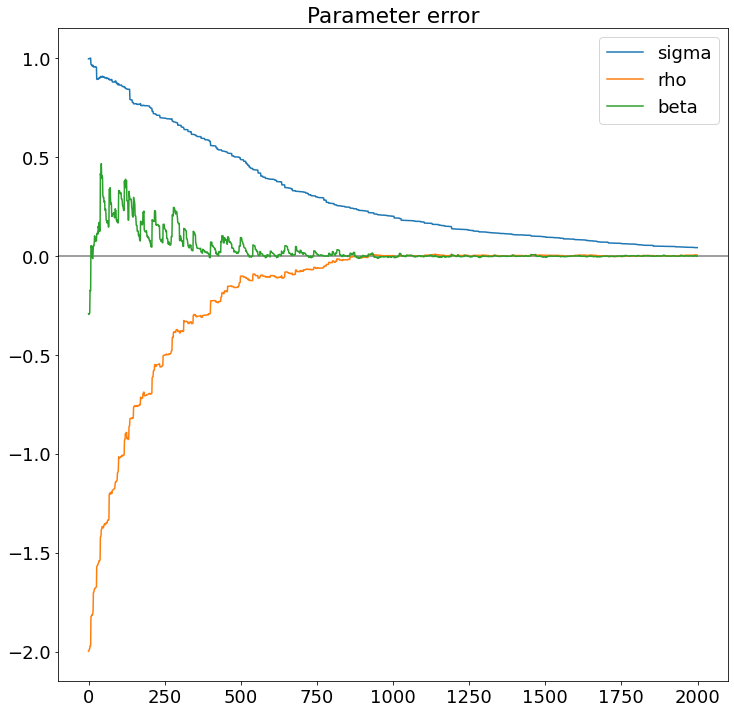

In [69]:
plot_params(h)

### PyTorch Sequential - in progress

In [51]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [52]:
class BobTheLorenzBuilder():
    def __init__(self, sigma, rho, beta, initparam1, initparam2, initparam3, dt, T):
        self.beta = beta
        self.rho = rho
        self.sigma = sigma
        self.initparam1 = initparam1
        self.initparam2 = initparam2
        self.initparam3 = initparam3
        self.dt = dt
        self.T = T
        print('sigma: ', self.sigma, 'rho: ', self.rho, 'beta: ', self.beta, 'init params: ', [self.initparam1, self.initparam2, self.initparam3], 'dt: ', self.dt)
        print('Chosen dt: ', self.dt)
        print('Chosen T: ', self.T)
  
    def InitializeAttractor(self, x, t):
        return [
            self.sigma * (x[1] - x[0]),
            x[0] * (self.rho - x[2]) - x[1],
            x[0] * x[1] - self.beta * x[2],
        ]

    def MakeAttractor(self):
        seed = 100
        np.random.seed(seed)
        t_range = np.arange(0, 100, self.dt)
        x0_params = [self.initparam1, self.initparam2, self.initparam3]
        print("x0 initialization parameters: ", x0_params)
        print("t_range: ", t_range)
        odesol = odeint(self.InitializeAttractor, x0_params, t_range)
        xdot_measured = np.array([self.InitializeAttractor(odesol[i], 0) for i in range(t_range.size)])
        self.odesol = odesol
        print('odesol matrix shape: ', odesol.shape)
        print('odesol matrix type: ', type(odesol))
        self.xdot_measured = xdot_measured
        self.t_range = t_range
        return odesol
    
    def VisualizeIt(self):
        fig = plt.figure(figsize=(30, 15))
        ax = fig.add_subplot(131, projection="3d")
        ax.plot(
            self.odesol[: self.t_range.size, 0],
            self.odesol[: self.t_range.size, 1],
            self.odesol[: self.t_range.size, 2],
        )
        plt.title("Attractor Visualized")
        ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
        fig.show()
        plt.figure(figsize = (30,20))
        plt.plot(self.odesol[:self.t_range.size], linewidth = 1)
        plt.show()
        
    def MysteryLorenz(self, x_y_z, t0):
        x, y, z = x_y_z
        return [self.sigma * (y - x), x * (self.rho - z) - y, x * y - self.beta * z]
    
    def NeuralLorenzMaker(self):
        t = np.arange(0, self.T + self.dt, self.dt)
        nn_input = np.zeros((100 * (len(t) - 1),3))
        nn_output = np.zeros_like(nn_input)
        fig, ax = plt.subplots(1, 1, subplot_kw = {'projection':'3d'})
        np.random.seed(123)
        x0 = -15 + 30 * np.random.random((100, 3))
        x_t = np.asarray([odeint(self.MysteryLorenz, x0_j, t) for x0_j in x0])
        for j in range(100):
            nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
            nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
            x, y, z = x_t[j,:,:].T
            ax.plot(x, y, z,linewidth=1)
            ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
        ax.view_init(18, -113)
        plt.show()
        self.nn_input = nn_input
        self.nn_output = nn_output

    def MakeInputTensor(self):
        xpretens = self.nn_input
        nn_input = torch.tensor(xpretens)
        return nn_input
    
    def MakeOutputTensor(self):
        ypretens = self.nn_output
        nn_output = torch.tensor(ypretens)
        return nn_output

In [53]:
attractor = BobTheLorenzBuilder(10, 28, 2.66667, -8, 8, 27, 0.002, 8)
attractor.MakeAttractor()
attractor.NeuralLorenzMaker()
input_tensor = attractor.MakeInputTensor()
output_tensor = attractor.MakeOutputTensor()

sigma:  10 rho:  28 beta:  2.66667 init params:  [-8, 8, 27] dt:  0.002
Chosen dt:  0.002
Chosen T:  8
x0 initialization parameters:  [-8, 8, 27]
t_range:  [0.0000e+00 2.0000e-03 4.0000e-03 ... 9.9994e+01 9.9996e+01 9.9998e+01]
odesol matrix shape:  (50000, 3)
odesol matrix type:  <class 'numpy.ndarray'>


In [54]:
print(f"Shape of tensor: {input_tensor.shape}")
print(f"Tensor dtype: {input_tensor.dtype}")
print(f"Tensor location: {input_tensor.device}")
print('-- -- -- -- -- -- -- --')
print(f"Shape of tensor: {output_tensor.shape}")
print(f"Tensor dtype: {output_tensor.dtype}")
print(f"Tensor location: {output_tensor.device}")

Shape of tensor: torch.Size([400100, 3])
Tensor dtype: torch.float64
Tensor location: cpu
-- -- -- -- -- -- -- --
Shape of tensor: torch.Size([400100, 3])
Tensor dtype: torch.float64
Tensor location: cpu
